In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# функция для преобразования выхода генератора (с OHE) в привычный формат
def create_image_from_array(color_array):
    color_map = {
        1: (255, 255, 255),  # белый
        0: (0, 0, 0),        # черный
        2: (255, 0, 0),      # красный
        3: (0, 0, 255)       # синий
    }
    array = np.array(color_array, dtype=np.uint8)
    height, width = array.shape
    image = Image.new('RGB', (width, height))
    pixels = image.load()
    for y in range(height):
        for x in range(width):
            pixels[x, y] = color_map[array[y, x]]
    return image

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

In [5]:
data= []
for i in range(0, 12):
    path = r'C:\Users\Nick\Documents\CESAGAN\data\{0}.png'.format(i)
    img = Image.open(path).convert('L')
    img = np.array(img)/255
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] > 0. and img[i][j] < 1.0:
                if img[i][j] < 0.5:
                    img[i][j] = 2
                else:
                    img[i][j] = 3
    # One-Hot Encoding
    tmp = np.array(img.tolist(), dtype=np.int8)
    num_tile_types = 4  # Стена, дорога, старт, финиш
    one_hot_level = np.eye(num_tile_types)[tmp]  # Размер: (40, 28, num_tile_types)
    one_hot_level = one_hot_level.transpose(2, 0, 1) 
    # Нормировка
    one_hot_level = 2 * one_hot_level - 1
    data.append(torch.tensor(one_hot_level, dtype=torch.float32))
data = torch.stack(data, dim=0)

In [7]:
data.shape

torch.Size([12, 4, 28, 40])

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(100, 64, kernel_size=(7,10), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x): 
        return self.seq(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.seq(x)

In [11]:
z_dim = 100
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()  
G_optimizer = optim.Adam(G.parameters(), lr = 0.0001, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = 0.0001, betas=(0.5, 0.999))
bs = 12

[0/200]: loss_d: 1.342, loss_g: 0.996


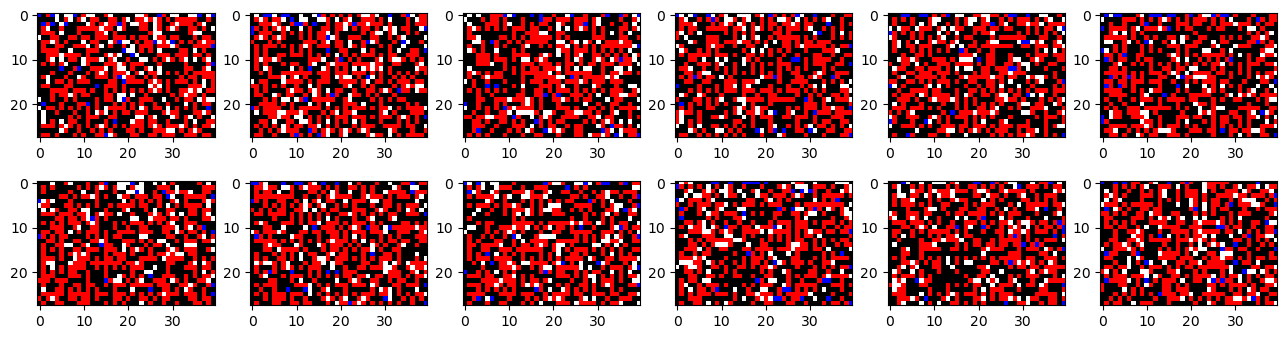

[1/200]: loss_d: 1.375, loss_g: 0.912
[2/200]: loss_d: 1.291, loss_g: 0.930
[3/200]: loss_d: 1.213, loss_g: 1.016
[4/200]: loss_d: 1.216, loss_g: 0.924
[5/200]: loss_d: 1.237, loss_g: 0.860
[6/200]: loss_d: 1.112, loss_g: 1.009
[7/200]: loss_d: 1.071, loss_g: 1.015
[8/200]: loss_d: 1.047, loss_g: 1.014
[9/200]: loss_d: 1.058, loss_g: 0.974
[10/200]: loss_d: 1.030, loss_g: 0.975
[11/200]: loss_d: 1.013, loss_g: 0.997
[12/200]: loss_d: 0.988, loss_g: 1.015
[13/200]: loss_d: 0.925, loss_g: 1.050
[14/200]: loss_d: 1.032, loss_g: 0.904
[15/200]: loss_d: 0.909, loss_g: 1.035
[16/200]: loss_d: 0.944, loss_g: 0.965
[17/200]: loss_d: 0.884, loss_g: 1.078
[18/200]: loss_d: 0.896, loss_g: 1.009
[19/200]: loss_d: 0.910, loss_g: 0.951
[20/200]: loss_d: 0.835, loss_g: 1.073
[21/200]: loss_d: 0.866, loss_g: 1.020
[22/200]: loss_d: 0.831, loss_g: 1.038
[23/200]: loss_d: 0.878, loss_g: 0.975
[24/200]: loss_d: 0.886, loss_g: 0.961
[25/200]: loss_d: 0.777, loss_g: 1.115
[26/200]: loss_d: 0.823, loss_g: 1

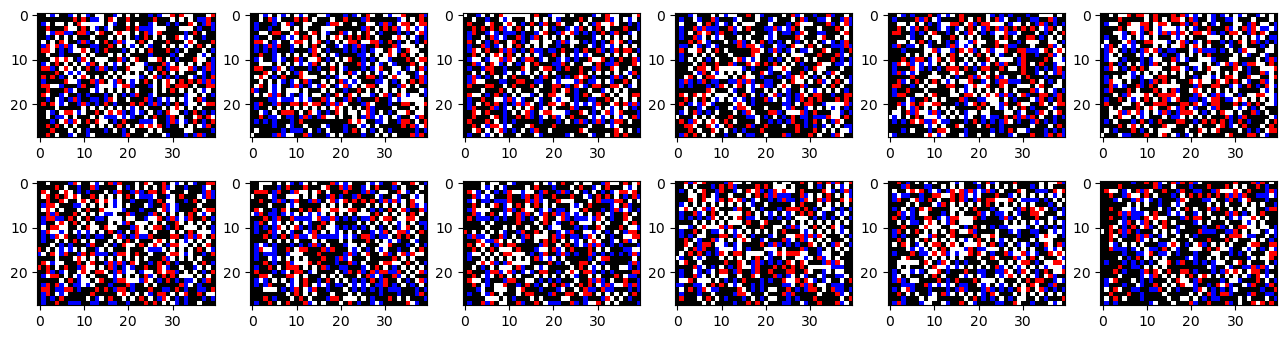

[101/200]: loss_d: 0.593, loss_g: 1.347
[102/200]: loss_d: 0.636, loss_g: 1.231
[103/200]: loss_d: 0.617, loss_g: 1.241
[104/200]: loss_d: 0.636, loss_g: 1.215
[105/200]: loss_d: 0.600, loss_g: 1.293
[106/200]: loss_d: 0.610, loss_g: 1.267
[107/200]: loss_d: 0.558, loss_g: 1.397
[108/200]: loss_d: 0.579, loss_g: 1.349
[109/200]: loss_d: 0.612, loss_g: 1.273
[110/200]: loss_d: 0.602, loss_g: 1.251
[111/200]: loss_d: 0.573, loss_g: 1.333
[112/200]: loss_d: 0.629, loss_g: 1.223
[113/200]: loss_d: 0.607, loss_g: 1.254
[114/200]: loss_d: 0.604, loss_g: 1.252
[115/200]: loss_d: 0.571, loss_g: 1.377
[116/200]: loss_d: 0.627, loss_g: 1.199
[117/200]: loss_d: 0.559, loss_g: 1.346
[118/200]: loss_d: 0.602, loss_g: 1.247
[119/200]: loss_d: 0.532, loss_g: 1.450
[120/200]: loss_d: 0.585, loss_g: 1.341
[121/200]: loss_d: 0.544, loss_g: 1.403
[122/200]: loss_d: 0.634, loss_g: 1.205
[123/200]: loss_d: 0.584, loss_g: 1.292
[124/200]: loss_d: 0.572, loss_g: 1.367
[125/200]: loss_d: 0.548, loss_g: 1.397


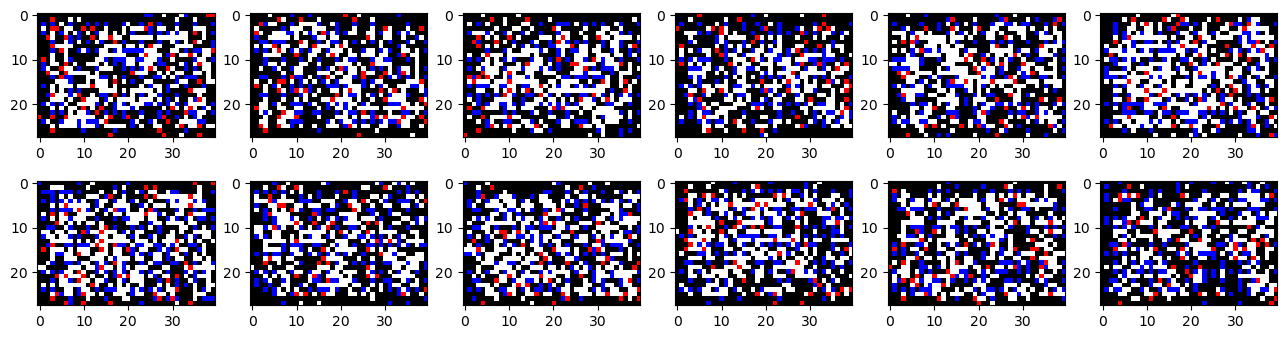

[201/200]: loss_d: 0.322, loss_g: 1.901
[202/200]: loss_d: 0.349, loss_g: 1.797
[203/200]: loss_d: 0.320, loss_g: 1.992
[204/200]: loss_d: 0.377, loss_g: 1.669
[205/200]: loss_d: 0.337, loss_g: 1.998
[206/200]: loss_d: 0.338, loss_g: 1.873
[207/200]: loss_d: 0.320, loss_g: 2.004
[208/200]: loss_d: 0.350, loss_g: 1.775
[209/200]: loss_d: 0.343, loss_g: 1.863
[210/200]: loss_d: 0.317, loss_g: 1.943
[211/200]: loss_d: 0.308, loss_g: 2.026
[212/200]: loss_d: 0.276, loss_g: 2.203
[213/200]: loss_d: 0.293, loss_g: 2.020
[214/200]: loss_d: 0.307, loss_g: 1.988
[215/200]: loss_d: 0.322, loss_g: 1.878
[216/200]: loss_d: 0.259, loss_g: 2.242
[217/200]: loss_d: 0.337, loss_g: 1.840
[218/200]: loss_d: 0.393, loss_g: 1.667
[219/200]: loss_d: 0.327, loss_g: 2.023
[220/200]: loss_d: 0.359, loss_g: 1.849
[221/200]: loss_d: 0.313, loss_g: 2.027
[222/200]: loss_d: 0.303, loss_g: 2.063
[223/200]: loss_d: 0.295, loss_g: 2.017
[224/200]: loss_d: 0.296, loss_g: 2.064
[225/200]: loss_d: 0.275, loss_g: 2.136


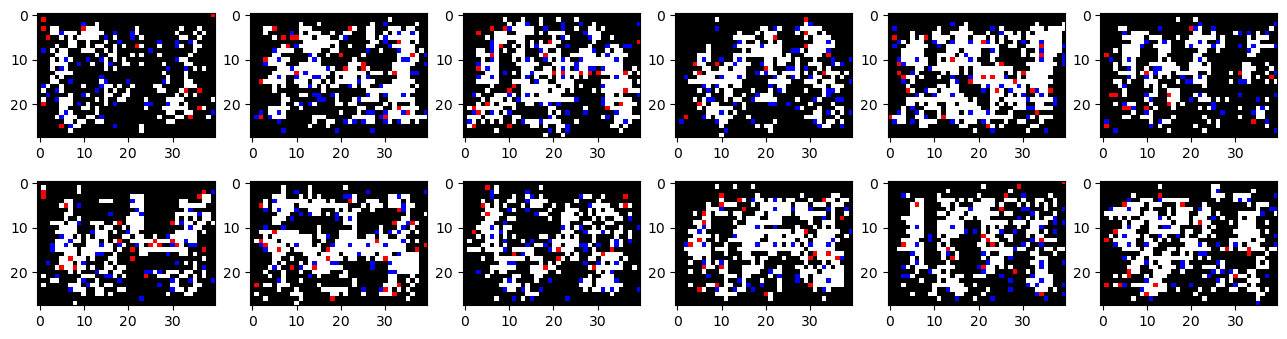

[301/200]: loss_d: 0.186, loss_g: 2.517
[302/200]: loss_d: 0.203, loss_g: 2.453
[303/200]: loss_d: 0.176, loss_g: 2.622
[304/200]: loss_d: 0.149, loss_g: 2.886
[305/200]: loss_d: 0.225, loss_g: 2.228
[306/200]: loss_d: 0.197, loss_g: 2.569
[307/200]: loss_d: 0.197, loss_g: 2.548
[308/200]: loss_d: 0.211, loss_g: 2.359
[309/200]: loss_d: 0.204, loss_g: 2.447
[310/200]: loss_d: 0.201, loss_g: 2.491
[311/200]: loss_d: 0.176, loss_g: 2.653
[312/200]: loss_d: 0.201, loss_g: 2.450
[313/200]: loss_d: 0.167, loss_g: 2.721
[314/200]: loss_d: 0.222, loss_g: 2.411
[315/200]: loss_d: 0.199, loss_g: 2.468
[316/200]: loss_d: 0.158, loss_g: 2.934
[317/200]: loss_d: 0.220, loss_g: 2.331
[318/200]: loss_d: 0.187, loss_g: 2.624
[319/200]: loss_d: 0.179, loss_g: 2.614
[320/200]: loss_d: 0.192, loss_g: 2.482
[321/200]: loss_d: 0.206, loss_g: 2.401
[322/200]: loss_d: 0.155, loss_g: 2.852
[323/200]: loss_d: 0.184, loss_g: 2.533
[324/200]: loss_d: 0.163, loss_g: 2.698
[325/200]: loss_d: 0.162, loss_g: 2.692


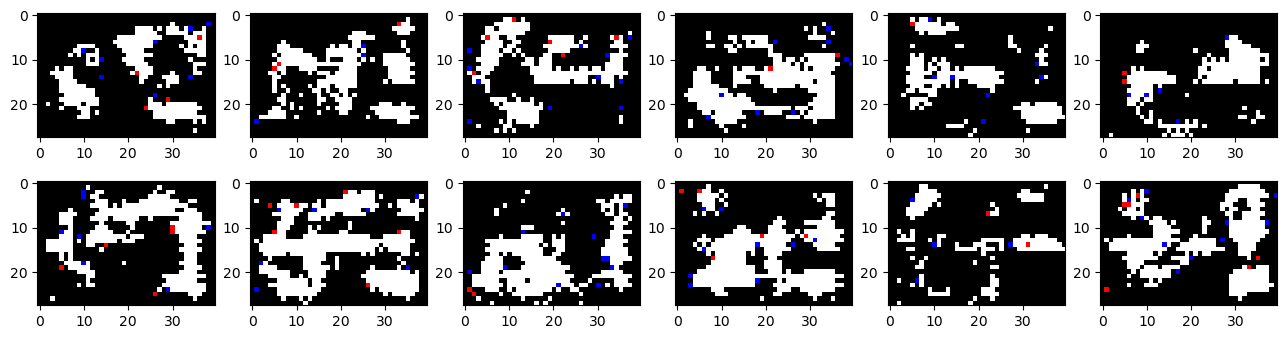

[401/200]: loss_d: 0.134, loss_g: 3.024
[402/200]: loss_d: 0.165, loss_g: 2.959
[403/200]: loss_d: 0.141, loss_g: 2.950
[404/200]: loss_d: 0.151, loss_g: 2.773
[405/200]: loss_d: 0.128, loss_g: 2.985
[406/200]: loss_d: 0.141, loss_g: 2.957
[407/200]: loss_d: 0.138, loss_g: 2.886
[408/200]: loss_d: 0.146, loss_g: 2.810
[409/200]: loss_d: 0.126, loss_g: 2.953
[410/200]: loss_d: 0.167, loss_g: 2.793
[411/200]: loss_d: 0.161, loss_g: 2.821
[412/200]: loss_d: 0.147, loss_g: 2.742
[413/200]: loss_d: 0.119, loss_g: 2.930
[414/200]: loss_d: 0.154, loss_g: 2.906
[415/200]: loss_d: 0.124, loss_g: 3.160
[416/200]: loss_d: 0.138, loss_g: 2.861
[417/200]: loss_d: 0.140, loss_g: 2.887
[418/200]: loss_d: 0.148, loss_g: 2.859
[419/200]: loss_d: 0.127, loss_g: 2.952
[420/200]: loss_d: 0.157, loss_g: 2.776
[421/200]: loss_d: 0.185, loss_g: 2.952
[422/200]: loss_d: 0.143, loss_g: 3.009
[423/200]: loss_d: 0.117, loss_g: 2.811
[424/200]: loss_d: 0.142, loss_g: 2.838
[425/200]: loss_d: 0.131, loss_g: 3.252


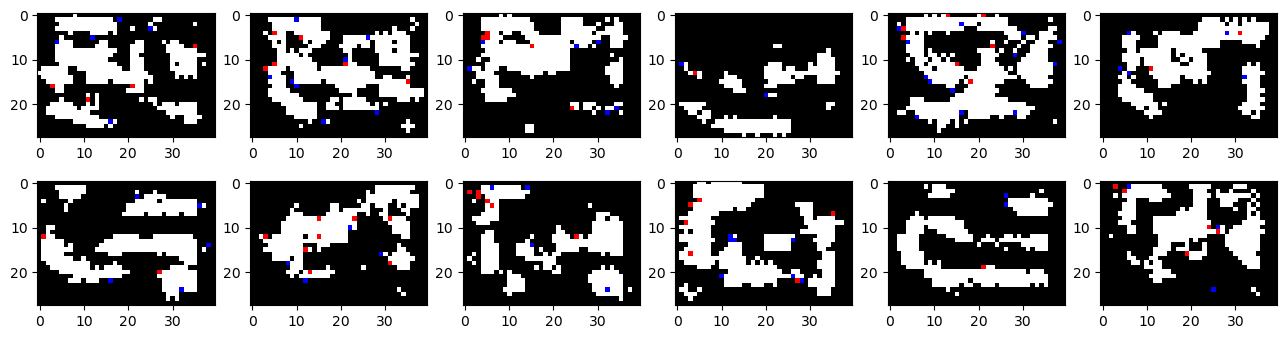

[501/200]: loss_d: 0.094, loss_g: 3.179
[502/200]: loss_d: 0.105, loss_g: 3.182
[503/200]: loss_d: 0.109, loss_g: 3.109
[504/200]: loss_d: 0.122, loss_g: 3.035
[505/200]: loss_d: 0.095, loss_g: 3.321
[506/200]: loss_d: 0.118, loss_g: 2.997
[507/200]: loss_d: 0.100, loss_g: 3.470
[508/200]: loss_d: 0.106, loss_g: 3.257
[509/200]: loss_d: 0.111, loss_g: 3.060
[510/200]: loss_d: 0.094, loss_g: 3.183
[511/200]: loss_d: 0.087, loss_g: 3.353
[512/200]: loss_d: 0.140, loss_g: 3.125
[513/200]: loss_d: 0.113, loss_g: 3.282
[514/200]: loss_d: 0.102, loss_g: 3.133
[515/200]: loss_d: 0.102, loss_g: 3.191
[516/200]: loss_d: 0.074, loss_g: 3.646
[517/200]: loss_d: 0.086, loss_g: 3.349
[518/200]: loss_d: 0.119, loss_g: 3.162
[519/200]: loss_d: 0.111, loss_g: 3.213
[520/200]: loss_d: 0.092, loss_g: 3.269
[521/200]: loss_d: 0.103, loss_g: 3.327
[522/200]: loss_d: 0.080, loss_g: 3.582
[523/200]: loss_d: 0.073, loss_g: 3.511
[524/200]: loss_d: 0.104, loss_g: 3.210
[525/200]: loss_d: 0.080, loss_g: 3.441


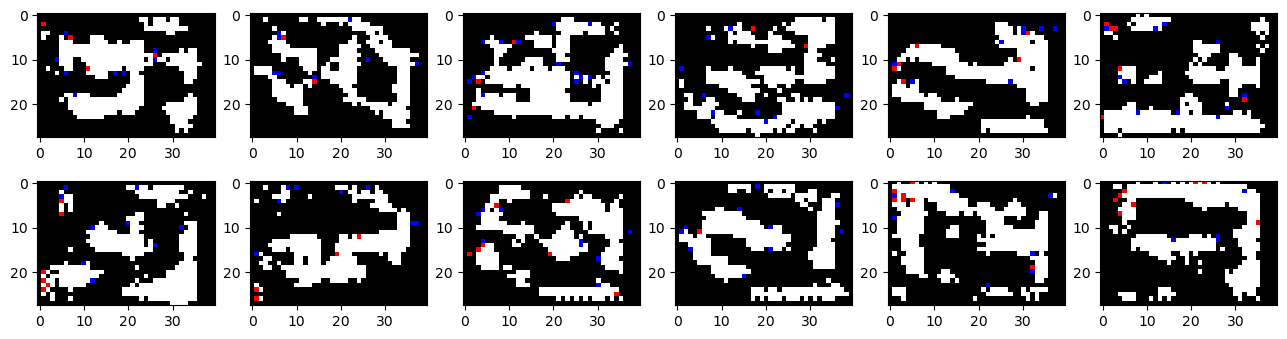

[601/200]: loss_d: 0.072, loss_g: 3.534
[602/200]: loss_d: 0.077, loss_g: 3.434
[603/200]: loss_d: 0.070, loss_g: 3.531
[604/200]: loss_d: 0.065, loss_g: 3.608
[605/200]: loss_d: 0.061, loss_g: 3.625
[606/200]: loss_d: 0.063, loss_g: 3.592
[607/200]: loss_d: 0.074, loss_g: 3.586
[608/200]: loss_d: 0.073, loss_g: 3.565
[609/200]: loss_d: 0.059, loss_g: 3.727
[610/200]: loss_d: 0.061, loss_g: 3.791
[611/200]: loss_d: 0.067, loss_g: 3.662
[612/200]: loss_d: 0.065, loss_g: 3.793
[613/200]: loss_d: 0.064, loss_g: 3.880
[614/200]: loss_d: 0.085, loss_g: 3.632
[615/200]: loss_d: 0.074, loss_g: 3.622
[616/200]: loss_d: 0.063, loss_g: 3.591
[617/200]: loss_d: 0.071, loss_g: 3.308
[618/200]: loss_d: 0.070, loss_g: 3.608
[619/200]: loss_d: 0.096, loss_g: 3.700
[620/200]: loss_d: 0.079, loss_g: 3.518
[621/200]: loss_d: 0.056, loss_g: 3.712
[622/200]: loss_d: 0.097, loss_g: 3.394
[623/200]: loss_d: 0.077, loss_g: 3.484
[624/200]: loss_d: 0.065, loss_g: 3.750
[625/200]: loss_d: 0.074, loss_g: 3.500


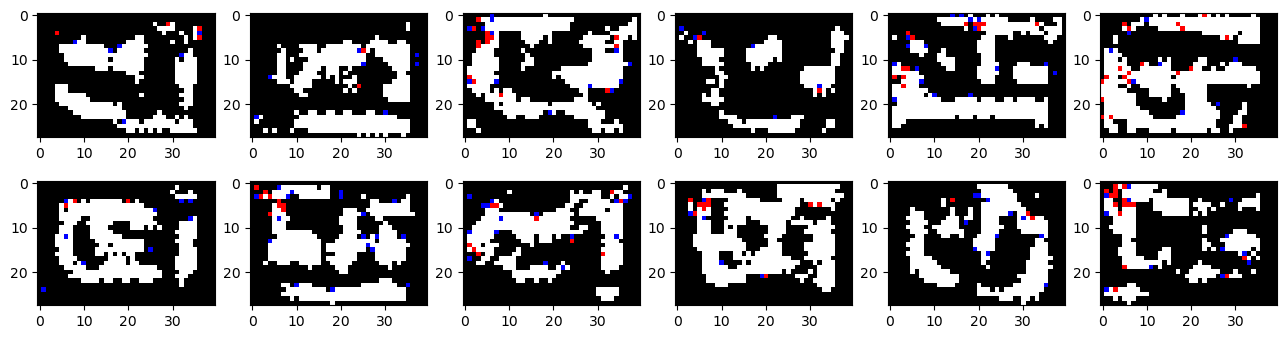

[701/200]: loss_d: 0.061, loss_g: 3.721
[702/200]: loss_d: 0.042, loss_g: 4.067
[703/200]: loss_d: 0.050, loss_g: 3.778
[704/200]: loss_d: 0.045, loss_g: 4.031
[705/200]: loss_d: 0.054, loss_g: 3.860
[706/200]: loss_d: 0.051, loss_g: 4.028
[707/200]: loss_d: 0.045, loss_g: 4.012
[708/200]: loss_d: 0.064, loss_g: 3.799
[709/200]: loss_d: 0.048, loss_g: 4.091
[710/200]: loss_d: 0.053, loss_g: 3.801
[711/200]: loss_d: 0.049, loss_g: 4.004
[712/200]: loss_d: 0.048, loss_g: 3.927
[713/200]: loss_d: 0.054, loss_g: 3.903
[714/200]: loss_d: 0.055, loss_g: 4.132
[715/200]: loss_d: 0.057, loss_g: 3.711
[716/200]: loss_d: 0.042, loss_g: 4.116
[717/200]: loss_d: 0.050, loss_g: 3.877
[718/200]: loss_d: 0.048, loss_g: 4.121
[719/200]: loss_d: 0.053, loss_g: 3.804
[720/200]: loss_d: 0.043, loss_g: 4.081
[721/200]: loss_d: 0.043, loss_g: 4.049
[722/200]: loss_d: 0.047, loss_g: 3.973
[723/200]: loss_d: 0.045, loss_g: 4.179
[724/200]: loss_d: 0.043, loss_g: 4.099
[725/200]: loss_d: 0.041, loss_g: 4.251


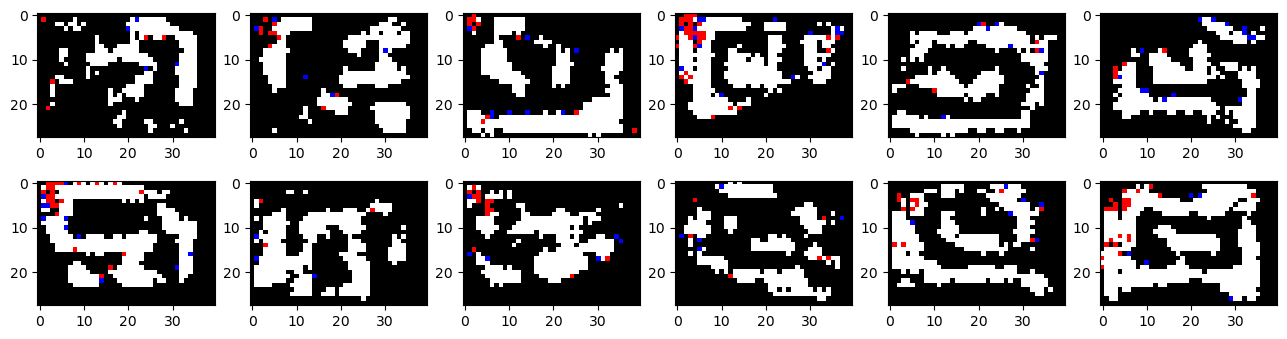

[801/200]: loss_d: 0.044, loss_g: 4.292
[802/200]: loss_d: 0.043, loss_g: 4.436
[803/200]: loss_d: 0.035, loss_g: 4.122
[804/200]: loss_d: 0.031, loss_g: 4.254
[805/200]: loss_d: 0.030, loss_g: 4.359
[806/200]: loss_d: 0.035, loss_g: 4.237
[807/200]: loss_d: 0.034, loss_g: 4.525
[808/200]: loss_d: 0.027, loss_g: 4.511
[809/200]: loss_d: 0.037, loss_g: 4.149
[810/200]: loss_d: 0.040, loss_g: 4.195
[811/200]: loss_d: 0.034, loss_g: 4.271
[812/200]: loss_d: 0.037, loss_g: 4.137
[813/200]: loss_d: 0.032, loss_g: 4.228
[814/200]: loss_d: 0.032, loss_g: 4.346
[815/200]: loss_d: 0.034, loss_g: 4.327
[816/200]: loss_d: 0.053, loss_g: 4.213
[817/200]: loss_d: 0.040, loss_g: 4.383
[818/200]: loss_d: 0.036, loss_g: 4.033
[819/200]: loss_d: 0.034, loss_g: 4.255
[820/200]: loss_d: 0.040, loss_g: 4.193
[821/200]: loss_d: 0.032, loss_g: 4.399
[822/200]: loss_d: 0.035, loss_g: 4.195
[823/200]: loss_d: 0.032, loss_g: 4.269
[824/200]: loss_d: 0.031, loss_g: 4.173
[825/200]: loss_d: 0.035, loss_g: 4.312


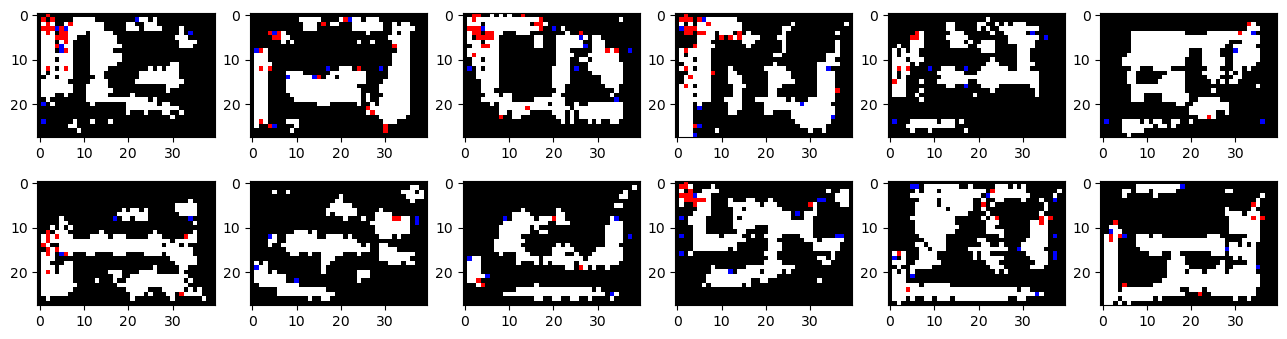

[901/200]: loss_d: 0.032, loss_g: 4.456
[902/200]: loss_d: 0.029, loss_g: 4.521
[903/200]: loss_d: 0.026, loss_g: 4.456
[904/200]: loss_d: 0.031, loss_g: 4.264
[905/200]: loss_d: 0.026, loss_g: 4.535
[906/200]: loss_d: 0.024, loss_g: 4.577
[907/200]: loss_d: 0.031, loss_g: 4.525
[908/200]: loss_d: 0.022, loss_g: 4.776
[909/200]: loss_d: 0.026, loss_g: 4.472
[910/200]: loss_d: 0.037, loss_g: 4.404
[911/200]: loss_d: 0.032, loss_g: 4.281
[912/200]: loss_d: 0.025, loss_g: 4.790
[913/200]: loss_d: 0.022, loss_g: 4.736
[914/200]: loss_d: 0.026, loss_g: 4.740
[915/200]: loss_d: 0.020, loss_g: 4.883
[916/200]: loss_d: 0.031, loss_g: 4.458
[917/200]: loss_d: 0.027, loss_g: 4.492
[918/200]: loss_d: 0.025, loss_g: 4.546
[919/200]: loss_d: 0.025, loss_g: 4.531
[920/200]: loss_d: 0.024, loss_g: 4.704
[921/200]: loss_d: 0.027, loss_g: 4.423
[922/200]: loss_d: 0.027, loss_g: 4.544
[923/200]: loss_d: 0.024, loss_g: 4.593
[924/200]: loss_d: 0.028, loss_g: 4.352
[925/200]: loss_d: 0.025, loss_g: 4.614


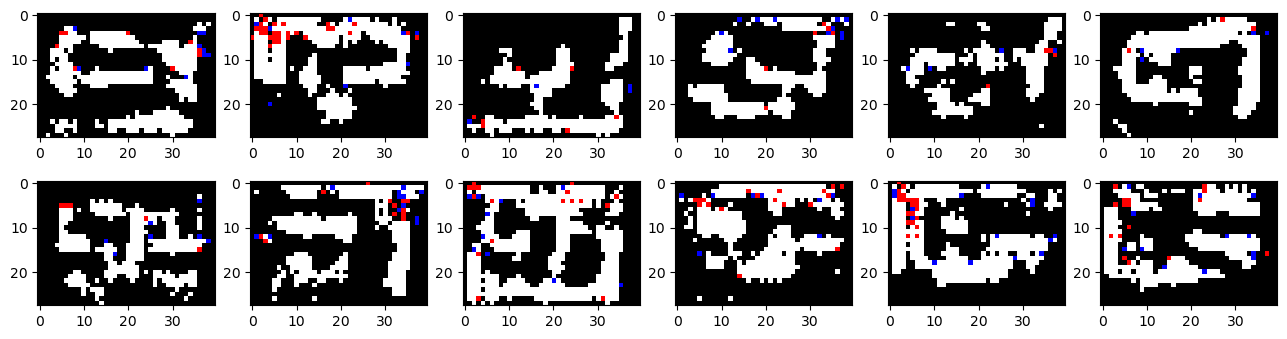

[1001/200]: loss_d: 0.027, loss_g: 4.678
[1002/200]: loss_d: 0.024, loss_g: 4.951
[1003/200]: loss_d: 0.022, loss_g: 4.809
[1004/200]: loss_d: 0.029, loss_g: 4.398
[1005/200]: loss_d: 0.021, loss_g: 4.827
[1006/200]: loss_d: 0.024, loss_g: 4.597
[1007/200]: loss_d: 0.025, loss_g: 4.715
[1008/200]: loss_d: 0.018, loss_g: 5.035
[1009/200]: loss_d: 0.015, loss_g: 4.997
[1010/200]: loss_d: 0.027, loss_g: 4.545
[1011/200]: loss_d: 0.019, loss_g: 4.960
[1012/200]: loss_d: 0.021, loss_g: 4.746
[1013/200]: loss_d: 0.018, loss_g: 4.847
[1014/200]: loss_d: 0.022, loss_g: 4.820
[1015/200]: loss_d: 0.018, loss_g: 5.030
[1016/200]: loss_d: 0.023, loss_g: 4.615
[1017/200]: loss_d: 0.018, loss_g: 4.813
[1018/200]: loss_d: 0.017, loss_g: 4.887
[1019/200]: loss_d: 0.018, loss_g: 4.828
[1020/200]: loss_d: 0.025, loss_g: 4.714
[1021/200]: loss_d: 0.027, loss_g: 4.703
[1022/200]: loss_d: 0.033, loss_g: 4.699
[1023/200]: loss_d: 0.023, loss_g: 4.872
[1024/200]: loss_d: 0.018, loss_g: 4.850
[1025/200]: loss

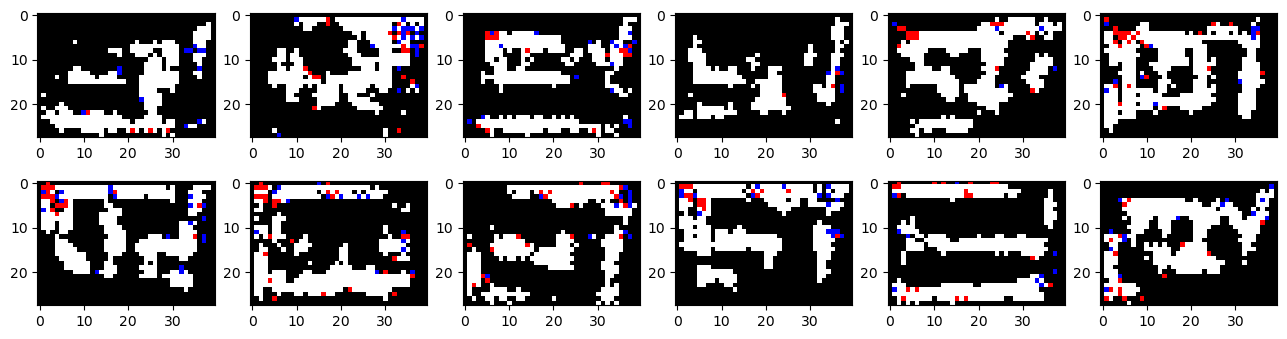

[1101/200]: loss_d: 0.020, loss_g: 4.796
[1102/200]: loss_d: 0.016, loss_g: 5.180
[1103/200]: loss_d: 0.020, loss_g: 4.799
[1104/200]: loss_d: 0.012, loss_g: 5.465
[1105/200]: loss_d: 0.016, loss_g: 4.873
[1106/200]: loss_d: 0.015, loss_g: 5.114
[1107/200]: loss_d: 0.014, loss_g: 5.239
[1108/200]: loss_d: 0.016, loss_g: 4.992
[1109/200]: loss_d: 0.016, loss_g: 4.954
[1110/200]: loss_d: 0.018, loss_g: 4.912
[1111/200]: loss_d: 0.016, loss_g: 5.088
[1112/200]: loss_d: 0.018, loss_g: 4.839
[1113/200]: loss_d: 0.014, loss_g: 5.234
[1114/200]: loss_d: 0.015, loss_g: 5.015
[1115/200]: loss_d: 0.023, loss_g: 4.719
[1116/200]: loss_d: 0.019, loss_g: 5.027
[1117/200]: loss_d: 0.021, loss_g: 4.679
[1118/200]: loss_d: 0.017, loss_g: 5.085
[1119/200]: loss_d: 0.016, loss_g: 5.121
[1120/200]: loss_d: 0.014, loss_g: 5.150
[1121/200]: loss_d: 0.021, loss_g: 4.579
[1122/200]: loss_d: 0.013, loss_g: 5.395
[1123/200]: loss_d: 0.017, loss_g: 4.999
[1124/200]: loss_d: 0.022, loss_g: 4.864
[1125/200]: loss

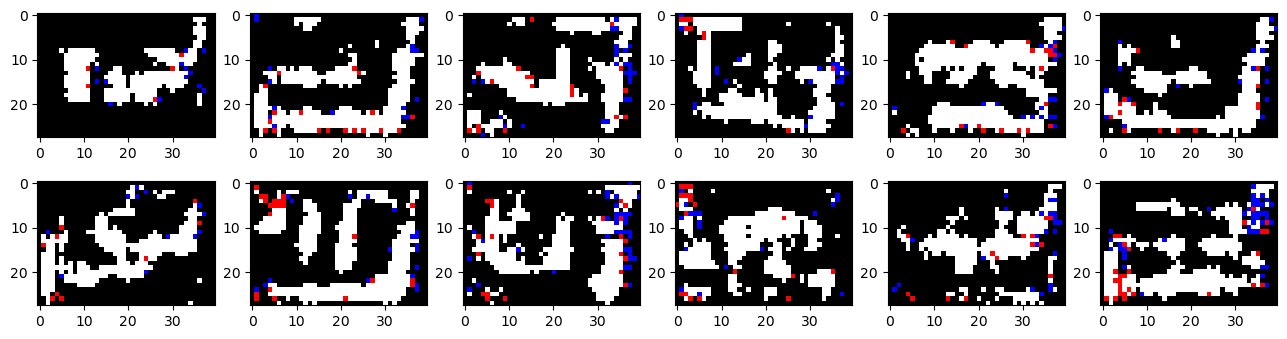

[1201/200]: loss_d: 0.017, loss_g: 4.985
[1202/200]: loss_d: 0.013, loss_g: 5.150
[1203/200]: loss_d: 0.013, loss_g: 5.074
[1204/200]: loss_d: 0.018, loss_g: 4.923
[1205/200]: loss_d: 0.019, loss_g: 4.974
[1206/200]: loss_d: 0.012, loss_g: 5.707
[1207/200]: loss_d: 0.015, loss_g: 5.286
[1208/200]: loss_d: 0.019, loss_g: 5.024
[1209/200]: loss_d: 0.013, loss_g: 5.378
[1210/200]: loss_d: 0.019, loss_g: 4.633
[1211/200]: loss_d: 0.015, loss_g: 5.129
[1212/200]: loss_d: 0.019, loss_g: 4.756
[1213/200]: loss_d: 0.014, loss_g: 5.287
[1214/200]: loss_d: 0.010, loss_g: 5.505
[1215/200]: loss_d: 0.027, loss_g: 4.980
[1216/200]: loss_d: 0.020, loss_g: 5.397
[1217/200]: loss_d: 0.016, loss_g: 5.365
[1218/200]: loss_d: 0.013, loss_g: 4.892
[1219/200]: loss_d: 0.014, loss_g: 5.076
[1220/200]: loss_d: 0.013, loss_g: 5.341
[1221/200]: loss_d: 0.016, loss_g: 5.031
[1222/200]: loss_d: 0.011, loss_g: 5.552
[1223/200]: loss_d: 0.010, loss_g: 5.394
[1224/200]: loss_d: 0.015, loss_g: 5.025
[1225/200]: loss

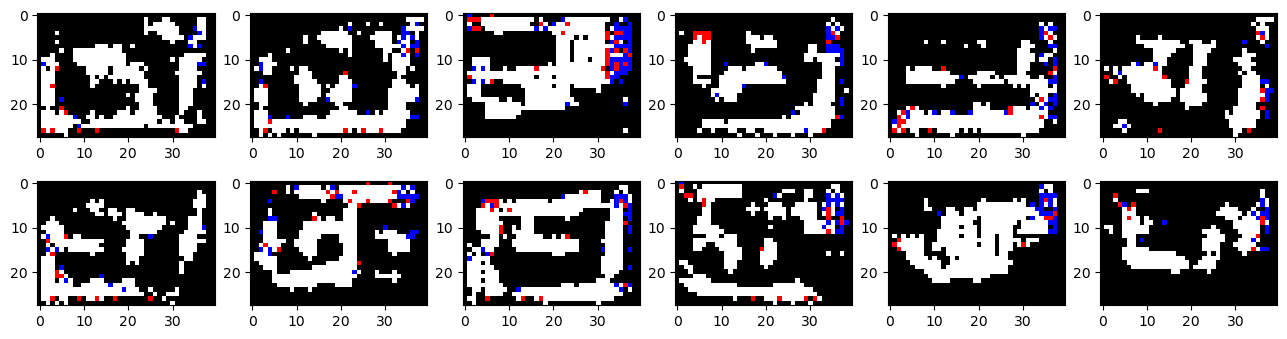

[1301/200]: loss_d: 0.010, loss_g: 5.495
[1302/200]: loss_d: 0.011, loss_g: 5.231
[1303/200]: loss_d: 0.011, loss_g: 5.263
[1304/200]: loss_d: 0.011, loss_g: 5.276
[1305/200]: loss_d: 0.015, loss_g: 5.132
[1306/200]: loss_d: 0.012, loss_g: 5.336
[1307/200]: loss_d: 0.011, loss_g: 5.460
[1308/200]: loss_d: 0.010, loss_g: 5.268
[1309/200]: loss_d: 0.010, loss_g: 5.397
[1310/200]: loss_d: 0.012, loss_g: 5.298
[1311/200]: loss_d: 0.011, loss_g: 5.584
[1312/200]: loss_d: 0.011, loss_g: 5.302
[1313/200]: loss_d: 0.010, loss_g: 5.379
[1314/200]: loss_d: 0.008, loss_g: 5.805
[1315/200]: loss_d: 0.011, loss_g: 5.213
[1316/200]: loss_d: 0.011, loss_g: 5.410
[1317/200]: loss_d: 0.012, loss_g: 5.298
[1318/200]: loss_d: 0.010, loss_g: 5.441
[1319/200]: loss_d: 0.012, loss_g: 5.313
[1320/200]: loss_d: 0.009, loss_g: 5.603
[1321/200]: loss_d: 0.012, loss_g: 5.221
[1322/200]: loss_d: 0.012, loss_g: 5.511
[1323/200]: loss_d: 0.011, loss_g: 5.706
[1324/200]: loss_d: 0.010, loss_g: 5.577
[1325/200]: loss

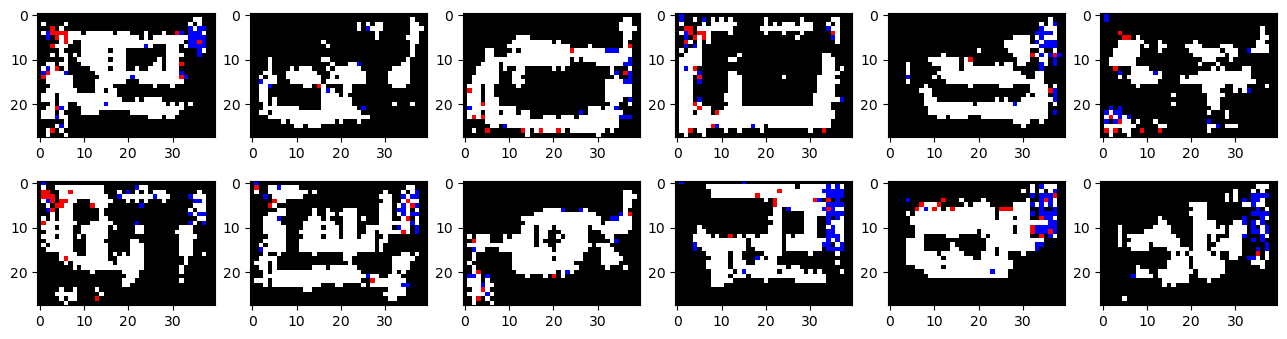

[1401/200]: loss_d: 0.008, loss_g: 5.721
[1402/200]: loss_d: 0.010, loss_g: 5.624
[1403/200]: loss_d: 0.011, loss_g: 5.776
[1404/200]: loss_d: 0.011, loss_g: 5.724
[1405/200]: loss_d: 0.009, loss_g: 5.679
[1406/200]: loss_d: 0.007, loss_g: 5.952
[1407/200]: loss_d: 0.010, loss_g: 5.398
[1408/200]: loss_d: 0.009, loss_g: 5.797
[1409/200]: loss_d: 0.009, loss_g: 5.577
[1410/200]: loss_d: 0.011, loss_g: 5.445
[1411/200]: loss_d: 0.009, loss_g: 5.602
[1412/200]: loss_d: 0.007, loss_g: 5.923
[1413/200]: loss_d: 0.008, loss_g: 5.697
[1414/200]: loss_d: 0.011, loss_g: 5.499
[1415/200]: loss_d: 0.008, loss_g: 5.887
[1416/200]: loss_d: 0.008, loss_g: 5.689
[1417/200]: loss_d: 0.009, loss_g: 5.594
[1418/200]: loss_d: 0.009, loss_g: 5.453
[1419/200]: loss_d: 0.008, loss_g: 5.711
[1420/200]: loss_d: 0.009, loss_g: 5.462
[1421/200]: loss_d: 0.010, loss_g: 5.620
[1422/200]: loss_d: 0.009, loss_g: 5.504
[1423/200]: loss_d: 0.010, loss_g: 5.514
[1424/200]: loss_d: 0.011, loss_g: 5.335
[1425/200]: loss

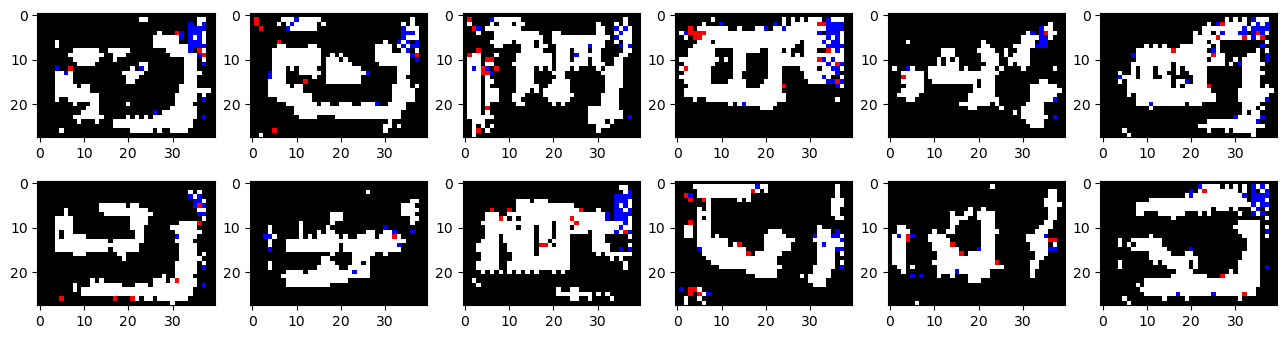

[1501/200]: loss_d: 0.008, loss_g: 5.784
[1502/200]: loss_d: 0.006, loss_g: 6.125
[1503/200]: loss_d: 0.010, loss_g: 5.702
[1504/200]: loss_d: 0.011, loss_g: 5.707
[1505/200]: loss_d: 0.012, loss_g: 5.249
[1506/200]: loss_d: 0.009, loss_g: 5.642
[1507/200]: loss_d: 0.012, loss_g: 5.607
[1508/200]: loss_d: 0.010, loss_g: 5.752
[1509/200]: loss_d: 0.009, loss_g: 5.596
[1510/200]: loss_d: 0.007, loss_g: 5.981
[1511/200]: loss_d: 0.011, loss_g: 5.391
[1512/200]: loss_d: 0.009, loss_g: 5.672
[1513/200]: loss_d: 0.007, loss_g: 6.079
[1514/200]: loss_d: 0.006, loss_g: 5.745
[1515/200]: loss_d: 0.007, loss_g: 5.945
[1516/200]: loss_d: 0.007, loss_g: 5.816
[1517/200]: loss_d: 0.009, loss_g: 5.885
[1518/200]: loss_d: 0.011, loss_g: 5.557
[1519/200]: loss_d: 0.007, loss_g: 5.923
[1520/200]: loss_d: 0.008, loss_g: 5.571
[1521/200]: loss_d: 0.007, loss_g: 5.812
[1522/200]: loss_d: 0.011, loss_g: 5.587
[1523/200]: loss_d: 0.008, loss_g: 6.301
[1524/200]: loss_d: 0.009, loss_g: 5.695
[1525/200]: loss

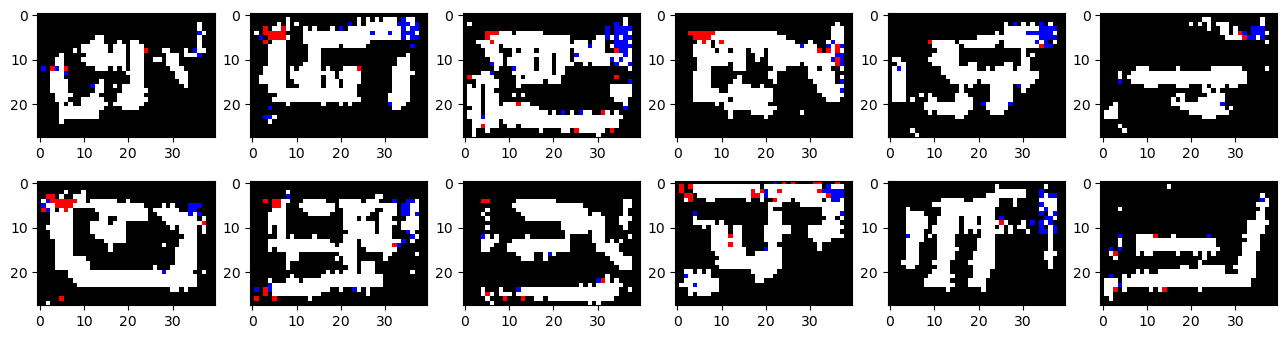

[1601/200]: loss_d: 0.005, loss_g: 6.512
[1602/200]: loss_d: 0.012, loss_g: 5.846
[1603/200]: loss_d: 0.009, loss_g: 5.723
[1604/200]: loss_d: 0.007, loss_g: 6.343
[1605/200]: loss_d: 0.007, loss_g: 6.009
[1606/200]: loss_d: 0.006, loss_g: 6.467
[1607/200]: loss_d: 0.005, loss_g: 6.280
[1608/200]: loss_d: 0.008, loss_g: 5.789
[1609/200]: loss_d: 0.006, loss_g: 6.482
[1610/200]: loss_d: 0.006, loss_g: 5.851
[1611/200]: loss_d: 0.007, loss_g: 5.787
[1612/200]: loss_d: 0.006, loss_g: 6.191
[1613/200]: loss_d: 0.005, loss_g: 6.127
[1614/200]: loss_d: 0.006, loss_g: 5.984
[1615/200]: loss_d: 0.005, loss_g: 6.289
[1616/200]: loss_d: 0.006, loss_g: 6.142
[1617/200]: loss_d: 0.007, loss_g: 5.945
[1618/200]: loss_d: 0.007, loss_g: 5.877
[1619/200]: loss_d: 0.006, loss_g: 6.188
[1620/200]: loss_d: 0.007, loss_g: 5.957
[1621/200]: loss_d: 0.007, loss_g: 6.064
[1622/200]: loss_d: 0.008, loss_g: 5.940
[1623/200]: loss_d: 0.007, loss_g: 6.134
[1624/200]: loss_d: 0.007, loss_g: 5.868
[1625/200]: loss

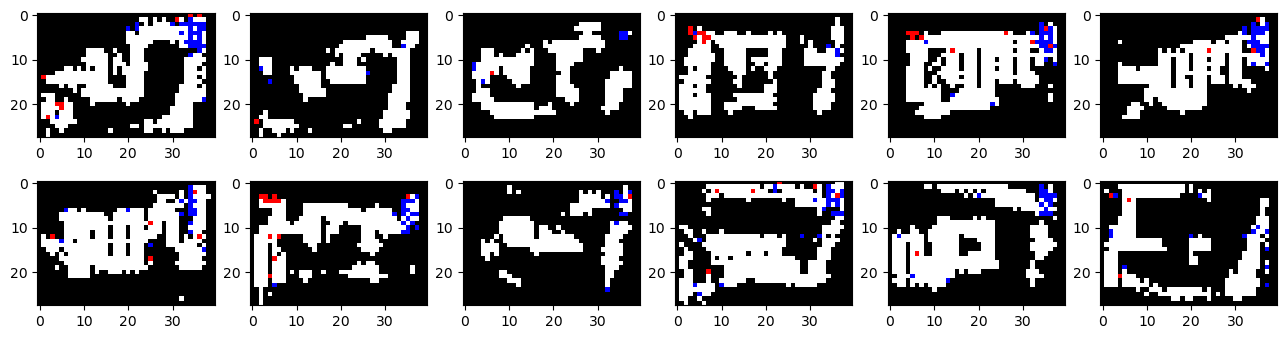

[1701/200]: loss_d: 0.005, loss_g: 6.393
[1702/200]: loss_d: 0.007, loss_g: 5.823
[1703/200]: loss_d: 0.005, loss_g: 6.488
[1704/200]: loss_d: 0.004, loss_g: 6.441
[1705/200]: loss_d: 0.006, loss_g: 6.018
[1706/200]: loss_d: 0.007, loss_g: 6.066
[1707/200]: loss_d: 0.005, loss_g: 6.395
[1708/200]: loss_d: 0.007, loss_g: 5.883
[1709/200]: loss_d: 0.006, loss_g: 6.363
[1710/200]: loss_d: 0.007, loss_g: 5.800
[1711/200]: loss_d: 0.007, loss_g: 6.077
[1712/200]: loss_d: 0.006, loss_g: 6.231
[1713/200]: loss_d: 0.005, loss_g: 6.201
[1714/200]: loss_d: 0.005, loss_g: 5.979
[1715/200]: loss_d: 0.007, loss_g: 5.959
[1716/200]: loss_d: 0.005, loss_g: 6.302
[1717/200]: loss_d: 0.005, loss_g: 6.315
[1718/200]: loss_d: 0.006, loss_g: 6.049
[1719/200]: loss_d: 0.009, loss_g: 6.123
[1720/200]: loss_d: 0.011, loss_g: 5.762
[1721/200]: loss_d: 0.008, loss_g: 5.784
[1722/200]: loss_d: 0.009, loss_g: 5.642
[1723/200]: loss_d: 0.005, loss_g: 6.627
[1724/200]: loss_d: 0.005, loss_g: 5.985
[1725/200]: loss

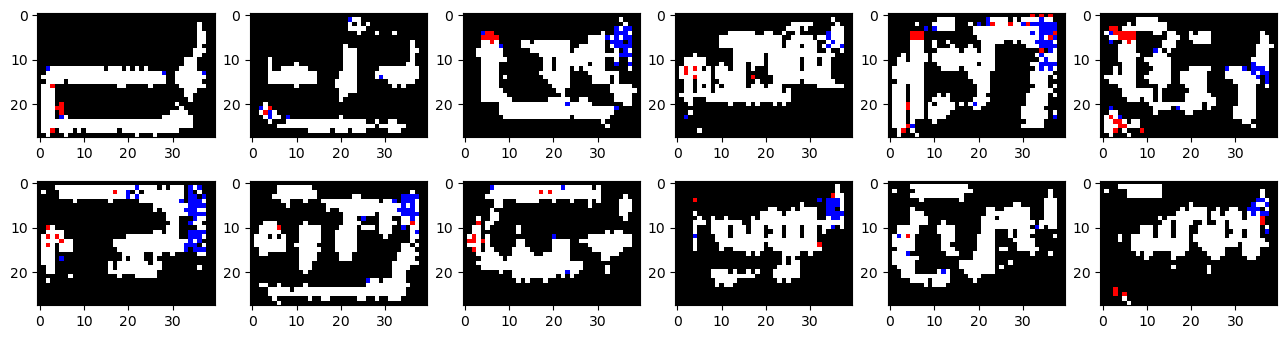

[1801/200]: loss_d: 0.007, loss_g: 5.656
[1802/200]: loss_d: 0.005, loss_g: 6.332
[1803/200]: loss_d: 0.007, loss_g: 6.180
[1804/200]: loss_d: 0.004, loss_g: 6.609
[1805/200]: loss_d: 0.004, loss_g: 6.767
[1806/200]: loss_d: 0.007, loss_g: 6.100
[1807/200]: loss_d: 0.009, loss_g: 6.530
[1808/200]: loss_d: 0.006, loss_g: 6.155
[1809/200]: loss_d: 0.004, loss_g: 6.481
[1810/200]: loss_d: 0.007, loss_g: 5.918
[1811/200]: loss_d: 0.006, loss_g: 6.438
[1812/200]: loss_d: 0.006, loss_g: 6.328
[1813/200]: loss_d: 0.004, loss_g: 6.512
[1814/200]: loss_d: 0.004, loss_g: 6.344
[1815/200]: loss_d: 0.004, loss_g: 6.489
[1816/200]: loss_d: 0.006, loss_g: 6.157
[1817/200]: loss_d: 0.004, loss_g: 7.245
[1818/200]: loss_d: 0.005, loss_g: 6.299
[1819/200]: loss_d: 0.004, loss_g: 6.519
[1820/200]: loss_d: 0.004, loss_g: 6.599
[1821/200]: loss_d: 0.006, loss_g: 6.223
[1822/200]: loss_d: 0.006, loss_g: 6.041
[1823/200]: loss_d: 0.004, loss_g: 6.785
[1824/200]: loss_d: 0.005, loss_g: 6.034
[1825/200]: loss

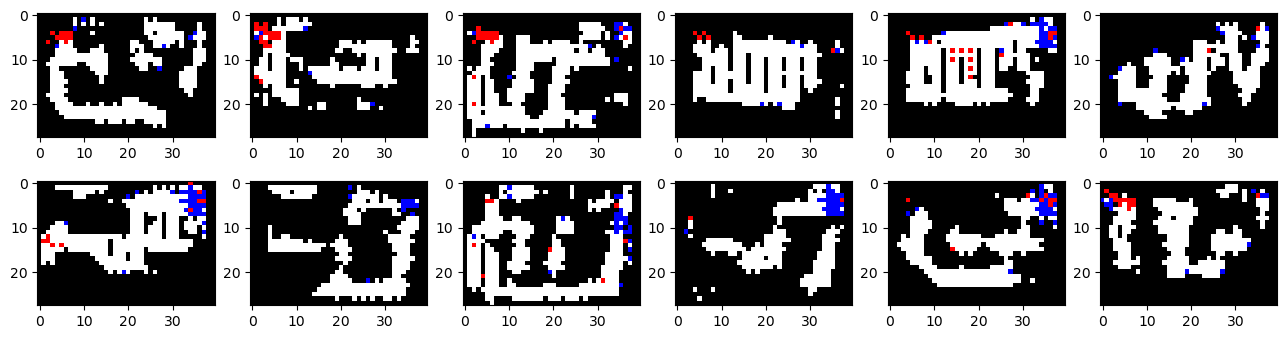

[1901/200]: loss_d: 0.006, loss_g: 6.474
[1902/200]: loss_d: 0.006, loss_g: 5.723
[1903/200]: loss_d: 0.004, loss_g: 6.305
[1904/200]: loss_d: 0.003, loss_g: 6.667
[1905/200]: loss_d: 0.005, loss_g: 6.175
[1906/200]: loss_d: 0.004, loss_g: 6.457
[1907/200]: loss_d: 0.003, loss_g: 7.134
[1908/200]: loss_d: 0.005, loss_g: 6.044
[1909/200]: loss_d: 0.003, loss_g: 6.938
[1910/200]: loss_d: 0.004, loss_g: 6.597
[1911/200]: loss_d: 0.005, loss_g: 6.454
[1912/200]: loss_d: 0.005, loss_g: 6.884
[1913/200]: loss_d: 0.004, loss_g: 6.542
[1914/200]: loss_d: 0.005, loss_g: 6.263
[1915/200]: loss_d: 0.003, loss_g: 6.772
[1916/200]: loss_d: 0.008, loss_g: 6.154
[1917/200]: loss_d: 0.005, loss_g: 6.795
[1918/200]: loss_d: 0.007, loss_g: 6.456
[1919/200]: loss_d: 0.006, loss_g: 6.145
[1920/200]: loss_d: 0.004, loss_g: 6.325
[1921/200]: loss_d: 0.004, loss_g: 6.374
[1922/200]: loss_d: 0.005, loss_g: 6.258
[1923/200]: loss_d: 0.006, loss_g: 6.162
[1924/200]: loss_d: 0.005, loss_g: 6.013
[1925/200]: loss

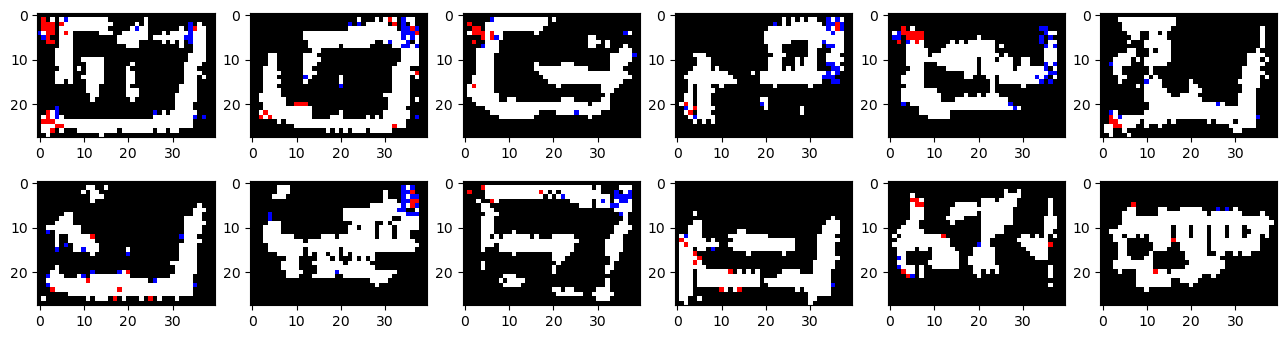

[2001/200]: loss_d: 0.003, loss_g: 6.532
[2002/200]: loss_d: 0.003, loss_g: 6.463
[2003/200]: loss_d: 0.006, loss_g: 6.733
[2004/200]: loss_d: 0.004, loss_g: 6.850
[2005/200]: loss_d: 0.005, loss_g: 7.071
[2006/200]: loss_d: 0.005, loss_g: 6.188
[2007/200]: loss_d: 0.005, loss_g: 6.359
[2008/200]: loss_d: 0.003, loss_g: 7.240
[2009/200]: loss_d: 0.003, loss_g: 6.821
[2010/200]: loss_d: 0.004, loss_g: 6.372
[2011/200]: loss_d: 0.003, loss_g: 7.027
[2012/200]: loss_d: 0.003, loss_g: 6.687
[2013/200]: loss_d: 0.003, loss_g: 6.660
[2014/200]: loss_d: 0.004, loss_g: 6.546
[2015/200]: loss_d: 0.004, loss_g: 6.777
[2016/200]: loss_d: 0.004, loss_g: 6.465
[2017/200]: loss_d: 0.005, loss_g: 6.536
[2018/200]: loss_d: 0.006, loss_g: 6.491
[2019/200]: loss_d: 0.006, loss_g: 6.148
[2020/200]: loss_d: 0.004, loss_g: 7.025
[2021/200]: loss_d: 0.003, loss_g: 6.328
[2022/200]: loss_d: 0.004, loss_g: 6.383
[2023/200]: loss_d: 0.005, loss_g: 6.660
[2024/200]: loss_d: 0.005, loss_g: 6.461
[2025/200]: loss

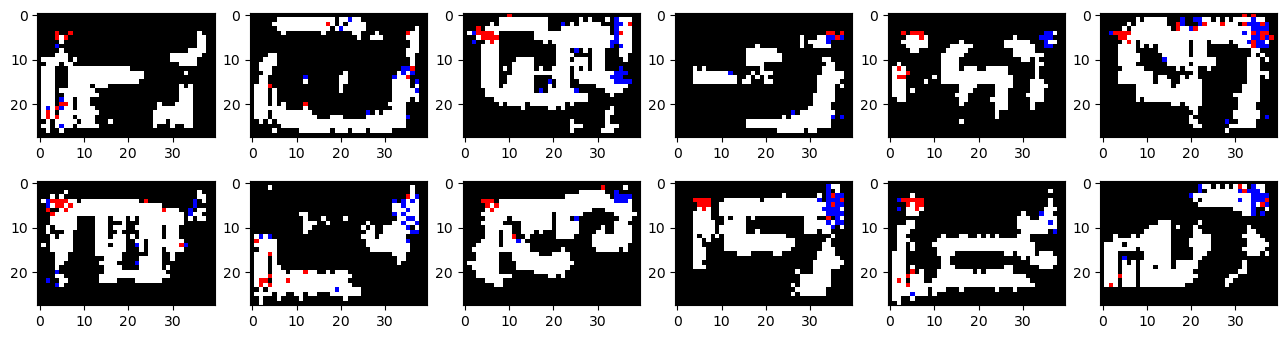

[2101/200]: loss_d: 0.003, loss_g: 6.663
[2102/200]: loss_d: 0.005, loss_g: 6.172
[2103/200]: loss_d: 0.005, loss_g: 6.312
[2104/200]: loss_d: 0.005, loss_g: 6.447
[2105/200]: loss_d: 0.003, loss_g: 6.786
[2106/200]: loss_d: 0.004, loss_g: 6.250
[2107/200]: loss_d: 0.004, loss_g: 6.459
[2108/200]: loss_d: 0.003, loss_g: 6.980
[2109/200]: loss_d: 0.005, loss_g: 6.592
[2110/200]: loss_d: 0.003, loss_g: 7.015
[2111/200]: loss_d: 0.005, loss_g: 6.430
[2112/200]: loss_d: 0.004, loss_g: 6.750
[2113/200]: loss_d: 0.003, loss_g: 6.708
[2114/200]: loss_d: 0.003, loss_g: 6.585
[2115/200]: loss_d: 0.002, loss_g: 7.487
[2116/200]: loss_d: 0.004, loss_g: 6.472
[2117/200]: loss_d: 0.005, loss_g: 6.679
[2118/200]: loss_d: 0.004, loss_g: 6.948
[2119/200]: loss_d: 0.003, loss_g: 6.740
[2120/200]: loss_d: 0.004, loss_g: 6.480
[2121/200]: loss_d: 0.002, loss_g: 7.122
[2122/200]: loss_d: 0.003, loss_g: 6.474
[2123/200]: loss_d: 0.007, loss_g: 6.439
[2124/200]: loss_d: 0.005, loss_g: 6.962
[2125/200]: loss

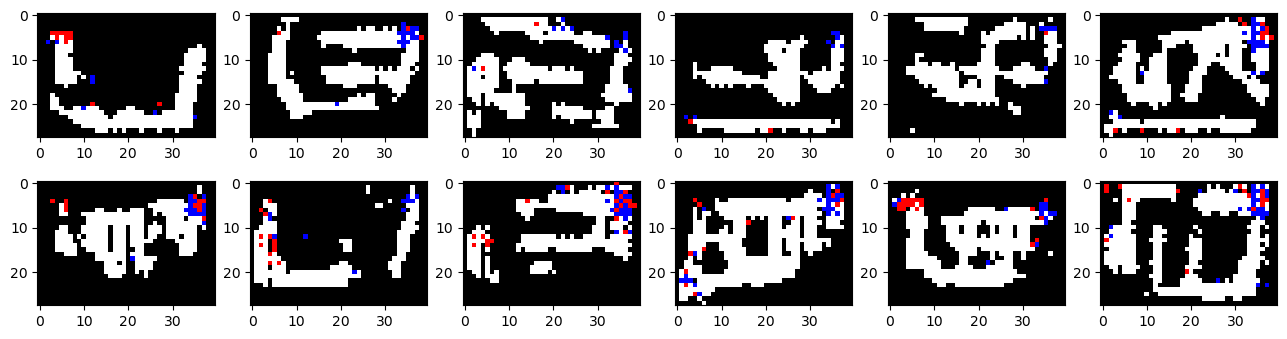

[2201/200]: loss_d: 0.003, loss_g: 6.815
[2202/200]: loss_d: 0.004, loss_g: 6.595
[2203/200]: loss_d: 0.002, loss_g: 7.334
[2204/200]: loss_d: 0.005, loss_g: 6.529
[2205/200]: loss_d: 0.003, loss_g: 7.064
[2206/200]: loss_d: 0.002, loss_g: 7.213
[2207/200]: loss_d: 0.002, loss_g: 7.138
[2208/200]: loss_d: 0.003, loss_g: 6.539
[2209/200]: loss_d: 0.005, loss_g: 6.496
[2210/200]: loss_d: 0.004, loss_g: 6.686
[2211/200]: loss_d: 0.003, loss_g: 6.733
[2212/200]: loss_d: 0.002, loss_g: 7.199
[2213/200]: loss_d: 0.003, loss_g: 6.446
[2214/200]: loss_d: 0.002, loss_g: 7.464
[2215/200]: loss_d: 0.003, loss_g: 6.925
[2216/200]: loss_d: 0.002, loss_g: 7.555
[2217/200]: loss_d: 0.003, loss_g: 6.844
[2218/200]: loss_d: 0.005, loss_g: 6.955
[2219/200]: loss_d: 0.004, loss_g: 6.508
[2220/200]: loss_d: 0.005, loss_g: 6.507
[2221/200]: loss_d: 0.003, loss_g: 6.646
[2222/200]: loss_d: 0.003, loss_g: 6.707
[2223/200]: loss_d: 0.004, loss_g: 6.763
[2224/200]: loss_d: 0.003, loss_g: 6.887
[2225/200]: loss

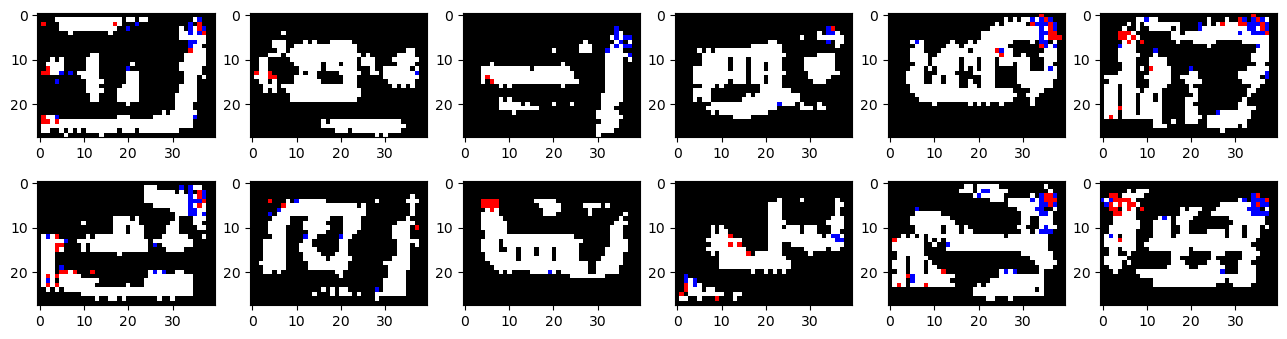

[2301/200]: loss_d: 0.003, loss_g: 7.128
[2302/200]: loss_d: 0.003, loss_g: 7.060
[2303/200]: loss_d: 0.004, loss_g: 6.641
[2304/200]: loss_d: 0.004, loss_g: 6.834
[2305/200]: loss_d: 0.003, loss_g: 6.904
[2306/200]: loss_d: 0.003, loss_g: 6.770
[2307/200]: loss_d: 0.003, loss_g: 6.677
[2308/200]: loss_d: 0.004, loss_g: 6.559
[2309/200]: loss_d: 0.003, loss_g: 6.857
[2310/200]: loss_d: 0.003, loss_g: 6.745
[2311/200]: loss_d: 0.003, loss_g: 6.789
[2312/200]: loss_d: 0.003, loss_g: 7.131
[2313/200]: loss_d: 0.003, loss_g: 6.786
[2314/200]: loss_d: 0.003, loss_g: 6.977
[2315/200]: loss_d: 0.002, loss_g: 7.005
[2316/200]: loss_d: 0.002, loss_g: 7.223
[2317/200]: loss_d: 0.004, loss_g: 6.706
[2318/200]: loss_d: 0.003, loss_g: 7.345
[2319/200]: loss_d: 0.004, loss_g: 6.545
[2320/200]: loss_d: 0.003, loss_g: 6.573
[2321/200]: loss_d: 0.003, loss_g: 6.539
[2322/200]: loss_d: 0.002, loss_g: 7.395
[2323/200]: loss_d: 0.002, loss_g: 7.060
[2324/200]: loss_d: 0.005, loss_g: 6.757
[2325/200]: loss

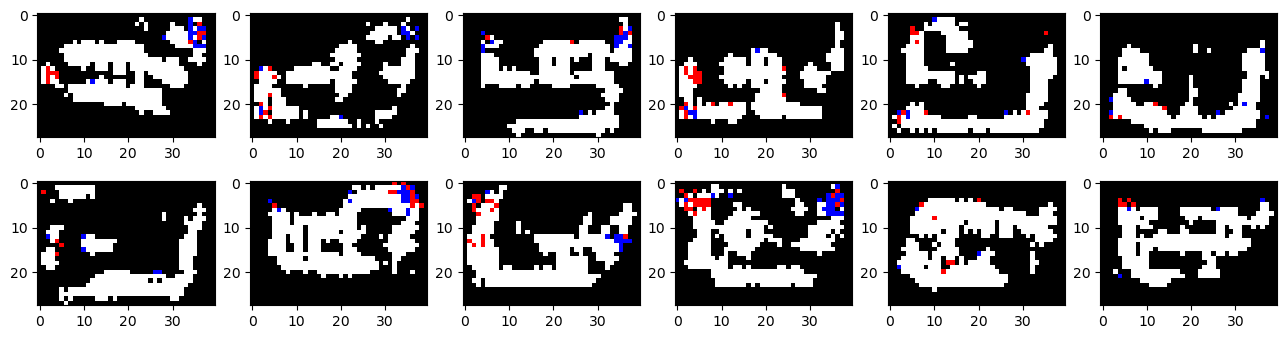

[2401/200]: loss_d: 0.002, loss_g: 7.100
[2402/200]: loss_d: 0.002, loss_g: 7.187
[2403/200]: loss_d: 0.002, loss_g: 7.271
[2404/200]: loss_d: 0.002, loss_g: 7.115
[2405/200]: loss_d: 0.003, loss_g: 7.181
[2406/200]: loss_d: 0.002, loss_g: 7.346
[2407/200]: loss_d: 0.002, loss_g: 7.538
[2408/200]: loss_d: 0.002, loss_g: 7.150
[2409/200]: loss_d: 0.005, loss_g: 7.221
[2410/200]: loss_d: 0.005, loss_g: 6.753
[2411/200]: loss_d: 0.003, loss_g: 6.325
[2412/200]: loss_d: 0.003, loss_g: 6.715
[2413/200]: loss_d: 0.002, loss_g: 7.610
[2414/200]: loss_d: 0.004, loss_g: 6.947
[2415/200]: loss_d: 0.003, loss_g: 6.932
[2416/200]: loss_d: 0.003, loss_g: 6.780
[2417/200]: loss_d: 0.002, loss_g: 7.280
[2418/200]: loss_d: 0.002, loss_g: 7.321
[2419/200]: loss_d: 0.004, loss_g: 7.012
[2420/200]: loss_d: 0.002, loss_g: 7.393
[2421/200]: loss_d: 0.002, loss_g: 7.637
[2422/200]: loss_d: 0.003, loss_g: 6.676
[2423/200]: loss_d: 0.002, loss_g: 7.408
[2424/200]: loss_d: 0.002, loss_g: 7.305
[2425/200]: loss

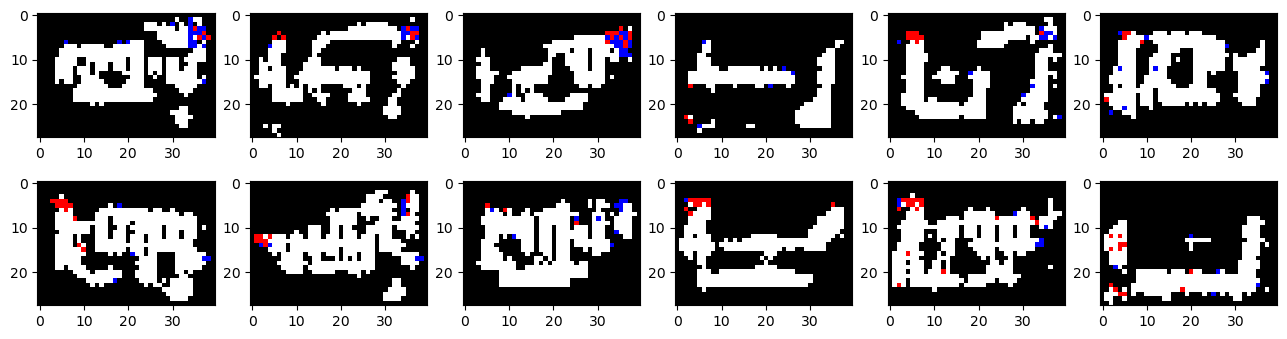

[2501/200]: loss_d: 0.025, loss_g: 4.921
[2502/200]: loss_d: 0.019, loss_g: 5.043
[2503/200]: loss_d: 0.026, loss_g: 4.471
[2504/200]: loss_d: 0.041, loss_g: 4.217
[2505/200]: loss_d: 0.017, loss_g: 5.636
[2506/200]: loss_d: 0.023, loss_g: 4.947
[2507/200]: loss_d: 0.024, loss_g: 5.002
[2508/200]: loss_d: 0.020, loss_g: 4.889
[2509/200]: loss_d: 0.025, loss_g: 4.738
[2510/200]: loss_d: 0.017, loss_g: 5.095
[2511/200]: loss_d: 0.022, loss_g: 4.742
[2512/200]: loss_d: 0.023, loss_g: 4.818
[2513/200]: loss_d: 0.017, loss_g: 4.993
[2514/200]: loss_d: 0.017, loss_g: 5.138
[2515/200]: loss_d: 0.017, loss_g: 5.109
[2516/200]: loss_d: 0.017, loss_g: 5.064
[2517/200]: loss_d: 0.014, loss_g: 5.138
[2518/200]: loss_d: 0.028, loss_g: 4.635
[2519/200]: loss_d: 0.018, loss_g: 5.021
[2520/200]: loss_d: 0.021, loss_g: 4.807
[2521/200]: loss_d: 0.018, loss_g: 5.255
[2522/200]: loss_d: 0.014, loss_g: 5.598
[2523/200]: loss_d: 0.027, loss_g: 4.634
[2524/200]: loss_d: 0.014, loss_g: 5.614
[2525/200]: loss

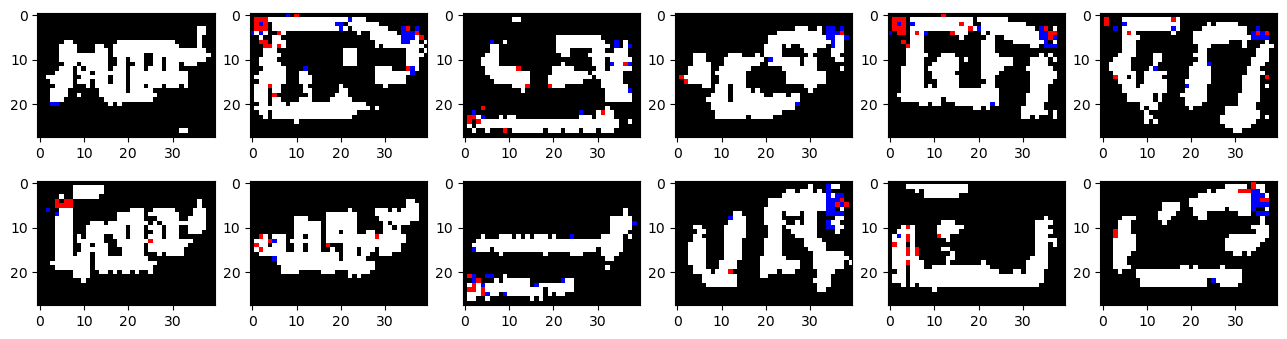

[2601/200]: loss_d: 0.007, loss_g: 6.380
[2602/200]: loss_d: 0.009, loss_g: 6.012
[2603/200]: loss_d: 0.011, loss_g: 5.642
[2604/200]: loss_d: 0.008, loss_g: 6.116
[2605/200]: loss_d: 0.009, loss_g: 5.578
[2606/200]: loss_d: 0.008, loss_g: 5.711
[2607/200]: loss_d: 0.006, loss_g: 6.351
[2608/200]: loss_d: 0.006, loss_g: 6.274
[2609/200]: loss_d: 0.009, loss_g: 5.923
[2610/200]: loss_d: 0.006, loss_g: 6.103
[2611/200]: loss_d: 0.007, loss_g: 6.086
[2612/200]: loss_d: 0.006, loss_g: 6.346
[2613/200]: loss_d: 0.008, loss_g: 5.906
[2614/200]: loss_d: 0.007, loss_g: 6.018
[2615/200]: loss_d: 0.008, loss_g: 5.716
[2616/200]: loss_d: 0.006, loss_g: 6.815
[2617/200]: loss_d: 0.010, loss_g: 5.513
[2618/200]: loss_d: 0.009, loss_g: 5.873
[2619/200]: loss_d: 0.008, loss_g: 5.700
[2620/200]: loss_d: 0.010, loss_g: 5.498
[2621/200]: loss_d: 0.008, loss_g: 5.908
[2622/200]: loss_d: 0.011, loss_g: 5.391
[2623/200]: loss_d: 0.006, loss_g: 6.858
[2624/200]: loss_d: 0.009, loss_g: 6.236
[2625/200]: loss

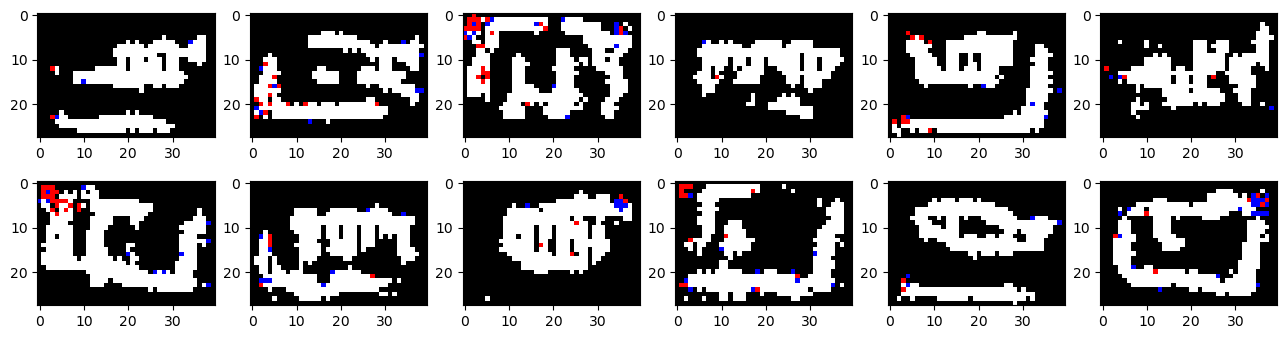

[2701/200]: loss_d: 0.004, loss_g: 7.200
[2702/200]: loss_d: 0.005, loss_g: 6.366
[2703/200]: loss_d: 0.004, loss_g: 6.554
[2704/200]: loss_d: 0.004, loss_g: 6.850
[2705/200]: loss_d: 0.004, loss_g: 6.371
[2706/200]: loss_d: 0.004, loss_g: 7.076
[2707/200]: loss_d: 0.005, loss_g: 6.083
[2708/200]: loss_d: 0.004, loss_g: 6.487
[2709/200]: loss_d: 0.006, loss_g: 5.719
[2710/200]: loss_d: 0.004, loss_g: 6.408
[2711/200]: loss_d: 0.012, loss_g: 5.306
[2712/200]: loss_d: 0.007, loss_g: 5.895
[2713/200]: loss_d: 0.005, loss_g: 6.238
[2714/200]: loss_d: 0.005, loss_g: 6.359
[2715/200]: loss_d: 0.006, loss_g: 6.324
[2716/200]: loss_d: 0.006, loss_g: 6.132
[2717/200]: loss_d: 0.006, loss_g: 6.106
[2718/200]: loss_d: 0.007, loss_g: 6.202
[2719/200]: loss_d: 0.007, loss_g: 5.844
[2720/200]: loss_d: 0.005, loss_g: 6.449
[2721/200]: loss_d: 0.005, loss_g: 6.412
[2722/200]: loss_d: 0.005, loss_g: 6.490
[2723/200]: loss_d: 0.007, loss_g: 5.966
[2724/200]: loss_d: 0.004, loss_g: 6.794
[2725/200]: loss

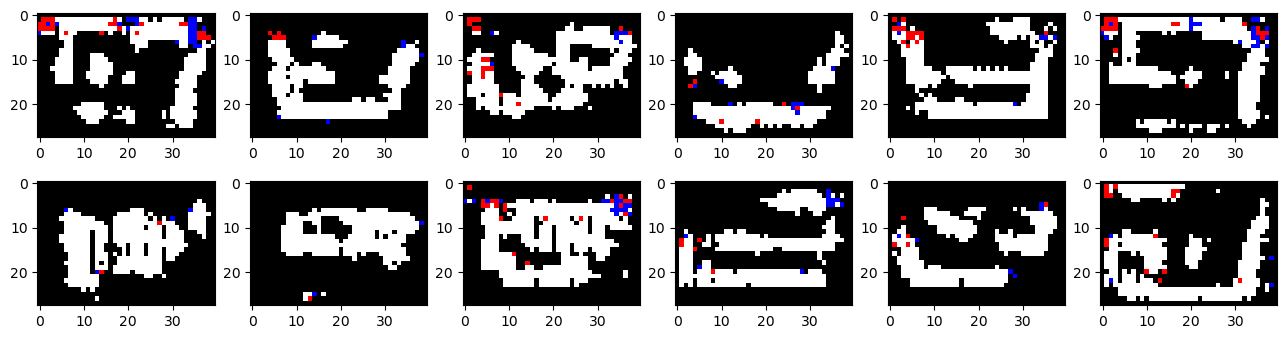

[2801/200]: loss_d: 0.009, loss_g: 5.907
[2802/200]: loss_d: 0.005, loss_g: 6.680
[2803/200]: loss_d: 0.005, loss_g: 6.592
[2804/200]: loss_d: 0.006, loss_g: 6.225
[2805/200]: loss_d: 0.005, loss_g: 6.407
[2806/200]: loss_d: 0.004, loss_g: 7.198
[2807/200]: loss_d: 0.004, loss_g: 6.445
[2808/200]: loss_d: 0.004, loss_g: 6.525
[2809/200]: loss_d: 0.005, loss_g: 6.159
[2810/200]: loss_d: 0.005, loss_g: 6.421
[2811/200]: loss_d: 0.005, loss_g: 6.286
[2812/200]: loss_d: 0.005, loss_g: 6.222
[2813/200]: loss_d: 0.005, loss_g: 6.410
[2814/200]: loss_d: 0.004, loss_g: 6.611
[2815/200]: loss_d: 0.004, loss_g: 6.471
[2816/200]: loss_d: 0.006, loss_g: 6.210
[2817/200]: loss_d: 0.004, loss_g: 6.572
[2818/200]: loss_d: 0.005, loss_g: 6.598
[2819/200]: loss_d: 0.005, loss_g: 6.228
[2820/200]: loss_d: 0.005, loss_g: 6.210
[2821/200]: loss_d: 0.003, loss_g: 6.737
[2822/200]: loss_d: 0.004, loss_g: 6.558
[2823/200]: loss_d: 0.005, loss_g: 5.849
[2824/200]: loss_d: 0.003, loss_g: 6.955
[2825/200]: loss

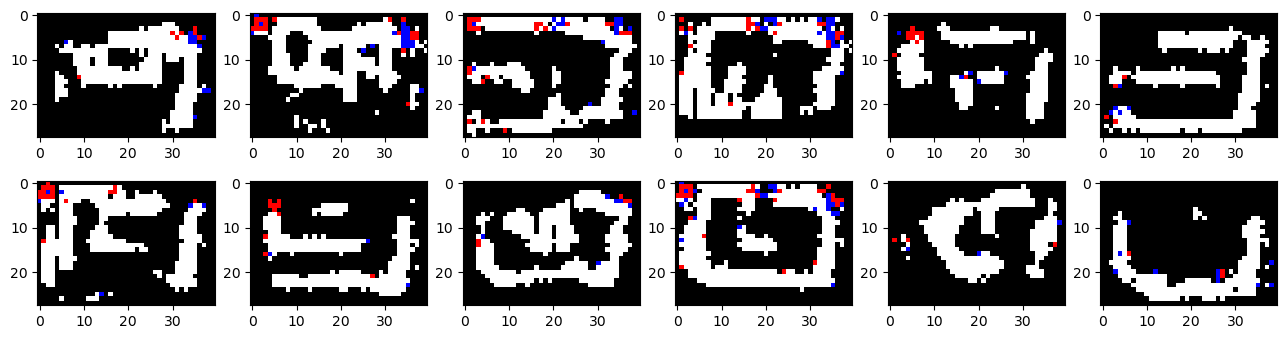

[2901/200]: loss_d: 0.004, loss_g: 6.889
[2902/200]: loss_d: 0.004, loss_g: 6.950
[2903/200]: loss_d: 0.006, loss_g: 5.921
[2904/200]: loss_d: 0.008, loss_g: 6.610
[2905/200]: loss_d: 0.003, loss_g: 7.592
[2906/200]: loss_d: 0.005, loss_g: 6.216
[2907/200]: loss_d: 0.008, loss_g: 5.928
[2908/200]: loss_d: 0.004, loss_g: 7.273
[2909/200]: loss_d: 0.004, loss_g: 7.096
[2910/200]: loss_d: 0.004, loss_g: 6.752
[2911/200]: loss_d: 0.004, loss_g: 6.414
[2912/200]: loss_d: 0.005, loss_g: 6.044
[2913/200]: loss_d: 0.004, loss_g: 6.711
[2914/200]: loss_d: 0.004, loss_g: 6.528
[2915/200]: loss_d: 0.005, loss_g: 6.563
[2916/200]: loss_d: 0.006, loss_g: 5.754
[2917/200]: loss_d: 0.005, loss_g: 6.805
[2918/200]: loss_d: 0.005, loss_g: 7.062
[2919/200]: loss_d: 0.004, loss_g: 6.761
[2920/200]: loss_d: 0.006, loss_g: 6.043
[2921/200]: loss_d: 0.004, loss_g: 6.952
[2922/200]: loss_d: 0.006, loss_g: 6.265
[2923/200]: loss_d: 0.003, loss_g: 6.962
[2924/200]: loss_d: 0.004, loss_g: 6.783
[2925/200]: loss

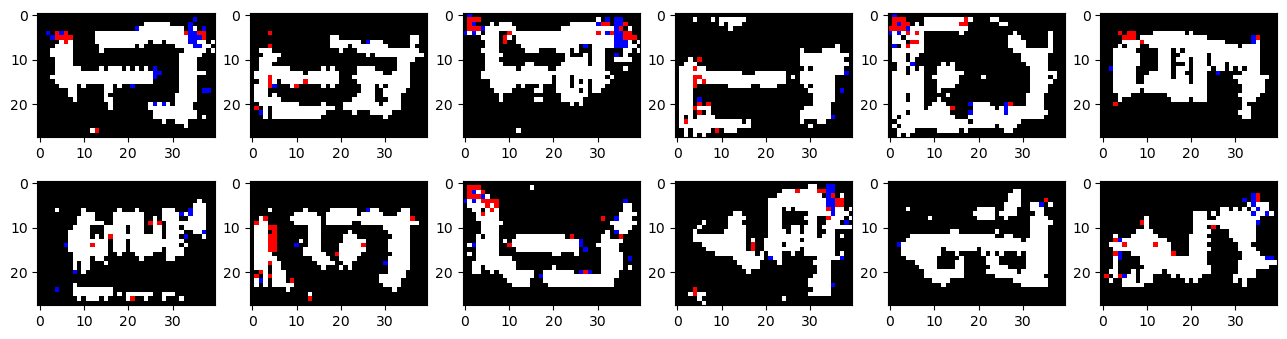

[3001/200]: loss_d: 0.003, loss_g: 6.738
[3002/200]: loss_d: 0.004, loss_g: 6.565
[3003/200]: loss_d: 0.003, loss_g: 6.649
[3004/200]: loss_d: 0.004, loss_g: 6.995
[3005/200]: loss_d: 0.004, loss_g: 6.707
[3006/200]: loss_d: 0.008, loss_g: 6.240
[3007/200]: loss_d: 0.003, loss_g: 6.960
[3008/200]: loss_d: 0.005, loss_g: 6.599
[3009/200]: loss_d: 0.005, loss_g: 6.915
[3010/200]: loss_d: 0.006, loss_g: 6.898
[3011/200]: loss_d: 0.003, loss_g: 7.444
[3012/200]: loss_d: 0.004, loss_g: 6.566
[3013/200]: loss_d: 0.004, loss_g: 6.547
[3014/200]: loss_d: 0.004, loss_g: 6.560
[3015/200]: loss_d: 0.004, loss_g: 6.500
[3016/200]: loss_d: 0.003, loss_g: 7.056
[3017/200]: loss_d: 0.004, loss_g: 6.453
[3018/200]: loss_d: 0.003, loss_g: 7.181
[3019/200]: loss_d: 0.003, loss_g: 7.015
[3020/200]: loss_d: 0.004, loss_g: 6.561
[3021/200]: loss_d: 0.005, loss_g: 6.255
[3022/200]: loss_d: 0.004, loss_g: 6.717
[3023/200]: loss_d: 0.003, loss_g: 7.060
[3024/200]: loss_d: 0.005, loss_g: 6.284
[3025/200]: loss

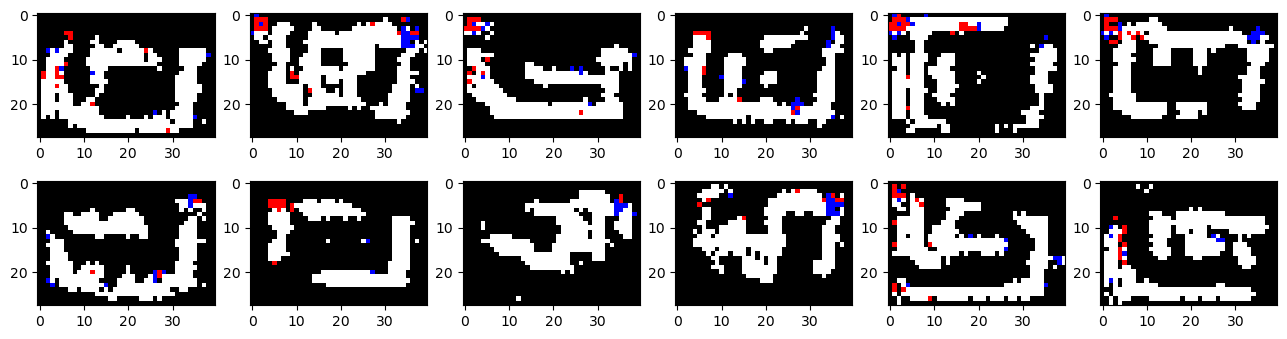

[3101/200]: loss_d: 0.005, loss_g: 6.517
[3102/200]: loss_d: 0.003, loss_g: 6.886
[3103/200]: loss_d: 0.003, loss_g: 7.215
[3104/200]: loss_d: 0.003, loss_g: 7.079
[3105/200]: loss_d: 0.003, loss_g: 6.636
[3106/200]: loss_d: 0.005, loss_g: 5.967
[3107/200]: loss_d: 0.006, loss_g: 6.459
[3108/200]: loss_d: 0.003, loss_g: 7.019
[3109/200]: loss_d: 0.005, loss_g: 6.343
[3110/200]: loss_d: 0.004, loss_g: 6.759
[3111/200]: loss_d: 0.004, loss_g: 6.545
[3112/200]: loss_d: 0.004, loss_g: 6.738
[3113/200]: loss_d: 0.003, loss_g: 6.912
[3114/200]: loss_d: 0.004, loss_g: 6.202
[3115/200]: loss_d: 0.003, loss_g: 7.376
[3116/200]: loss_d: 0.005, loss_g: 6.266
[3117/200]: loss_d: 0.003, loss_g: 6.883
[3118/200]: loss_d: 0.003, loss_g: 6.718
[3119/200]: loss_d: 0.002, loss_g: 7.526
[3120/200]: loss_d: 0.004, loss_g: 6.752
[3121/200]: loss_d: 0.005, loss_g: 6.298
[3122/200]: loss_d: 0.016, loss_g: 5.994
[3123/200]: loss_d: 0.007, loss_g: 6.201
[3124/200]: loss_d: 0.005, loss_g: 7.056
[3125/200]: loss

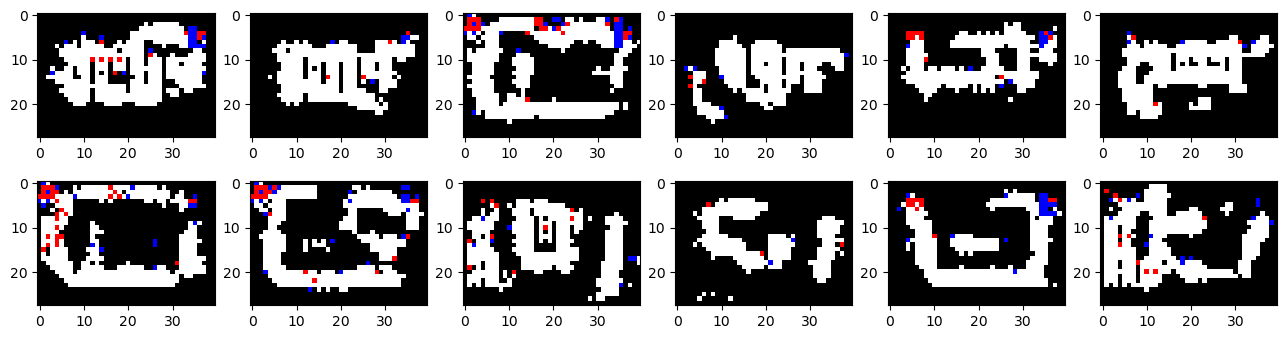

[3201/200]: loss_d: 0.004, loss_g: 6.463
[3202/200]: loss_d: 0.003, loss_g: 6.970
[3203/200]: loss_d: 0.003, loss_g: 7.135
[3204/200]: loss_d: 0.003, loss_g: 6.923
[3205/200]: loss_d: 0.004, loss_g: 6.417
[3206/200]: loss_d: 0.004, loss_g: 6.600
[3207/200]: loss_d: 0.003, loss_g: 6.927
[3208/200]: loss_d: 0.005, loss_g: 6.242
[3209/200]: loss_d: 0.003, loss_g: 7.424
[3210/200]: loss_d: 0.006, loss_g: 6.077
[3211/200]: loss_d: 0.004, loss_g: 6.591
[3212/200]: loss_d: 0.006, loss_g: 6.254
[3213/200]: loss_d: 0.002, loss_g: 7.571
[3214/200]: loss_d: 0.003, loss_g: 6.590
[3215/200]: loss_d: 0.005, loss_g: 6.261
[3216/200]: loss_d: 0.003, loss_g: 7.008
[3217/200]: loss_d: 0.002, loss_g: 7.494
[3218/200]: loss_d: 0.003, loss_g: 6.641
[3219/200]: loss_d: 0.003, loss_g: 6.328
[3220/200]: loss_d: 0.002, loss_g: 7.252
[3221/200]: loss_d: 0.003, loss_g: 6.760
[3222/200]: loss_d: 0.003, loss_g: 6.753
[3223/200]: loss_d: 0.003, loss_g: 6.775
[3224/200]: loss_d: 0.005, loss_g: 6.046
[3225/200]: loss

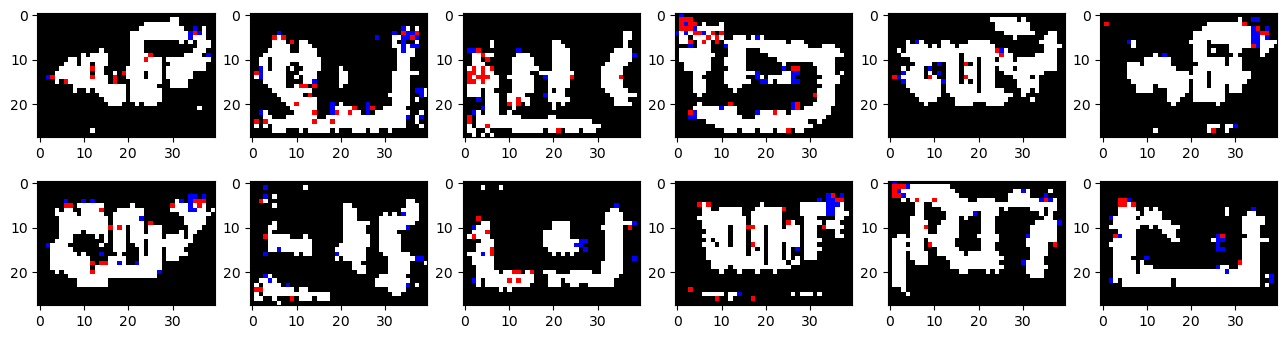

[3301/200]: loss_d: 0.003, loss_g: 6.548
[3302/200]: loss_d: 0.004, loss_g: 6.479
[3303/200]: loss_d: 0.003, loss_g: 6.641
[3304/200]: loss_d: 0.005, loss_g: 6.263
[3305/200]: loss_d: 0.003, loss_g: 7.114
[3306/200]: loss_d: 0.003, loss_g: 7.241
[3307/200]: loss_d: 0.006, loss_g: 6.083
[3308/200]: loss_d: 0.003, loss_g: 7.303
[3309/200]: loss_d: 0.008, loss_g: 6.249
[3310/200]: loss_d: 0.006, loss_g: 6.454
[3311/200]: loss_d: 0.004, loss_g: 6.790
[3312/200]: loss_d: 0.003, loss_g: 7.173
[3313/200]: loss_d: 0.004, loss_g: 6.570
[3314/200]: loss_d: 0.004, loss_g: 6.673
[3315/200]: loss_d: 0.003, loss_g: 6.911
[3316/200]: loss_d: 0.005, loss_g: 6.743
[3317/200]: loss_d: 0.004, loss_g: 6.642
[3318/200]: loss_d: 0.003, loss_g: 6.644
[3319/200]: loss_d: 0.004, loss_g: 6.510
[3320/200]: loss_d: 0.007, loss_g: 6.100
[3321/200]: loss_d: 0.002, loss_g: 7.377
[3322/200]: loss_d: 0.005, loss_g: 6.609
[3323/200]: loss_d: 0.003, loss_g: 6.940
[3324/200]: loss_d: 0.005, loss_g: 6.279
[3325/200]: loss

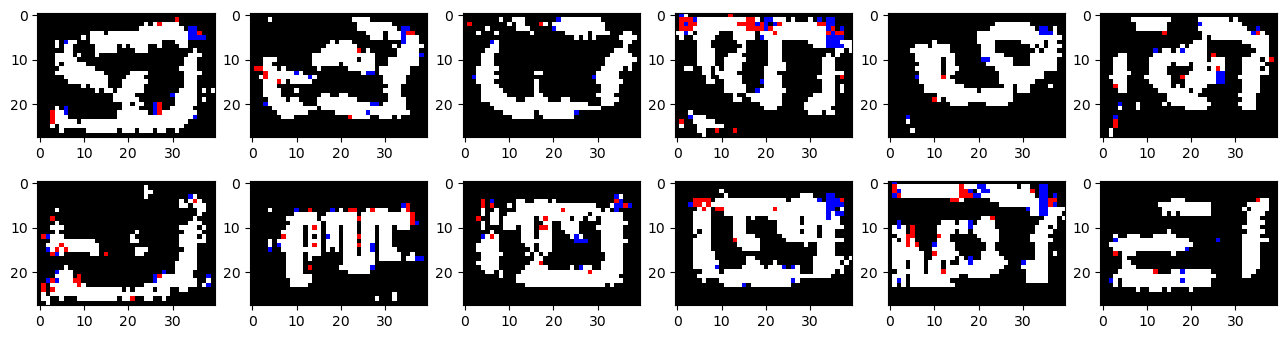

[3401/200]: loss_d: 0.005, loss_g: 6.371
[3402/200]: loss_d: 0.002, loss_g: 7.745
[3403/200]: loss_d: 0.004, loss_g: 6.550
[3404/200]: loss_d: 0.003, loss_g: 7.069
[3405/200]: loss_d: 0.003, loss_g: 6.901
[3406/200]: loss_d: 0.003, loss_g: 6.721
[3407/200]: loss_d: 0.002, loss_g: 7.422
[3408/200]: loss_d: 0.004, loss_g: 6.137
[3409/200]: loss_d: 0.004, loss_g: 6.652
[3410/200]: loss_d: 0.004, loss_g: 6.645
[3411/200]: loss_d: 0.002, loss_g: 7.481
[3412/200]: loss_d: 0.003, loss_g: 6.981
[3413/200]: loss_d: 0.002, loss_g: 7.140
[3414/200]: loss_d: 0.003, loss_g: 6.845
[3415/200]: loss_d: 0.005, loss_g: 6.208
[3416/200]: loss_d: 0.002, loss_g: 7.222
[3417/200]: loss_d: 0.003, loss_g: 6.778
[3418/200]: loss_d: 0.003, loss_g: 7.412
[3419/200]: loss_d: 0.003, loss_g: 6.623
[3420/200]: loss_d: 0.003, loss_g: 6.817
[3421/200]: loss_d: 0.002, loss_g: 7.156
[3422/200]: loss_d: 0.003, loss_g: 6.772
[3423/200]: loss_d: 0.003, loss_g: 7.063
[3424/200]: loss_d: 0.002, loss_g: 7.336
[3425/200]: loss

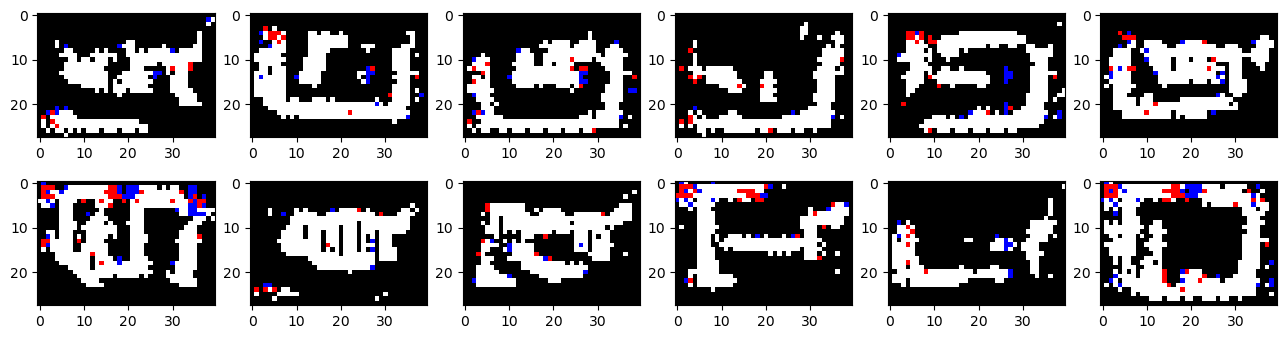

[3501/200]: loss_d: 0.003, loss_g: 6.729
[3502/200]: loss_d: 0.002, loss_g: 6.904
[3503/200]: loss_d: 0.002, loss_g: 7.322
[3504/200]: loss_d: 0.003, loss_g: 6.975
[3505/200]: loss_d: 0.003, loss_g: 7.070
[3506/200]: loss_d: 0.002, loss_g: 7.029
[3507/200]: loss_d: 0.002, loss_g: 7.247
[3508/200]: loss_d: 0.003, loss_g: 6.592
[3509/200]: loss_d: 0.003, loss_g: 6.923
[3510/200]: loss_d: 0.003, loss_g: 6.569
[3511/200]: loss_d: 0.004, loss_g: 6.357
[3512/200]: loss_d: 0.003, loss_g: 6.847
[3513/200]: loss_d: 0.003, loss_g: 6.681
[3514/200]: loss_d: 0.003, loss_g: 6.868
[3515/200]: loss_d: 0.005, loss_g: 6.182
[3516/200]: loss_d: 0.003, loss_g: 6.703
[3517/200]: loss_d: 0.003, loss_g: 6.784
[3518/200]: loss_d: 0.003, loss_g: 7.258
[3519/200]: loss_d: 0.003, loss_g: 6.860
[3520/200]: loss_d: 0.003, loss_g: 7.020
[3521/200]: loss_d: 0.002, loss_g: 7.473
[3522/200]: loss_d: 0.002, loss_g: 7.255
[3523/200]: loss_d: 0.003, loss_g: 6.594
[3524/200]: loss_d: 0.003, loss_g: 6.944
[3525/200]: loss

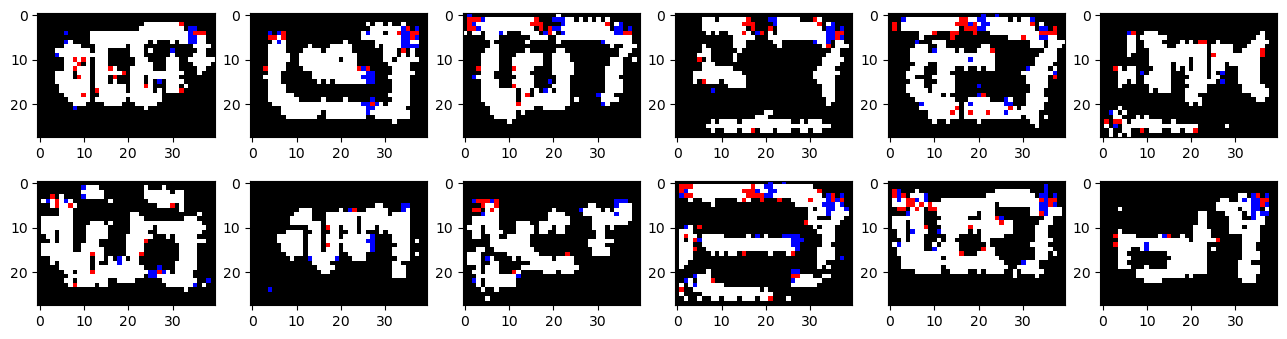

[3601/200]: loss_d: 0.003, loss_g: 7.052
[3602/200]: loss_d: 0.003, loss_g: 6.880
[3603/200]: loss_d: 0.002, loss_g: 7.639
[3604/200]: loss_d: 0.003, loss_g: 6.956
[3605/200]: loss_d: 0.002, loss_g: 7.228
[3606/200]: loss_d: 0.003, loss_g: 6.678
[3607/200]: loss_d: 0.004, loss_g: 6.408
[3608/200]: loss_d: 0.003, loss_g: 7.084
[3609/200]: loss_d: 0.002, loss_g: 7.231
[3610/200]: loss_d: 0.002, loss_g: 7.356
[3611/200]: loss_d: 0.004, loss_g: 6.567
[3612/200]: loss_d: 0.003, loss_g: 6.984
[3613/200]: loss_d: 0.002, loss_g: 7.099
[3614/200]: loss_d: 0.003, loss_g: 6.938
[3615/200]: loss_d: 0.003, loss_g: 6.526
[3616/200]: loss_d: 0.006, loss_g: 5.943
[3617/200]: loss_d: 0.003, loss_g: 7.243
[3618/200]: loss_d: 0.002, loss_g: 8.123
[3619/200]: loss_d: 0.002, loss_g: 7.376
[3620/200]: loss_d: 0.004, loss_g: 6.433
[3621/200]: loss_d: 0.002, loss_g: 7.377
[3622/200]: loss_d: 0.003, loss_g: 6.850
[3623/200]: loss_d: 0.002, loss_g: 7.423
[3624/200]: loss_d: 0.007, loss_g: 6.393
[3625/200]: loss

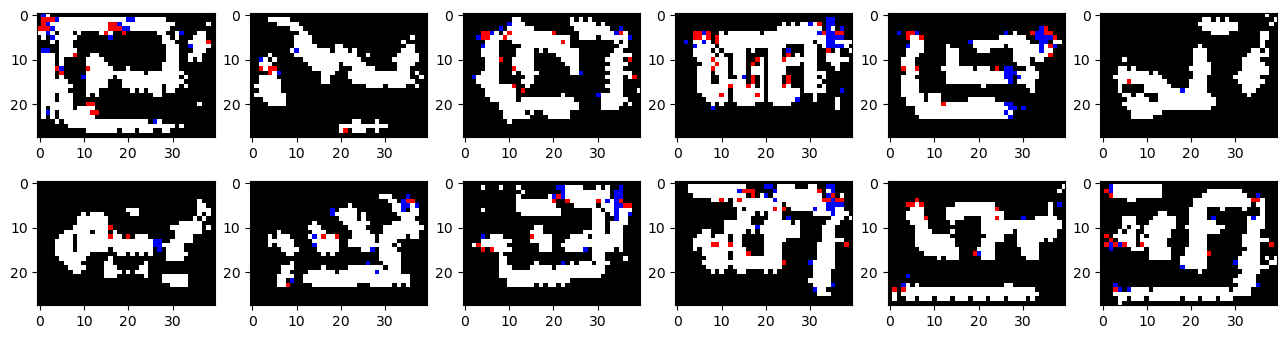

[3701/200]: loss_d: 0.002, loss_g: 7.255
[3702/200]: loss_d: 0.005, loss_g: 6.301
[3703/200]: loss_d: 0.002, loss_g: 7.464
[3704/200]: loss_d: 0.003, loss_g: 6.897
[3705/200]: loss_d: 0.003, loss_g: 6.725
[3706/200]: loss_d: 0.002, loss_g: 7.399
[3707/200]: loss_d: 0.003, loss_g: 6.923
[3708/200]: loss_d: 0.007, loss_g: 6.165
[3709/200]: loss_d: 0.003, loss_g: 6.853
[3710/200]: loss_d: 0.003, loss_g: 7.119
[3711/200]: loss_d: 0.005, loss_g: 6.260
[3712/200]: loss_d: 0.003, loss_g: 7.088
[3713/200]: loss_d: 0.002, loss_g: 7.184
[3714/200]: loss_d: 0.003, loss_g: 7.057
[3715/200]: loss_d: 0.002, loss_g: 7.263
[3716/200]: loss_d: 0.002, loss_g: 7.060
[3717/200]: loss_d: 0.004, loss_g: 7.039
[3718/200]: loss_d: 0.002, loss_g: 7.148
[3719/200]: loss_d: 0.002, loss_g: 7.416
[3720/200]: loss_d: 0.002, loss_g: 7.218
[3721/200]: loss_d: 0.003, loss_g: 7.387
[3722/200]: loss_d: 0.002, loss_g: 7.308
[3723/200]: loss_d: 0.003, loss_g: 6.928
[3724/200]: loss_d: 0.002, loss_g: 7.026
[3725/200]: loss

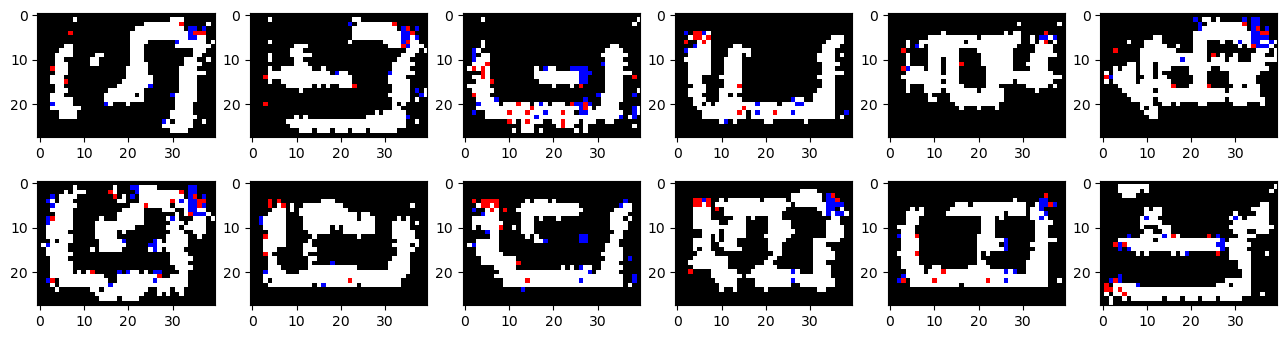

[3801/200]: loss_d: 0.003, loss_g: 7.033
[3802/200]: loss_d: 0.003, loss_g: 6.997
[3803/200]: loss_d: 0.004, loss_g: 6.341
[3804/200]: loss_d: 0.003, loss_g: 7.005
[3805/200]: loss_d: 0.003, loss_g: 6.643
[3806/200]: loss_d: 0.002, loss_g: 7.252
[3807/200]: loss_d: 0.004, loss_g: 6.893
[3808/200]: loss_d: 0.002, loss_g: 7.556
[3809/200]: loss_d: 0.003, loss_g: 7.452
[3810/200]: loss_d: 0.002, loss_g: 7.333
[3811/200]: loss_d: 0.002, loss_g: 7.063
[3812/200]: loss_d: 0.002, loss_g: 6.935
[3813/200]: loss_d: 0.003, loss_g: 6.917
[3814/200]: loss_d: 0.002, loss_g: 7.190
[3815/200]: loss_d: 0.005, loss_g: 6.797
[3816/200]: loss_d: 0.002, loss_g: 7.600
[3817/200]: loss_d: 0.002, loss_g: 7.526
[3818/200]: loss_d: 0.002, loss_g: 6.954
[3819/200]: loss_d: 0.004, loss_g: 6.686
[3820/200]: loss_d: 0.002, loss_g: 7.782
[3821/200]: loss_d: 0.002, loss_g: 6.974
[3822/200]: loss_d: 0.002, loss_g: 7.094
[3823/200]: loss_d: 0.002, loss_g: 7.495
[3824/200]: loss_d: 0.004, loss_g: 6.641
[3825/200]: loss

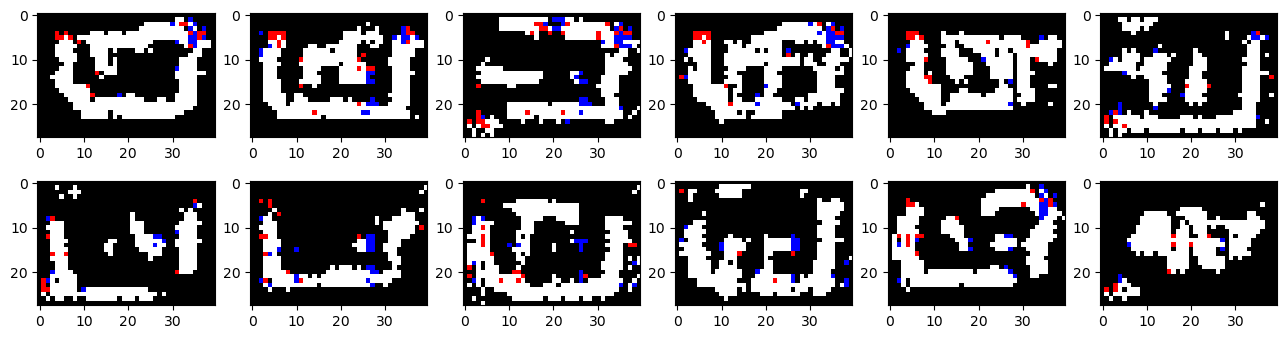

[3901/200]: loss_d: 0.003, loss_g: 7.094
[3902/200]: loss_d: 0.002, loss_g: 7.585
[3903/200]: loss_d: 0.004, loss_g: 6.862
[3904/200]: loss_d: 0.005, loss_g: 6.216
[3905/200]: loss_d: 0.003, loss_g: 6.979
[3906/200]: loss_d: 0.003, loss_g: 7.322
[3907/200]: loss_d: 0.002, loss_g: 8.800
[3908/200]: loss_d: 0.004, loss_g: 6.506
[3909/200]: loss_d: 0.003, loss_g: 6.999
[3910/200]: loss_d: 0.004, loss_g: 7.125
[3911/200]: loss_d: 0.002, loss_g: 7.505
[3912/200]: loss_d: 0.002, loss_g: 7.792
[3913/200]: loss_d: 0.004, loss_g: 6.779
[3914/200]: loss_d: 0.003, loss_g: 7.391
[3915/200]: loss_d: 0.002, loss_g: 7.398
[3916/200]: loss_d: 0.003, loss_g: 7.364
[3917/200]: loss_d: 0.002, loss_g: 7.328
[3918/200]: loss_d: 0.002, loss_g: 7.688
[3919/200]: loss_d: 0.002, loss_g: 7.188
[3920/200]: loss_d: 0.002, loss_g: 7.557
[3921/200]: loss_d: 0.002, loss_g: 7.259
[3922/200]: loss_d: 0.002, loss_g: 7.905
[3923/200]: loss_d: 0.002, loss_g: 6.997
[3924/200]: loss_d: 0.003, loss_g: 7.063
[3925/200]: loss

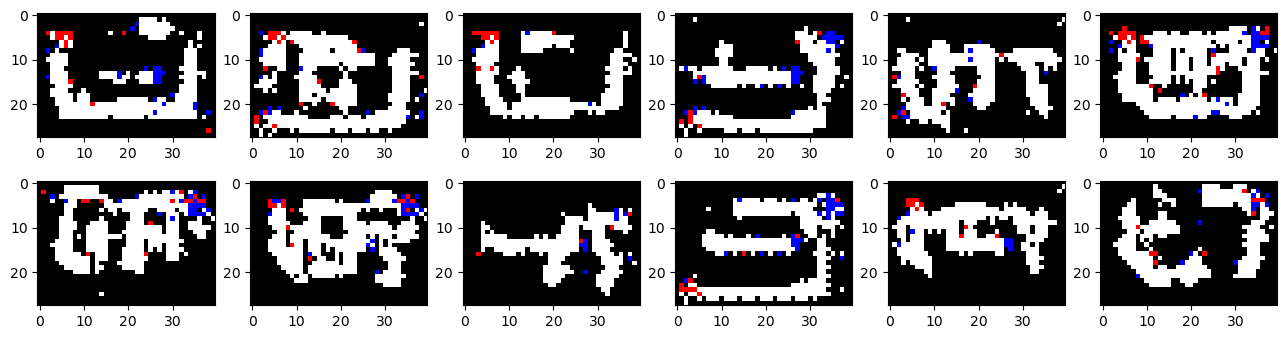

[4001/200]: loss_d: 0.003, loss_g: 7.494
[4002/200]: loss_d: 0.002, loss_g: 7.870
[4003/200]: loss_d: 0.002, loss_g: 6.951
[4004/200]: loss_d: 0.002, loss_g: 7.935
[4005/200]: loss_d: 0.002, loss_g: 7.139
[4006/200]: loss_d: 0.002, loss_g: 7.354
[4007/200]: loss_d: 0.003, loss_g: 6.656
[4008/200]: loss_d: 0.001, loss_g: 8.201
[4009/200]: loss_d: 0.002, loss_g: 7.060
[4010/200]: loss_d: 0.003, loss_g: 6.608
[4011/200]: loss_d: 0.002, loss_g: 7.606
[4012/200]: loss_d: 0.002, loss_g: 7.182
[4013/200]: loss_d: 0.003, loss_g: 6.602
[4014/200]: loss_d: 0.002, loss_g: 7.616
[4015/200]: loss_d: 0.003, loss_g: 7.179
[4016/200]: loss_d: 0.002, loss_g: 7.421
[4017/200]: loss_d: 0.003, loss_g: 6.571
[4018/200]: loss_d: 0.002, loss_g: 7.534
[4019/200]: loss_d: 0.002, loss_g: 7.352
[4020/200]: loss_d: 0.001, loss_g: 8.130
[4021/200]: loss_d: 0.004, loss_g: 6.619
[4022/200]: loss_d: 0.002, loss_g: 7.968
[4023/200]: loss_d: 0.003, loss_g: 6.961
[4024/200]: loss_d: 0.002, loss_g: 7.067
[4025/200]: loss

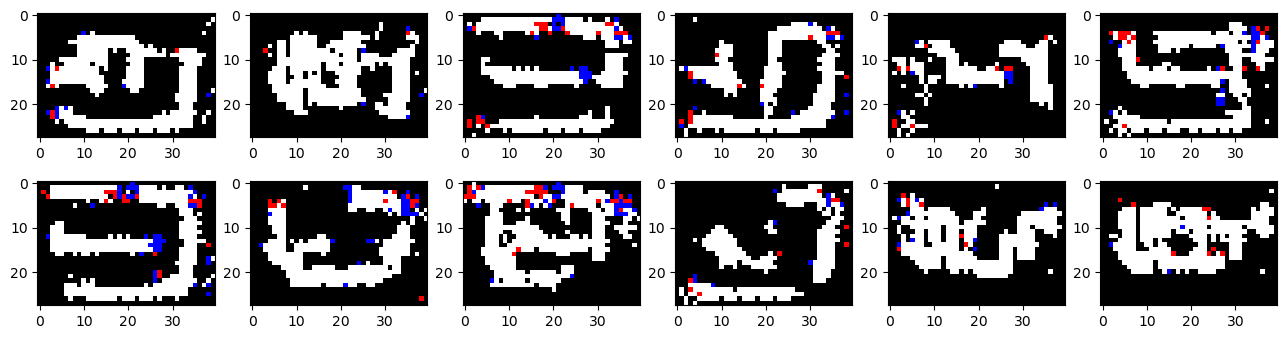

[4101/200]: loss_d: 0.003, loss_g: 6.570
[4102/200]: loss_d: 0.002, loss_g: 7.891
[4103/200]: loss_d: 0.002, loss_g: 7.716
[4104/200]: loss_d: 0.001, loss_g: 7.630
[4105/200]: loss_d: 0.001, loss_g: 7.896
[4106/200]: loss_d: 0.002, loss_g: 7.033
[4107/200]: loss_d: 0.003, loss_g: 7.059
[4108/200]: loss_d: 0.003, loss_g: 6.467
[4109/200]: loss_d: 0.002, loss_g: 7.509
[4110/200]: loss_d: 0.003, loss_g: 7.411
[4111/200]: loss_d: 0.002, loss_g: 7.925
[4112/200]: loss_d: 0.004, loss_g: 6.735
[4113/200]: loss_d: 0.002, loss_g: 7.518
[4114/200]: loss_d: 0.001, loss_g: 8.326
[4115/200]: loss_d: 0.003, loss_g: 6.856
[4116/200]: loss_d: 0.002, loss_g: 7.436
[4117/200]: loss_d: 0.002, loss_g: 7.114
[4118/200]: loss_d: 0.001, loss_g: 8.076
[4119/200]: loss_d: 0.001, loss_g: 7.803
[4120/200]: loss_d: 0.002, loss_g: 7.666
[4121/200]: loss_d: 0.002, loss_g: 7.678
[4122/200]: loss_d: 0.002, loss_g: 7.138
[4123/200]: loss_d: 0.002, loss_g: 7.586
[4124/200]: loss_d: 0.002, loss_g: 7.395
[4125/200]: loss

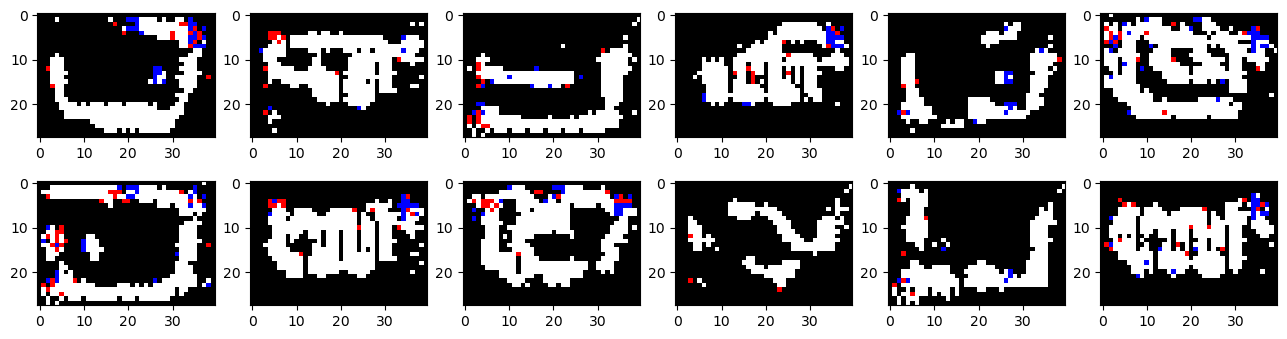

[4201/200]: loss_d: 0.003, loss_g: 7.375
[4202/200]: loss_d: 0.002, loss_g: 7.766
[4203/200]: loss_d: 0.003, loss_g: 6.811
[4204/200]: loss_d: 0.002, loss_g: 7.819
[4205/200]: loss_d: 0.002, loss_g: 7.132
[4206/200]: loss_d: 0.002, loss_g: 7.415
[4207/200]: loss_d: 0.002, loss_g: 7.539
[4208/200]: loss_d: 0.002, loss_g: 7.613
[4209/200]: loss_d: 0.002, loss_g: 7.173
[4210/200]: loss_d: 0.002, loss_g: 7.048
[4211/200]: loss_d: 0.002, loss_g: 7.374
[4212/200]: loss_d: 0.002, loss_g: 7.501
[4213/200]: loss_d: 0.003, loss_g: 6.906
[4214/200]: loss_d: 0.002, loss_g: 7.220
[4215/200]: loss_d: 0.002, loss_g: 7.015
[4216/200]: loss_d: 0.002, loss_g: 7.154
[4217/200]: loss_d: 0.002, loss_g: 7.717
[4218/200]: loss_d: 0.002, loss_g: 7.590
[4219/200]: loss_d: 0.003, loss_g: 7.119
[4220/200]: loss_d: 0.002, loss_g: 7.326
[4221/200]: loss_d: 0.001, loss_g: 8.545
[4222/200]: loss_d: 0.002, loss_g: 7.425
[4223/200]: loss_d: 0.002, loss_g: 7.751
[4224/200]: loss_d: 0.003, loss_g: 6.505
[4225/200]: loss

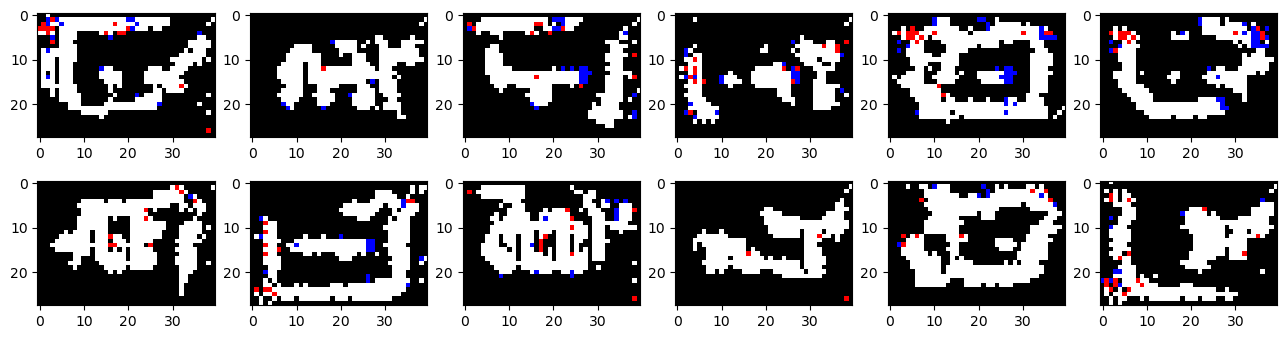

[4301/200]: loss_d: 0.002, loss_g: 7.343
[4302/200]: loss_d: 0.001, loss_g: 8.567
[4303/200]: loss_d: 0.001, loss_g: 8.265
[4304/200]: loss_d: 0.001, loss_g: 7.731
[4305/200]: loss_d: 0.001, loss_g: 7.535
[4306/200]: loss_d: 0.002, loss_g: 6.827
[4307/200]: loss_d: 0.001, loss_g: 7.816
[4308/200]: loss_d: 0.002, loss_g: 7.358
[4309/200]: loss_d: 0.001, loss_g: 7.848
[4310/200]: loss_d: 0.002, loss_g: 6.921
[4311/200]: loss_d: 0.001, loss_g: 8.351
[4312/200]: loss_d: 0.001, loss_g: 7.549
[4313/200]: loss_d: 0.003, loss_g: 6.963
[4314/200]: loss_d: 0.001, loss_g: 7.863
[4315/200]: loss_d: 0.003, loss_g: 7.142
[4316/200]: loss_d: 0.002, loss_g: 7.224
[4317/200]: loss_d: 0.002, loss_g: 7.039
[4318/200]: loss_d: 0.003, loss_g: 7.016
[4319/200]: loss_d: 0.003, loss_g: 6.867
[4320/200]: loss_d: 0.002, loss_g: 8.017
[4321/200]: loss_d: 0.002, loss_g: 7.494
[4322/200]: loss_d: 0.001, loss_g: 7.979
[4323/200]: loss_d: 0.002, loss_g: 7.697
[4324/200]: loss_d: 0.001, loss_g: 7.692
[4325/200]: loss

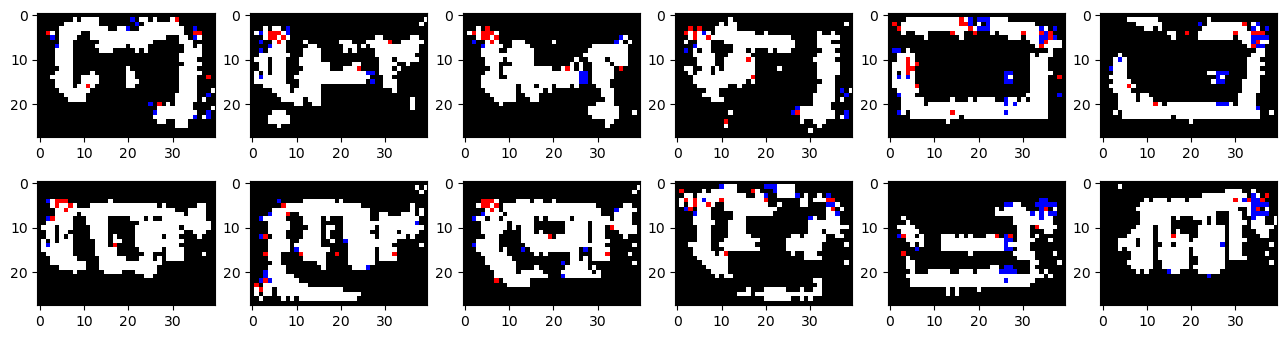

[4401/200]: loss_d: 0.004, loss_g: 6.621
[4402/200]: loss_d: 0.002, loss_g: 6.940
[4403/200]: loss_d: 0.003, loss_g: 7.161
[4404/200]: loss_d: 0.002, loss_g: 7.478
[4405/200]: loss_d: 0.001, loss_g: 9.143
[4406/200]: loss_d: 0.001, loss_g: 8.203
[4407/200]: loss_d: 0.001, loss_g: 7.857
[4408/200]: loss_d: 0.002, loss_g: 7.788
[4409/200]: loss_d: 0.002, loss_g: 6.819
[4410/200]: loss_d: 0.002, loss_g: 7.646
[4411/200]: loss_d: 0.001, loss_g: 8.085
[4412/200]: loss_d: 0.002, loss_g: 7.698
[4413/200]: loss_d: 0.001, loss_g: 7.855
[4414/200]: loss_d: 0.002, loss_g: 7.502
[4415/200]: loss_d: 0.001, loss_g: 8.030
[4416/200]: loss_d: 0.002, loss_g: 7.635
[4417/200]: loss_d: 0.002, loss_g: 7.379
[4418/200]: loss_d: 0.002, loss_g: 6.807
[4419/200]: loss_d: 0.002, loss_g: 7.121
[4420/200]: loss_d: 0.002, loss_g: 7.971
[4421/200]: loss_d: 0.003, loss_g: 7.167
[4422/200]: loss_d: 0.001, loss_g: 7.944
[4423/200]: loss_d: 0.001, loss_g: 8.212
[4424/200]: loss_d: 0.001, loss_g: 7.786
[4425/200]: loss

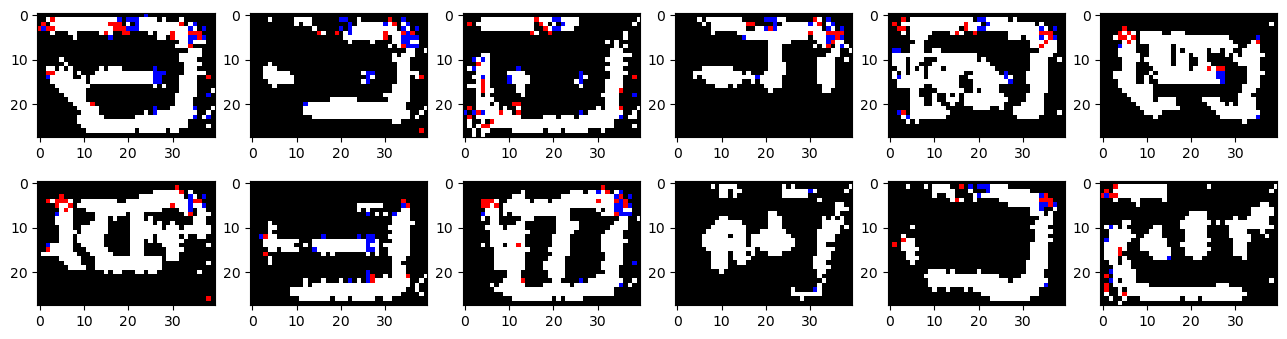

[4501/200]: loss_d: 0.003, loss_g: 6.914
[4502/200]: loss_d: 0.001, loss_g: 7.847
[4503/200]: loss_d: 0.002, loss_g: 7.773
[4504/200]: loss_d: 0.001, loss_g: 8.104
[4505/200]: loss_d: 0.001, loss_g: 7.925
[4506/200]: loss_d: 0.001, loss_g: 7.730
[4507/200]: loss_d: 0.002, loss_g: 7.325
[4508/200]: loss_d: 0.002, loss_g: 7.430
[4509/200]: loss_d: 0.001, loss_g: 8.009
[4510/200]: loss_d: 0.002, loss_g: 7.058
[4511/200]: loss_d: 0.001, loss_g: 8.552
[4512/200]: loss_d: 0.001, loss_g: 8.511
[4513/200]: loss_d: 0.002, loss_g: 7.094
[4514/200]: loss_d: 0.002, loss_g: 7.315
[4515/200]: loss_d: 0.001, loss_g: 7.917
[4516/200]: loss_d: 0.001, loss_g: 8.223
[4517/200]: loss_d: 0.003, loss_g: 6.820
[4518/200]: loss_d: 0.001, loss_g: 7.495
[4519/200]: loss_d: 0.001, loss_g: 8.519
[4520/200]: loss_d: 0.001, loss_g: 7.485
[4521/200]: loss_d: 0.001, loss_g: 8.130
[4522/200]: loss_d: 0.001, loss_g: 8.181
[4523/200]: loss_d: 0.003, loss_g: 6.713
[4524/200]: loss_d: 0.002, loss_g: 7.259
[4525/200]: loss

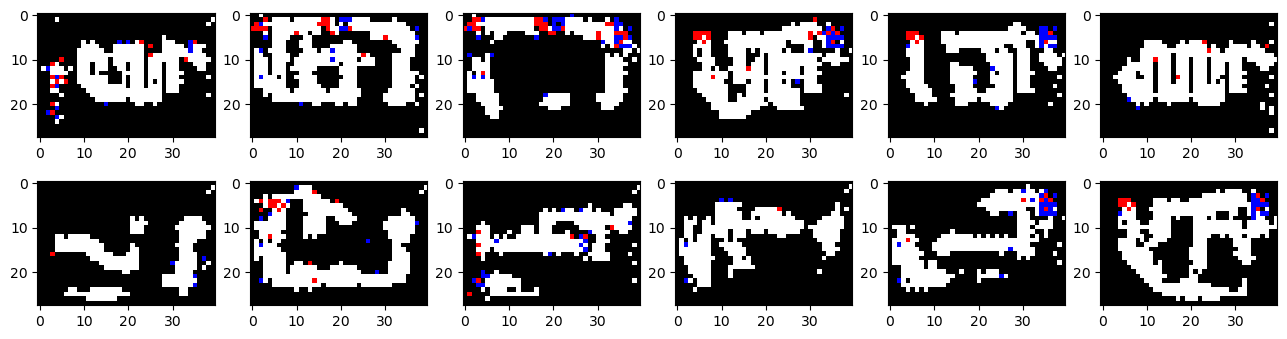

[4601/200]: loss_d: 0.001, loss_g: 8.039
[4602/200]: loss_d: 0.001, loss_g: 7.544
[4603/200]: loss_d: 0.001, loss_g: 7.936
[4604/200]: loss_d: 0.002, loss_g: 7.286
[4605/200]: loss_d: 0.001, loss_g: 8.260
[4606/200]: loss_d: 0.001, loss_g: 7.720
[4607/200]: loss_d: 0.001, loss_g: 8.223
[4608/200]: loss_d: 0.002, loss_g: 7.039
[4609/200]: loss_d: 0.002, loss_g: 7.656
[4610/200]: loss_d: 0.001, loss_g: 8.228
[4611/200]: loss_d: 0.001, loss_g: 9.767
[4612/200]: loss_d: 0.002, loss_g: 6.918
[4613/200]: loss_d: 0.001, loss_g: 8.384
[4614/200]: loss_d: 0.001, loss_g: 7.481
[4615/200]: loss_d: 0.002, loss_g: 6.960
[4616/200]: loss_d: 0.001, loss_g: 8.703
[4617/200]: loss_d: 0.002, loss_g: 7.486
[4618/200]: loss_d: 0.002, loss_g: 7.262
[4619/200]: loss_d: 0.001, loss_g: 8.342
[4620/200]: loss_d: 0.002, loss_g: 7.541
[4621/200]: loss_d: 0.001, loss_g: 8.365
[4622/200]: loss_d: 0.001, loss_g: 8.097
[4623/200]: loss_d: 0.001, loss_g: 8.143
[4624/200]: loss_d: 0.001, loss_g: 7.544
[4625/200]: loss

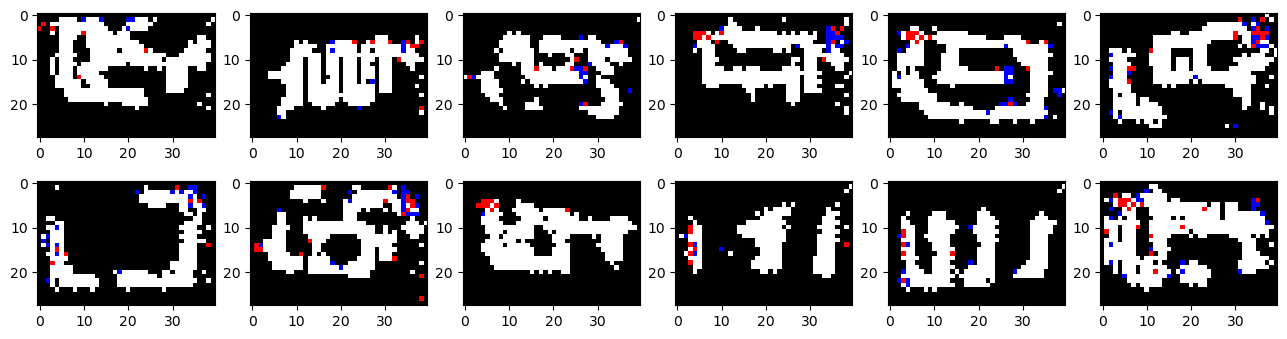

[4701/200]: loss_d: 0.001, loss_g: 9.051
[4702/200]: loss_d: 0.002, loss_g: 7.418
[4703/200]: loss_d: 0.001, loss_g: 8.705
[4704/200]: loss_d: 0.002, loss_g: 7.631
[4705/200]: loss_d: 0.001, loss_g: 8.223
[4706/200]: loss_d: 0.003, loss_g: 6.738
[4707/200]: loss_d: 0.001, loss_g: 7.958
[4708/200]: loss_d: 0.001, loss_g: 8.495
[4709/200]: loss_d: 0.002, loss_g: 7.706
[4710/200]: loss_d: 0.002, loss_g: 7.469
[4711/200]: loss_d: 0.001, loss_g: 7.722
[4712/200]: loss_d: 0.002, loss_g: 7.328
[4713/200]: loss_d: 0.002, loss_g: 7.972
[4714/200]: loss_d: 0.001, loss_g: 7.442
[4715/200]: loss_d: 0.001, loss_g: 8.420
[4716/200]: loss_d: 0.002, loss_g: 7.212
[4717/200]: loss_d: 0.001, loss_g: 8.221
[4718/200]: loss_d: 0.001, loss_g: 8.004
[4719/200]: loss_d: 0.003, loss_g: 7.080
[4720/200]: loss_d: 0.002, loss_g: 7.903
[4721/200]: loss_d: 0.002, loss_g: 7.124
[4722/200]: loss_d: 0.001, loss_g: 9.089
[4723/200]: loss_d: 0.001, loss_g: 8.587
[4724/200]: loss_d: 0.001, loss_g: 7.966
[4725/200]: loss

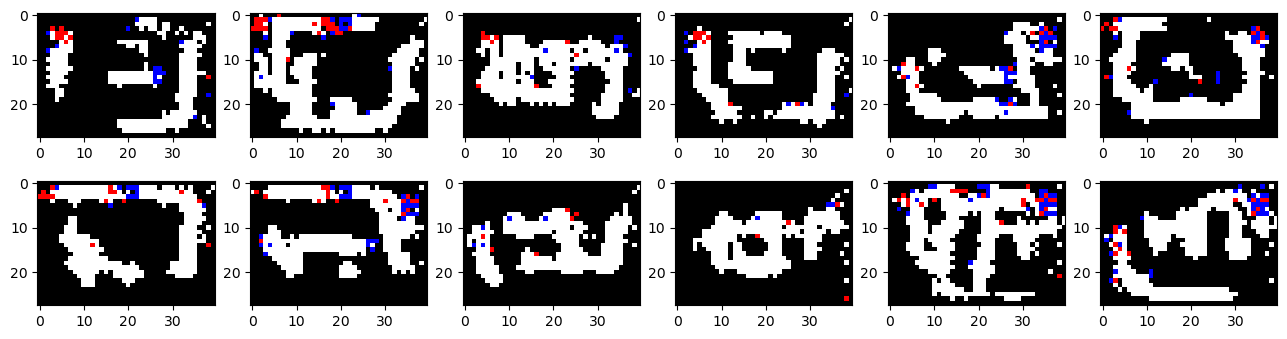

[4801/200]: loss_d: 0.002, loss_g: 7.942
[4802/200]: loss_d: 0.001, loss_g: 7.686
[4803/200]: loss_d: 0.002, loss_g: 7.055
[4804/200]: loss_d: 0.002, loss_g: 7.923
[4805/200]: loss_d: 0.001, loss_g: 8.528
[4806/200]: loss_d: 0.001, loss_g: 8.106
[4807/200]: loss_d: 0.001, loss_g: 7.638
[4808/200]: loss_d: 0.001, loss_g: 7.680
[4809/200]: loss_d: 0.001, loss_g: 8.603
[4810/200]: loss_d: 0.001, loss_g: 8.419
[4811/200]: loss_d: 0.001, loss_g: 9.117
[4812/200]: loss_d: 0.003, loss_g: 6.946
[4813/200]: loss_d: 0.001, loss_g: 8.088
[4814/200]: loss_d: 0.001, loss_g: 8.529
[4815/200]: loss_d: 0.001, loss_g: 7.765
[4816/200]: loss_d: 0.002, loss_g: 6.956
[4817/200]: loss_d: 0.001, loss_g: 8.204
[4818/200]: loss_d: 0.001, loss_g: 8.787
[4819/200]: loss_d: 0.002, loss_g: 7.461
[4820/200]: loss_d: 0.003, loss_g: 7.018
[4821/200]: loss_d: 0.002, loss_g: 7.583
[4822/200]: loss_d: 0.001, loss_g: 8.291
[4823/200]: loss_d: 0.001, loss_g: 8.184
[4824/200]: loss_d: 0.003, loss_g: 6.959
[4825/200]: loss

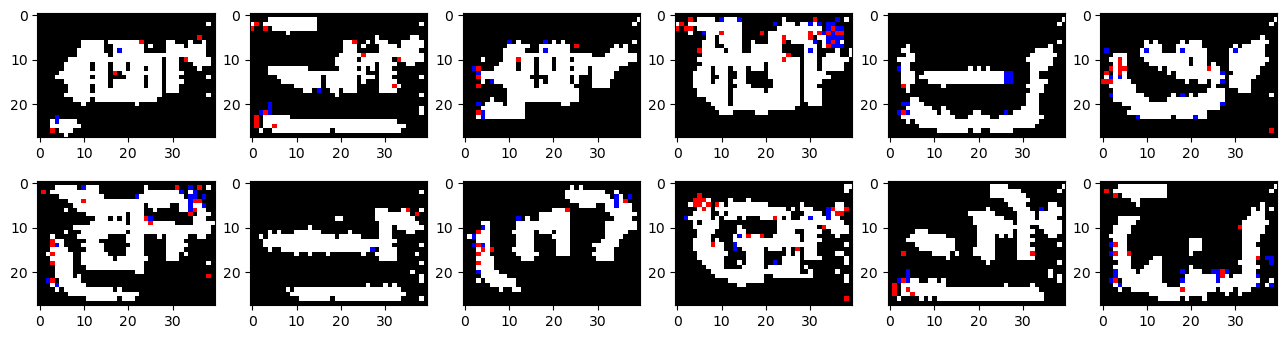

[4901/200]: loss_d: 0.001, loss_g: 7.651
[4902/200]: loss_d: 0.002, loss_g: 7.277
[4903/200]: loss_d: 0.001, loss_g: 7.985
[4904/200]: loss_d: 0.001, loss_g: 8.070
[4905/200]: loss_d: 0.001, loss_g: 7.823
[4906/200]: loss_d: 0.001, loss_g: 7.600
[4907/200]: loss_d: 0.001, loss_g: 9.042
[4908/200]: loss_d: 0.001, loss_g: 7.686
[4909/200]: loss_d: 0.001, loss_g: 7.699
[4910/200]: loss_d: 0.001, loss_g: 8.163
[4911/200]: loss_d: 0.005, loss_g: 6.480
[4912/200]: loss_d: 0.002, loss_g: 8.111
[4913/200]: loss_d: 0.002, loss_g: 8.569
[4914/200]: loss_d: 0.001, loss_g: 7.658
[4915/200]: loss_d: 0.002, loss_g: 7.417
[4916/200]: loss_d: 0.002, loss_g: 7.566
[4917/200]: loss_d: 0.001, loss_g: 8.210
[4918/200]: loss_d: 0.002, loss_g: 7.153
[4919/200]: loss_d: 0.001, loss_g: 8.128
[4920/200]: loss_d: 0.001, loss_g: 8.149
[4921/200]: loss_d: 0.001, loss_g: 8.983
[4922/200]: loss_d: 0.002, loss_g: 7.004
[4923/200]: loss_d: 0.001, loss_g: 7.843
[4924/200]: loss_d: 0.001, loss_g: 8.399
[4925/200]: loss

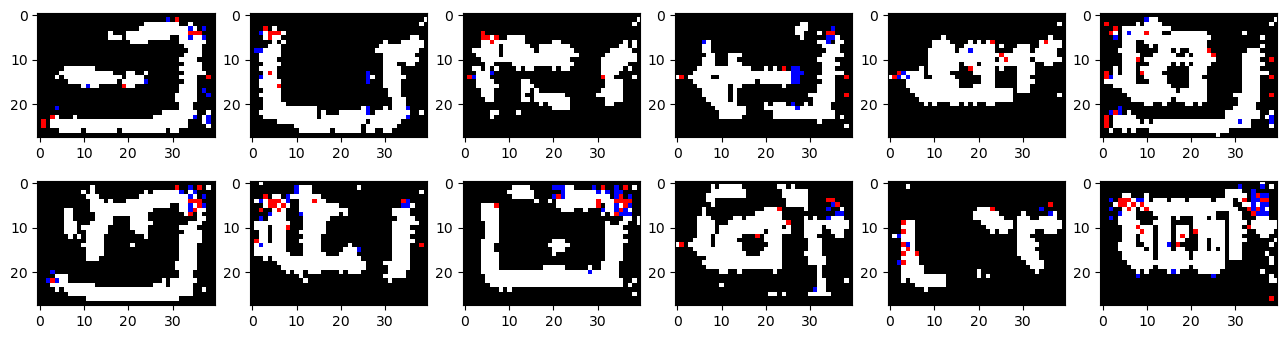

[5001/200]: loss_d: 0.002, loss_g: 7.220
[5002/200]: loss_d: 0.001, loss_g: 7.661
[5003/200]: loss_d: 0.001, loss_g: 9.183
[5004/200]: loss_d: 0.001, loss_g: 8.320
[5005/200]: loss_d: 0.001, loss_g: 7.738
[5006/200]: loss_d: 0.001, loss_g: 8.320
[5007/200]: loss_d: 0.002, loss_g: 6.956
[5008/200]: loss_d: 0.001, loss_g: 9.172
[5009/200]: loss_d: 0.001, loss_g: 8.846
[5010/200]: loss_d: 0.002, loss_g: 7.364
[5011/200]: loss_d: 0.001, loss_g: 8.275
[5012/200]: loss_d: 0.001, loss_g: 7.779
[5013/200]: loss_d: 0.004, loss_g: 6.965
[5014/200]: loss_d: 0.001, loss_g: 9.499
[5015/200]: loss_d: 0.002, loss_g: 7.546
[5016/200]: loss_d: 0.002, loss_g: 8.522
[5017/200]: loss_d: 0.001, loss_g: 7.960
[5018/200]: loss_d: 0.001, loss_g: 8.225
[5019/200]: loss_d: 0.001, loss_g: 8.105
[5020/200]: loss_d: 0.001, loss_g: 9.468
[5021/200]: loss_d: 0.001, loss_g: 8.322
[5022/200]: loss_d: 0.007, loss_g: 6.871
[5023/200]: loss_d: 0.002, loss_g: 7.735
[5024/200]: loss_d: 0.002, loss_g: 8.627
[5025/200]: loss

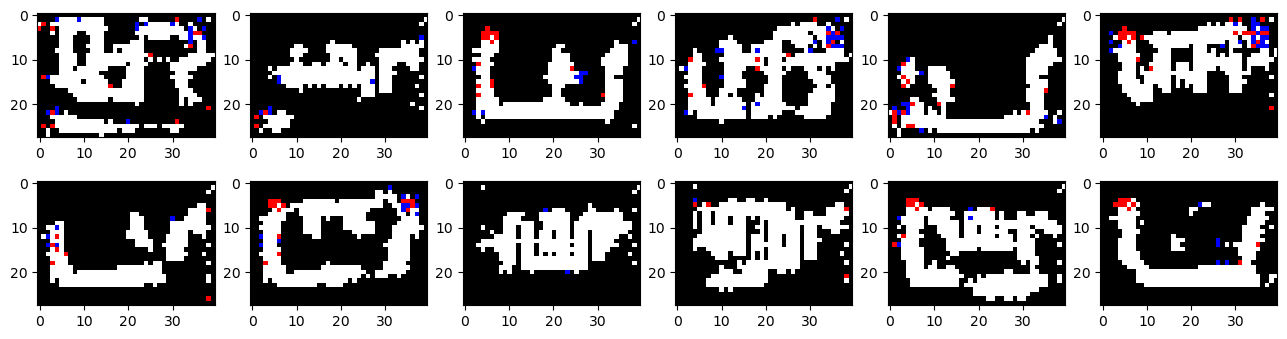

[5101/200]: loss_d: 0.001, loss_g: 9.749
[5102/200]: loss_d: 0.001, loss_g: 7.885
[5103/200]: loss_d: 0.002, loss_g: 7.294
[5104/200]: loss_d: 0.003, loss_g: 7.235
[5105/200]: loss_d: 0.001, loss_g: 9.111
[5106/200]: loss_d: 0.002, loss_g: 7.874
[5107/200]: loss_d: 0.001, loss_g: 9.149
[5108/200]: loss_d: 0.001, loss_g: 7.818
[5109/200]: loss_d: 0.001, loss_g: 7.379
[5110/200]: loss_d: 0.001, loss_g: 8.286
[5111/200]: loss_d: 0.001, loss_g: 8.626
[5112/200]: loss_d: 0.001, loss_g: 8.600
[5113/200]: loss_d: 0.002, loss_g: 8.475
[5114/200]: loss_d: 0.001, loss_g: 8.030
[5115/200]: loss_d: 0.001, loss_g: 8.647
[5116/200]: loss_d: 0.001, loss_g: 7.499
[5117/200]: loss_d: 0.001, loss_g: 8.679
[5118/200]: loss_d: 0.001, loss_g: 8.170
[5119/200]: loss_d: 0.001, loss_g: 7.951
[5120/200]: loss_d: 0.002, loss_g: 7.475
[5121/200]: loss_d: 0.001, loss_g: 9.400
[5122/200]: loss_d: 0.002, loss_g: 7.349
[5123/200]: loss_d: 0.001, loss_g: 8.075
[5124/200]: loss_d: 0.002, loss_g: 7.932
[5125/200]: loss

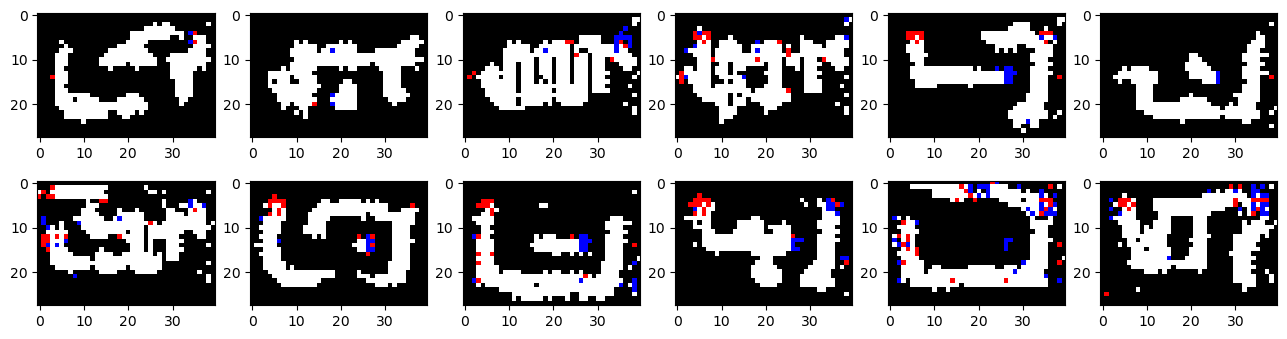

[5201/200]: loss_d: 0.001, loss_g: 8.422
[5202/200]: loss_d: 0.001, loss_g: 8.885
[5203/200]: loss_d: 0.001, loss_g: 8.453
[5204/200]: loss_d: 0.001, loss_g: 8.282
[5205/200]: loss_d: 0.001, loss_g: 7.882
[5206/200]: loss_d: 0.001, loss_g: 7.943
[5207/200]: loss_d: 0.001, loss_g: 8.695
[5208/200]: loss_d: 0.001, loss_g: 8.324
[5209/200]: loss_d: 0.002, loss_g: 7.122
[5210/200]: loss_d: 0.001, loss_g: 8.916
[5211/200]: loss_d: 0.001, loss_g: 8.452
[5212/200]: loss_d: 0.001, loss_g: 7.980
[5213/200]: loss_d: 0.001, loss_g: 8.950
[5214/200]: loss_d: 0.001, loss_g: 8.311
[5215/200]: loss_d: 0.001, loss_g: 8.259
[5216/200]: loss_d: 0.002, loss_g: 7.536
[5217/200]: loss_d: 0.001, loss_g: 8.487
[5218/200]: loss_d: 0.001, loss_g: 7.920
[5219/200]: loss_d: 0.001, loss_g: 8.870
[5220/200]: loss_d: 0.001, loss_g: 8.449
[5221/200]: loss_d: 0.001, loss_g: 8.334
[5222/200]: loss_d: 0.003, loss_g: 7.284
[5223/200]: loss_d: 0.001, loss_g: 8.792
[5224/200]: loss_d: 0.001, loss_g: 9.430
[5225/200]: loss

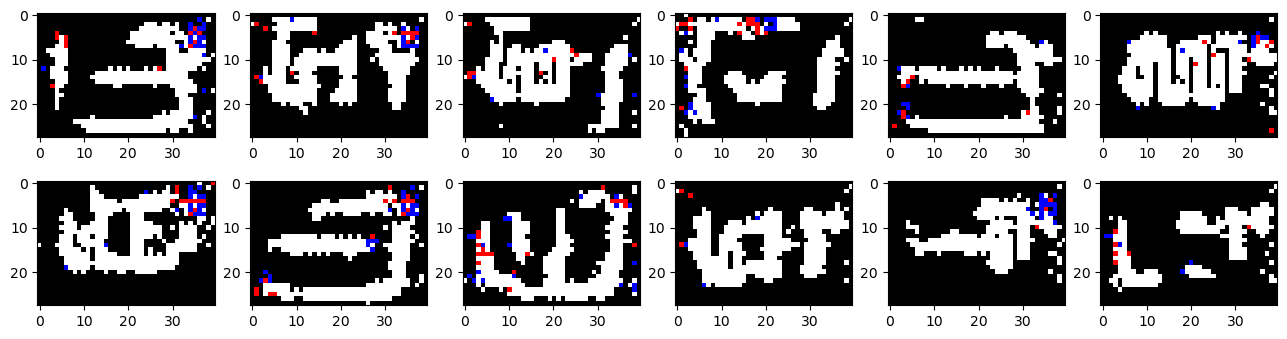

[5301/200]: loss_d: 0.001, loss_g: 8.638
[5302/200]: loss_d: 0.001, loss_g: 8.080
[5303/200]: loss_d: 0.002, loss_g: 6.974
[5304/200]: loss_d: 0.001, loss_g: 9.022
[5305/200]: loss_d: 0.001, loss_g: 7.996
[5306/200]: loss_d: 0.002, loss_g: 7.539
[5307/200]: loss_d: 0.001, loss_g: 9.234
[5308/200]: loss_d: 0.002, loss_g: 7.327
[5309/200]: loss_d: 0.001, loss_g: 8.357
[5310/200]: loss_d: 0.002, loss_g: 7.457
[5311/200]: loss_d: 0.001, loss_g: 8.687
[5312/200]: loss_d: 0.001, loss_g: 8.519
[5313/200]: loss_d: 0.003, loss_g: 7.123
[5314/200]: loss_d: 0.001, loss_g: 8.017
[5315/200]: loss_d: 0.001, loss_g: 7.916
[5316/200]: loss_d: 0.001, loss_g: 9.737
[5317/200]: loss_d: 0.001, loss_g: 8.650
[5318/200]: loss_d: 0.002, loss_g: 7.797
[5319/200]: loss_d: 0.001, loss_g: 9.219
[5320/200]: loss_d: 0.001, loss_g: 8.942
[5321/200]: loss_d: 0.001, loss_g: 7.912
[5322/200]: loss_d: 0.001, loss_g: 8.190
[5323/200]: loss_d: 0.001, loss_g: 7.602
[5324/200]: loss_d: 0.002, loss_g: 7.213
[5325/200]: loss

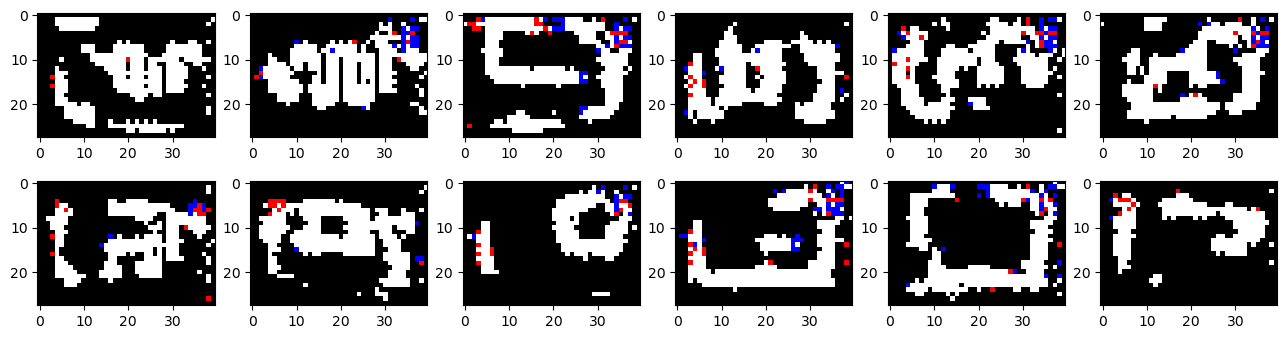

[5401/200]: loss_d: 0.001, loss_g: 8.533
[5402/200]: loss_d: 0.002, loss_g: 7.486
[5403/200]: loss_d: 0.001, loss_g: 8.516
[5404/200]: loss_d: 0.001, loss_g: 9.120
[5405/200]: loss_d: 0.001, loss_g: 8.644
[5406/200]: loss_d: 0.002, loss_g: 7.239
[5407/200]: loss_d: 0.001, loss_g: 7.976
[5408/200]: loss_d: 0.001, loss_g: 9.365
[5409/200]: loss_d: 0.001, loss_g: 8.076
[5410/200]: loss_d: 0.001, loss_g: 7.792
[5411/200]: loss_d: 0.001, loss_g: 7.976
[5412/200]: loss_d: 0.001, loss_g: 8.936
[5413/200]: loss_d: 0.001, loss_g: 8.316
[5414/200]: loss_d: 0.001, loss_g: 7.619
[5415/200]: loss_d: 0.001, loss_g: 8.496
[5416/200]: loss_d: 0.001, loss_g: 8.783
[5417/200]: loss_d: 0.001, loss_g: 8.276
[5418/200]: loss_d: 0.001, loss_g: 8.805
[5419/200]: loss_d: 0.000, loss_g: 9.574
[5420/200]: loss_d: 0.001, loss_g: 8.412
[5421/200]: loss_d: 0.001, loss_g: 8.607
[5422/200]: loss_d: 0.002, loss_g: 7.473
[5423/200]: loss_d: 0.001, loss_g: 9.348
[5424/200]: loss_d: 0.001, loss_g: 9.739
[5425/200]: loss

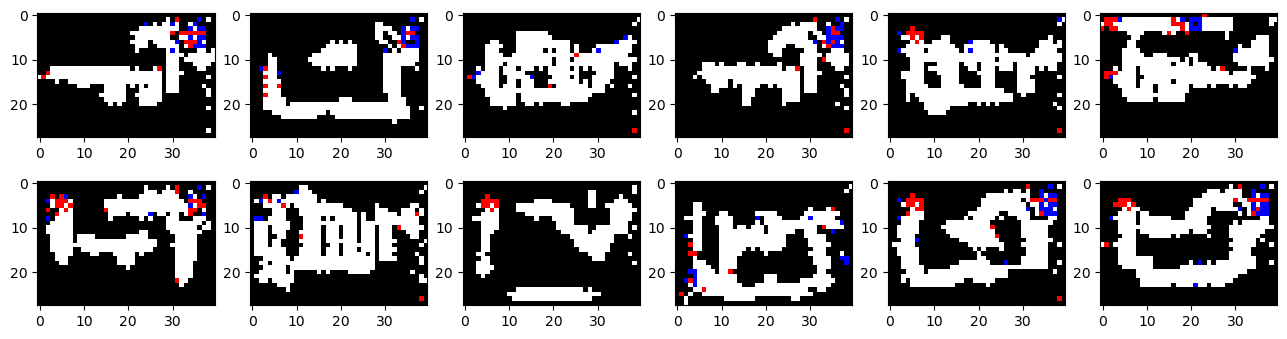

[5501/200]: loss_d: 0.001, loss_g: 7.760
[5502/200]: loss_d: 0.001, loss_g: 9.332
[5503/200]: loss_d: 0.001, loss_g: 7.996
[5504/200]: loss_d: 0.001, loss_g: 8.589
[5505/200]: loss_d: 0.000, loss_g: 9.371
[5506/200]: loss_d: 0.001, loss_g: 8.270
[5507/200]: loss_d: 0.001, loss_g: 8.202
[5508/200]: loss_d: 0.002, loss_g: 7.401
[5509/200]: loss_d: 0.001, loss_g: 9.185
[5510/200]: loss_d: 0.001, loss_g: 9.215
[5511/200]: loss_d: 0.002, loss_g: 8.130
[5512/200]: loss_d: 0.001, loss_g: 8.469
[5513/200]: loss_d: 0.001, loss_g: 7.843
[5514/200]: loss_d: 0.001, loss_g: 8.113
[5515/200]: loss_d: 0.001, loss_g: 8.729
[5516/200]: loss_d: 0.001, loss_g: 8.022
[5517/200]: loss_d: 0.002, loss_g: 7.813
[5518/200]: loss_d: 0.001, loss_g: 9.598
[5519/200]: loss_d: 0.001, loss_g: 9.018
[5520/200]: loss_d: 0.001, loss_g: 7.667
[5521/200]: loss_d: 0.001, loss_g: 8.492
[5522/200]: loss_d: 0.001, loss_g: 7.930
[5523/200]: loss_d: 0.001, loss_g: 8.074
[5524/200]: loss_d: 0.001, loss_g: 8.278
[5525/200]: loss

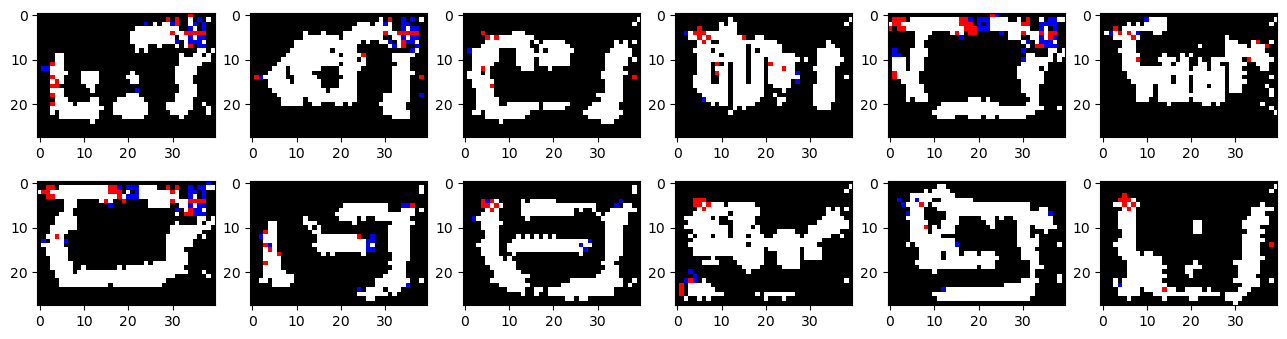

[5601/200]: loss_d: 0.001, loss_g: 8.902
[5602/200]: loss_d: 0.001, loss_g: 8.065
[5603/200]: loss_d: 0.000, loss_g: 9.577
[5604/200]: loss_d: 0.000, loss_g: 9.361
[5605/200]: loss_d: 0.001, loss_g: 8.104
[5606/200]: loss_d: 0.001, loss_g: 8.596
[5607/200]: loss_d: 0.001, loss_g: 8.864
[5608/200]: loss_d: 0.001, loss_g: 8.926
[5609/200]: loss_d: 0.001, loss_g: 8.077
[5610/200]: loss_d: 0.001, loss_g: 8.597
[5611/200]: loss_d: 0.001, loss_g: 7.691
[5612/200]: loss_d: 0.001, loss_g: 8.127
[5613/200]: loss_d: 0.001, loss_g: 8.439
[5614/200]: loss_d: 0.001, loss_g: 8.101
[5615/200]: loss_d: 0.002, loss_g: 7.421
[5616/200]: loss_d: 0.001, loss_g: 8.363
[5617/200]: loss_d: 0.003, loss_g: 8.303
[5618/200]: loss_d: 0.002, loss_g: 7.465
[5619/200]: loss_d: 0.001, loss_g: 8.815
[5620/200]: loss_d: 0.001, loss_g: 7.788
[5621/200]: loss_d: 0.001, loss_g: 8.376
[5622/200]: loss_d: 0.001, loss_g: 8.601
[5623/200]: loss_d: 0.001, loss_g: 8.118
[5624/200]: loss_d: 0.001, loss_g: 9.079
[5625/200]: loss

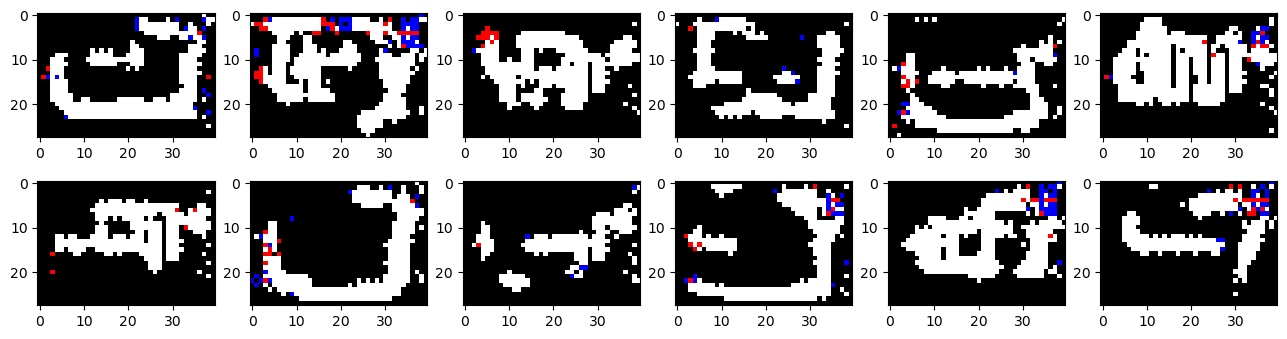

[5701/200]: loss_d: 0.001, loss_g: 9.102
[5702/200]: loss_d: 0.001, loss_g: 8.369
[5703/200]: loss_d: 0.001, loss_g: 8.688
[5704/200]: loss_d: 0.001, loss_g: 9.288
[5705/200]: loss_d: 0.001, loss_g: 8.048
[5706/200]: loss_d: 0.001, loss_g: 8.730
[5707/200]: loss_d: 0.001, loss_g: 7.930
[5708/200]: loss_d: 0.001, loss_g: 8.356
[5709/200]: loss_d: 0.001, loss_g: 9.060
[5710/200]: loss_d: 0.001, loss_g: 8.086
[5711/200]: loss_d: 0.000, loss_g: 9.736
[5712/200]: loss_d: 0.002, loss_g: 7.629
[5713/200]: loss_d: 0.001, loss_g: 9.205
[5714/200]: loss_d: 0.001, loss_g: 9.219
[5715/200]: loss_d: 0.001, loss_g: 8.043
[5716/200]: loss_d: 0.001, loss_g: 8.441
[5717/200]: loss_d: 0.000, loss_g: 9.702
[5718/200]: loss_d: 0.001, loss_g: 8.144
[5719/200]: loss_d: 0.001, loss_g: 7.705
[5720/200]: loss_d: 0.001, loss_g: 8.104
[5721/200]: loss_d: 0.001, loss_g: 8.078
[5722/200]: loss_d: 0.001, loss_g: 9.253
[5723/200]: loss_d: 0.001, loss_g: 9.058
[5724/200]: loss_d: 0.001, loss_g: 8.408
[5725/200]: loss

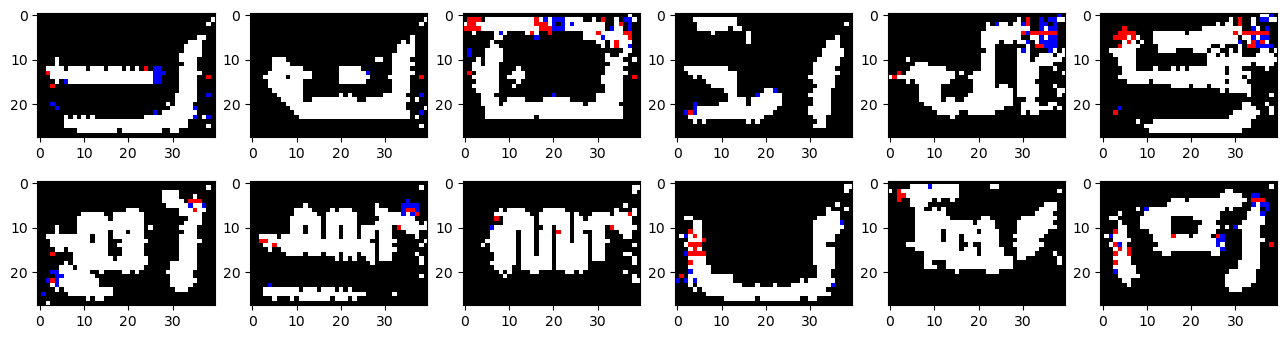

[5801/200]: loss_d: 0.001, loss_g: 8.078
[5802/200]: loss_d: 0.000, loss_g: 10.280
[5803/200]: loss_d: 0.001, loss_g: 8.097
[5804/200]: loss_d: 0.001, loss_g: 8.818
[5805/200]: loss_d: 0.000, loss_g: 9.795
[5806/200]: loss_d: 0.001, loss_g: 7.612
[5807/200]: loss_d: 0.001, loss_g: 8.846
[5808/200]: loss_d: 0.001, loss_g: 8.321
[5809/200]: loss_d: 0.001, loss_g: 8.379
[5810/200]: loss_d: 0.001, loss_g: 8.647
[5811/200]: loss_d: 0.001, loss_g: 8.740
[5812/200]: loss_d: 0.001, loss_g: 8.674
[5813/200]: loss_d: 0.003, loss_g: 7.227
[5814/200]: loss_d: 0.001, loss_g: 9.106
[5815/200]: loss_d: 0.001, loss_g: 7.874
[5816/200]: loss_d: 0.001, loss_g: 9.323
[5817/200]: loss_d: 0.001, loss_g: 7.329
[5818/200]: loss_d: 0.001, loss_g: 8.091
[5819/200]: loss_d: 0.001, loss_g: 8.417
[5820/200]: loss_d: 0.001, loss_g: 8.084
[5821/200]: loss_d: 0.001, loss_g: 8.873
[5822/200]: loss_d: 0.001, loss_g: 8.650
[5823/200]: loss_d: 0.001, loss_g: 7.967
[5824/200]: loss_d: 0.001, loss_g: 8.193
[5825/200]: los

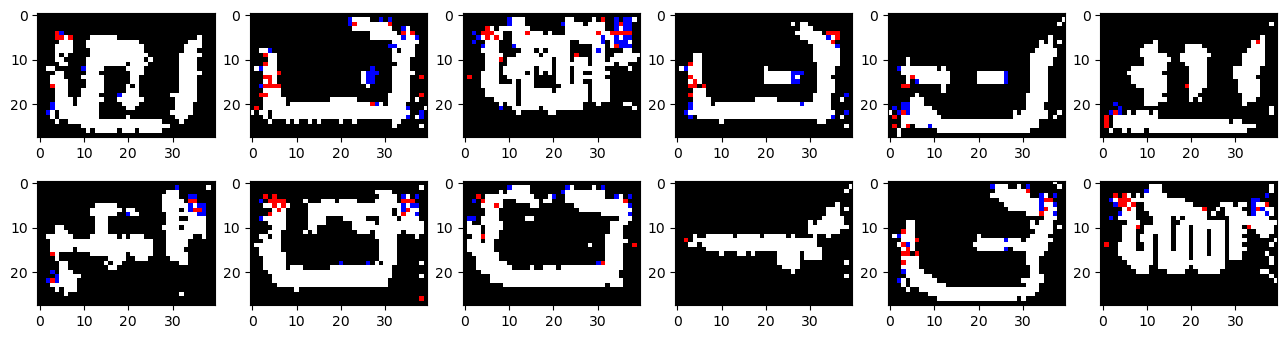

[5901/200]: loss_d: 0.001, loss_g: 9.619
[5902/200]: loss_d: 0.001, loss_g: 8.469
[5903/200]: loss_d: 0.001, loss_g: 8.717
[5904/200]: loss_d: 0.001, loss_g: 9.156
[5905/200]: loss_d: 0.000, loss_g: 9.686
[5906/200]: loss_d: 0.000, loss_g: 9.298
[5907/200]: loss_d: 0.001, loss_g: 8.359
[5908/200]: loss_d: 0.001, loss_g: 8.274
[5909/200]: loss_d: 0.000, loss_g: 9.385
[5910/200]: loss_d: 0.001, loss_g: 8.812
[5911/200]: loss_d: 0.001, loss_g: 8.848
[5912/200]: loss_d: 0.000, loss_g: 10.144
[5913/200]: loss_d: 0.001, loss_g: 7.545
[5914/200]: loss_d: 0.001, loss_g: 7.835
[5915/200]: loss_d: 0.001, loss_g: 9.016
[5916/200]: loss_d: 0.001, loss_g: 8.644
[5917/200]: loss_d: 0.001, loss_g: 8.647
[5918/200]: loss_d: 0.001, loss_g: 8.707
[5919/200]: loss_d: 0.001, loss_g: 8.650
[5920/200]: loss_d: 0.001, loss_g: 8.608
[5921/200]: loss_d: 0.001, loss_g: 8.191
[5922/200]: loss_d: 0.001, loss_g: 9.249
[5923/200]: loss_d: 0.002, loss_g: 7.847
[5924/200]: loss_d: 0.001, loss_g: 8.127
[5925/200]: los

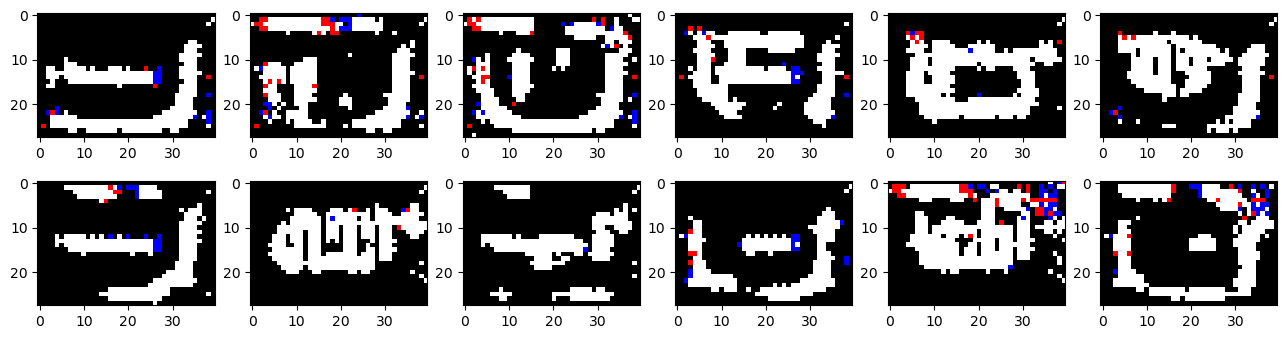

[6001/200]: loss_d: 0.000, loss_g: 9.539
[6002/200]: loss_d: 0.000, loss_g: 8.709
[6003/200]: loss_d: 0.001, loss_g: 8.538
[6004/200]: loss_d: 0.000, loss_g: 8.869
[6005/200]: loss_d: 0.000, loss_g: 9.655
[6006/200]: loss_d: 0.001, loss_g: 7.860
[6007/200]: loss_d: 0.001, loss_g: 9.151
[6008/200]: loss_d: 0.001, loss_g: 8.336
[6009/200]: loss_d: 0.001, loss_g: 8.898
[6010/200]: loss_d: 0.001, loss_g: 8.439
[6011/200]: loss_d: 0.001, loss_g: 8.512
[6012/200]: loss_d: 0.001, loss_g: 8.587
[6013/200]: loss_d: 0.001, loss_g: 8.483
[6014/200]: loss_d: 0.001, loss_g: 9.700
[6015/200]: loss_d: 0.001, loss_g: 8.473
[6016/200]: loss_d: 0.001, loss_g: 9.182
[6017/200]: loss_d: 0.001, loss_g: 7.833
[6018/200]: loss_d: 0.001, loss_g: 9.266
[6019/200]: loss_d: 0.001, loss_g: 9.134
[6020/200]: loss_d: 0.000, loss_g: 9.832
[6021/200]: loss_d: 0.000, loss_g: 9.433
[6022/200]: loss_d: 0.000, loss_g: 8.700
[6023/200]: loss_d: 0.000, loss_g: 9.679
[6024/200]: loss_d: 0.000, loss_g: 8.637
[6025/200]: loss

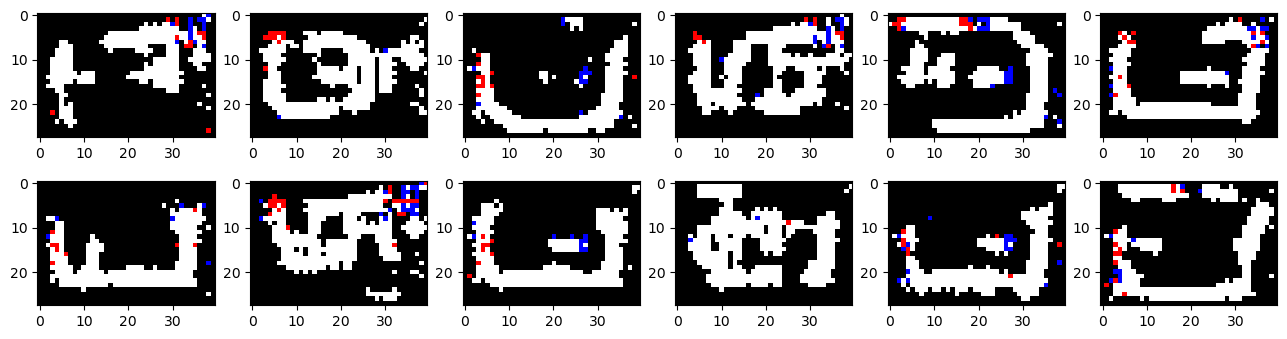

[6101/200]: loss_d: 0.000, loss_g: 9.336
[6102/200]: loss_d: 0.001, loss_g: 8.296
[6103/200]: loss_d: 0.001, loss_g: 8.803
[6104/200]: loss_d: 0.001, loss_g: 8.488
[6105/200]: loss_d: 0.001, loss_g: 8.242
[6106/200]: loss_d: 0.001, loss_g: 9.248
[6107/200]: loss_d: 0.000, loss_g: 9.585
[6108/200]: loss_d: 0.001, loss_g: 8.684
[6109/200]: loss_d: 0.001, loss_g: 9.063
[6110/200]: loss_d: 0.000, loss_g: 9.432
[6111/200]: loss_d: 0.001, loss_g: 8.551
[6112/200]: loss_d: 0.000, loss_g: 9.402
[6113/200]: loss_d: 0.000, loss_g: 8.812
[6114/200]: loss_d: 0.000, loss_g: 8.688
[6115/200]: loss_d: 0.001, loss_g: 7.929
[6116/200]: loss_d: 0.000, loss_g: 9.016
[6117/200]: loss_d: 0.000, loss_g: 8.775
[6118/200]: loss_d: 0.001, loss_g: 8.262
[6119/200]: loss_d: 0.001, loss_g: 9.189
[6120/200]: loss_d: 0.001, loss_g: 8.489
[6121/200]: loss_d: 0.001, loss_g: 8.853
[6122/200]: loss_d: 0.001, loss_g: 8.100
[6123/200]: loss_d: 0.001, loss_g: 8.804
[6124/200]: loss_d: 0.001, loss_g: 9.225
[6125/200]: loss

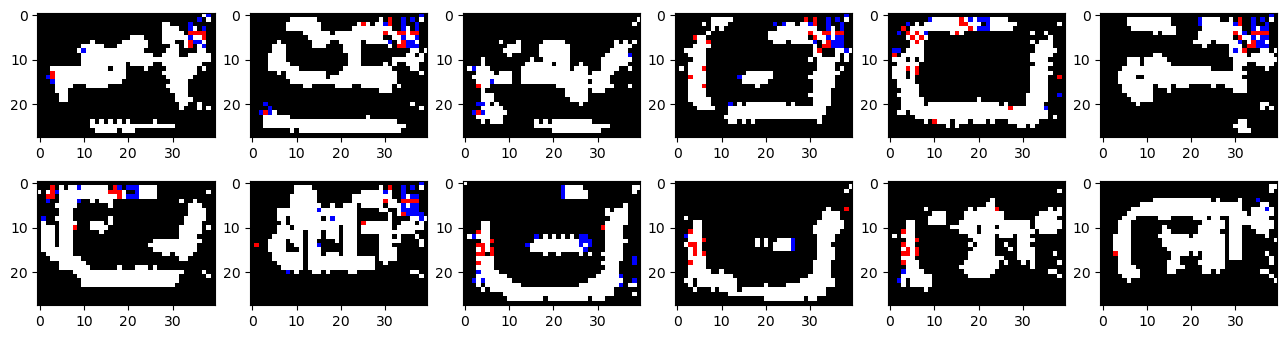

[6201/200]: loss_d: 0.000, loss_g: 9.249
[6202/200]: loss_d: 0.000, loss_g: 9.013
[6203/200]: loss_d: 0.000, loss_g: 9.347
[6204/200]: loss_d: 0.000, loss_g: 9.446
[6205/200]: loss_d: 0.000, loss_g: 8.966
[6206/200]: loss_d: 0.001, loss_g: 7.957
[6207/200]: loss_d: 0.000, loss_g: 10.200
[6208/200]: loss_d: 0.001, loss_g: 8.860
[6209/200]: loss_d: 0.001, loss_g: 8.051
[6210/200]: loss_d: 0.000, loss_g: 9.391
[6211/200]: loss_d: 0.001, loss_g: 7.925
[6212/200]: loss_d: 0.001, loss_g: 8.730
[6213/200]: loss_d: 0.000, loss_g: 9.753
[6214/200]: loss_d: 0.000, loss_g: 9.426
[6215/200]: loss_d: 0.001, loss_g: 8.159
[6216/200]: loss_d: 0.001, loss_g: 8.907
[6217/200]: loss_d: 0.001, loss_g: 8.736
[6218/200]: loss_d: 0.000, loss_g: 9.862
[6219/200]: loss_d: 0.001, loss_g: 8.872
[6220/200]: loss_d: 0.000, loss_g: 9.053
[6221/200]: loss_d: 0.000, loss_g: 10.339
[6222/200]: loss_d: 0.001, loss_g: 8.337
[6223/200]: loss_d: 0.001, loss_g: 7.854
[6224/200]: loss_d: 0.000, loss_g: 9.502
[6225/200]: lo

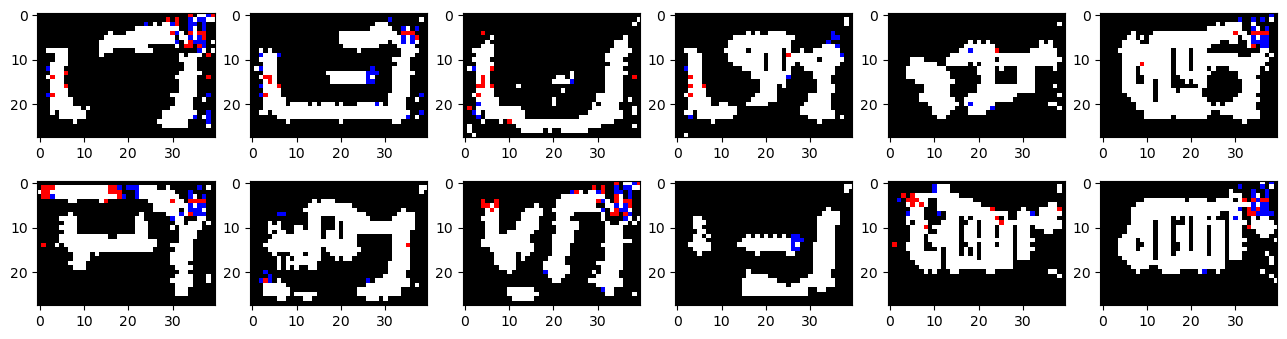

[6301/200]: loss_d: 0.001, loss_g: 8.298
[6302/200]: loss_d: 0.001, loss_g: 8.381
[6303/200]: loss_d: 0.001, loss_g: 8.126
[6304/200]: loss_d: 0.000, loss_g: 9.947
[6305/200]: loss_d: 0.000, loss_g: 9.300
[6306/200]: loss_d: 0.000, loss_g: 8.427
[6307/200]: loss_d: 0.001, loss_g: 8.466
[6308/200]: loss_d: 0.001, loss_g: 7.856
[6309/200]: loss_d: 0.001, loss_g: 8.994
[6310/200]: loss_d: 0.000, loss_g: 9.355
[6311/200]: loss_d: 0.001, loss_g: 7.922
[6312/200]: loss_d: 0.000, loss_g: 9.044
[6313/200]: loss_d: 0.001, loss_g: 8.241
[6314/200]: loss_d: 0.001, loss_g: 8.118
[6315/200]: loss_d: 0.001, loss_g: 8.202
[6316/200]: loss_d: 0.000, loss_g: 9.828
[6317/200]: loss_d: 0.001, loss_g: 7.997
[6318/200]: loss_d: 0.000, loss_g: 9.832
[6319/200]: loss_d: 0.000, loss_g: 9.074
[6320/200]: loss_d: 0.001, loss_g: 8.631
[6321/200]: loss_d: 0.000, loss_g: 9.410
[6322/200]: loss_d: 0.001, loss_g: 7.610
[6323/200]: loss_d: 0.000, loss_g: 9.328
[6324/200]: loss_d: 0.000, loss_g: 9.257
[6325/200]: loss

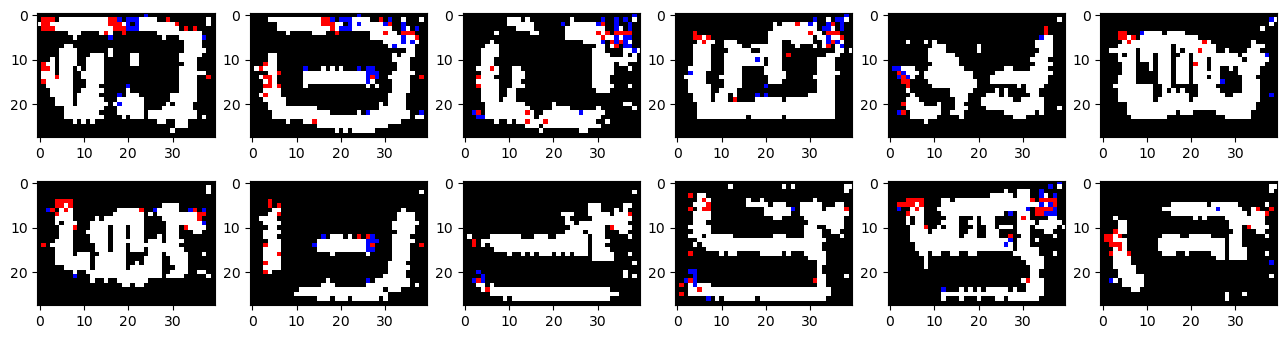

[6401/200]: loss_d: 0.026, loss_g: 4.731
[6402/200]: loss_d: 0.024, loss_g: 4.818
[6403/200]: loss_d: 0.036, loss_g: 4.635
[6404/200]: loss_d: 0.022, loss_g: 5.177
[6405/200]: loss_d: 0.025, loss_g: 4.862
[6406/200]: loss_d: 0.021, loss_g: 5.314
[6407/200]: loss_d: 0.020, loss_g: 5.079
[6408/200]: loss_d: 0.022, loss_g: 5.007
[6409/200]: loss_d: 0.022, loss_g: 4.874
[6410/200]: loss_d: 0.019, loss_g: 5.274
[6411/200]: loss_d: 0.021, loss_g: 4.870
[6412/200]: loss_d: 0.036, loss_g: 4.586
[6413/200]: loss_d: 0.046, loss_g: 5.215
[6414/200]: loss_d: 0.024, loss_g: 5.785
[6415/200]: loss_d: 0.023, loss_g: 5.572
[6416/200]: loss_d: 0.022, loss_g: 5.121
[6417/200]: loss_d: 0.031, loss_g: 4.202
[6418/200]: loss_d: 0.028, loss_g: 4.866
[6419/200]: loss_d: 0.025, loss_g: 5.018
[6420/200]: loss_d: 0.022, loss_g: 5.400
[6421/200]: loss_d: 0.021, loss_g: 4.855
[6422/200]: loss_d: 0.018, loss_g: 5.582
[6423/200]: loss_d: 0.017, loss_g: 5.097
[6424/200]: loss_d: 0.017, loss_g: 5.404
[6425/200]: loss

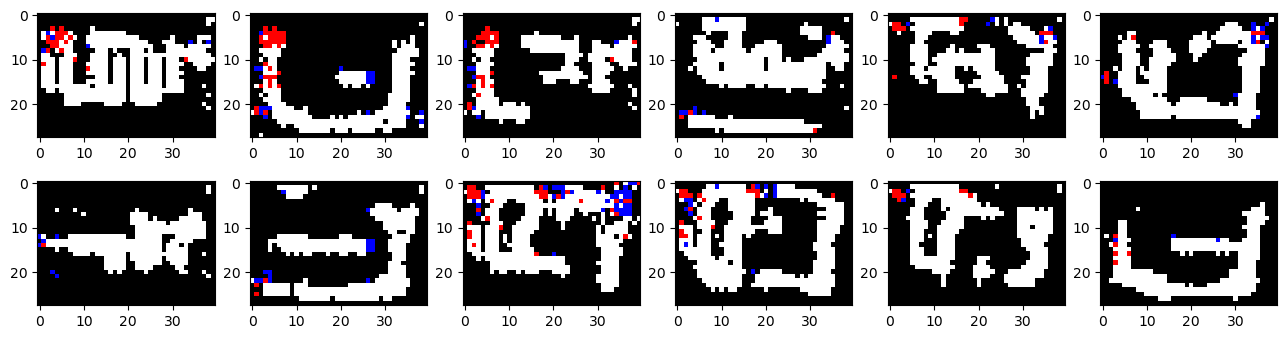

[6501/200]: loss_d: 0.009, loss_g: 6.421
[6502/200]: loss_d: 0.007, loss_g: 6.599
[6503/200]: loss_d: 0.007, loss_g: 5.801
[6504/200]: loss_d: 0.009, loss_g: 5.976
[6505/200]: loss_d: 0.010, loss_g: 5.798
[6506/200]: loss_d: 0.006, loss_g: 6.420
[6507/200]: loss_d: 0.008, loss_g: 5.641
[6508/200]: loss_d: 0.007, loss_g: 6.347
[6509/200]: loss_d: 0.006, loss_g: 6.149
[6510/200]: loss_d: 0.013, loss_g: 5.185
[6511/200]: loss_d: 0.012, loss_g: 5.144
[6512/200]: loss_d: 0.009, loss_g: 5.868
[6513/200]: loss_d: 0.010, loss_g: 6.486
[6514/200]: loss_d: 0.005, loss_g: 7.689
[6515/200]: loss_d: 0.009, loss_g: 5.788
[6516/200]: loss_d: 0.009, loss_g: 5.890
[6517/200]: loss_d: 0.005, loss_g: 7.281
[6518/200]: loss_d: 0.006, loss_g: 6.423
[6519/200]: loss_d: 0.006, loss_g: 6.658
[6520/200]: loss_d: 0.012, loss_g: 5.430
[6521/200]: loss_d: 0.011, loss_g: 6.041
[6522/200]: loss_d: 0.006, loss_g: 6.538
[6523/200]: loss_d: 0.008, loss_g: 5.899
[6524/200]: loss_d: 0.007, loss_g: 5.887
[6525/200]: loss

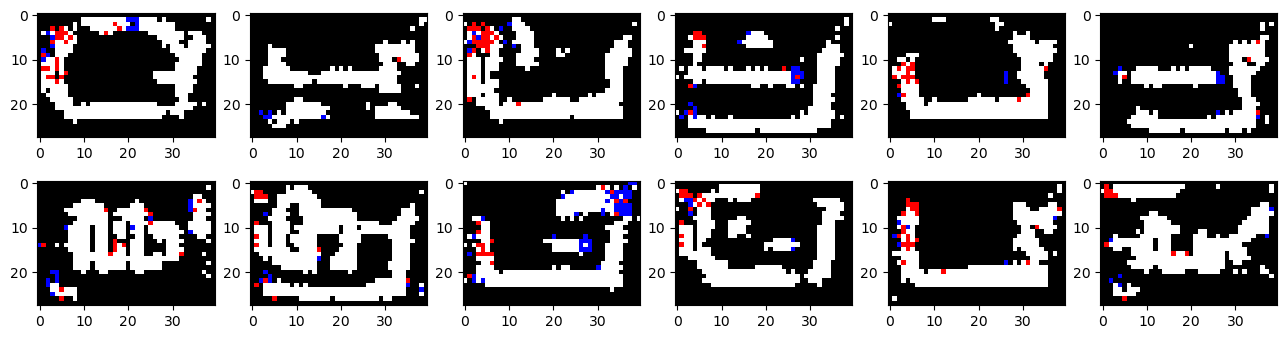

[6601/200]: loss_d: 0.005, loss_g: 6.831
[6602/200]: loss_d: 0.009, loss_g: 5.652
[6603/200]: loss_d: 0.007, loss_g: 5.997
[6604/200]: loss_d: 0.006, loss_g: 7.399
[6605/200]: loss_d: 0.005, loss_g: 6.709
[6606/200]: loss_d: 0.005, loss_g: 6.899
[6607/200]: loss_d: 0.006, loss_g: 6.410
[6608/200]: loss_d: 0.006, loss_g: 6.356
[6609/200]: loss_d: 0.004, loss_g: 7.040
[6610/200]: loss_d: 0.005, loss_g: 6.552
[6611/200]: loss_d: 0.005, loss_g: 6.552
[6612/200]: loss_d: 0.003, loss_g: 7.249
[6613/200]: loss_d: 0.007, loss_g: 6.176
[6614/200]: loss_d: 0.003, loss_g: 7.288
[6615/200]: loss_d: 0.007, loss_g: 6.131
[6616/200]: loss_d: 0.005, loss_g: 6.756
[6617/200]: loss_d: 0.003, loss_g: 7.383
[6618/200]: loss_d: 0.003, loss_g: 7.154
[6619/200]: loss_d: 0.006, loss_g: 6.260
[6620/200]: loss_d: 0.003, loss_g: 7.160
[6621/200]: loss_d: 0.004, loss_g: 7.084
[6622/200]: loss_d: 0.003, loss_g: 6.902
[6623/200]: loss_d: 0.004, loss_g: 7.321
[6624/200]: loss_d: 0.004, loss_g: 7.099
[6625/200]: loss

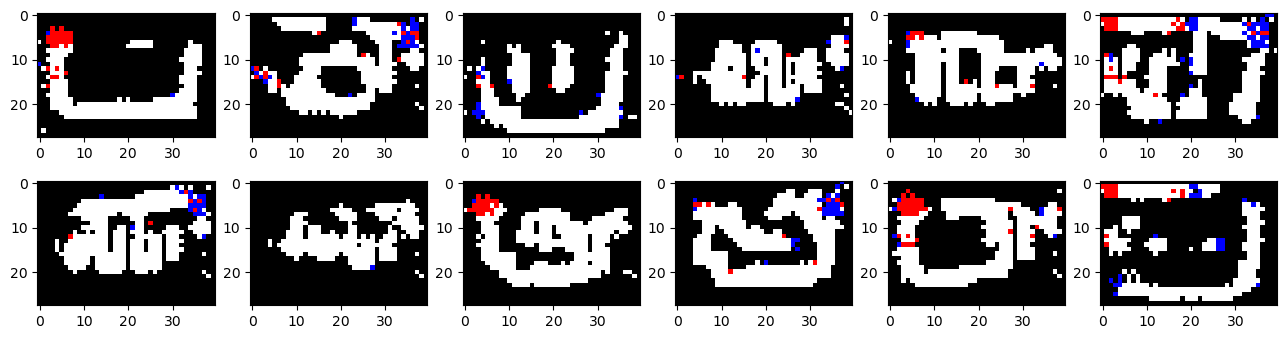

[6701/200]: loss_d: 0.004, loss_g: 7.102
[6702/200]: loss_d: 0.004, loss_g: 7.098
[6703/200]: loss_d: 0.003, loss_g: 7.307
[6704/200]: loss_d: 0.003, loss_g: 7.413
[6705/200]: loss_d: 0.003, loss_g: 7.425
[6706/200]: loss_d: 0.004, loss_g: 6.779
[6707/200]: loss_d: 0.005, loss_g: 6.304
[6708/200]: loss_d: 0.003, loss_g: 7.333
[6709/200]: loss_d: 0.005, loss_g: 6.426
[6710/200]: loss_d: 0.003, loss_g: 7.193
[6711/200]: loss_d: 0.003, loss_g: 7.348
[6712/200]: loss_d: 0.004, loss_g: 6.319
[6713/200]: loss_d: 0.003, loss_g: 7.337
[6714/200]: loss_d: 0.005, loss_g: 6.184
[6715/200]: loss_d: 0.009, loss_g: 6.526
[6716/200]: loss_d: 0.003, loss_g: 7.408
[6717/200]: loss_d: 0.006, loss_g: 6.606
[6718/200]: loss_d: 0.003, loss_g: 8.144
[6719/200]: loss_d: 0.005, loss_g: 6.365
[6720/200]: loss_d: 0.003, loss_g: 7.298
[6721/200]: loss_d: 0.005, loss_g: 6.140
[6722/200]: loss_d: 0.002, loss_g: 7.829
[6723/200]: loss_d: 0.003, loss_g: 7.220
[6724/200]: loss_d: 0.004, loss_g: 6.849
[6725/200]: loss

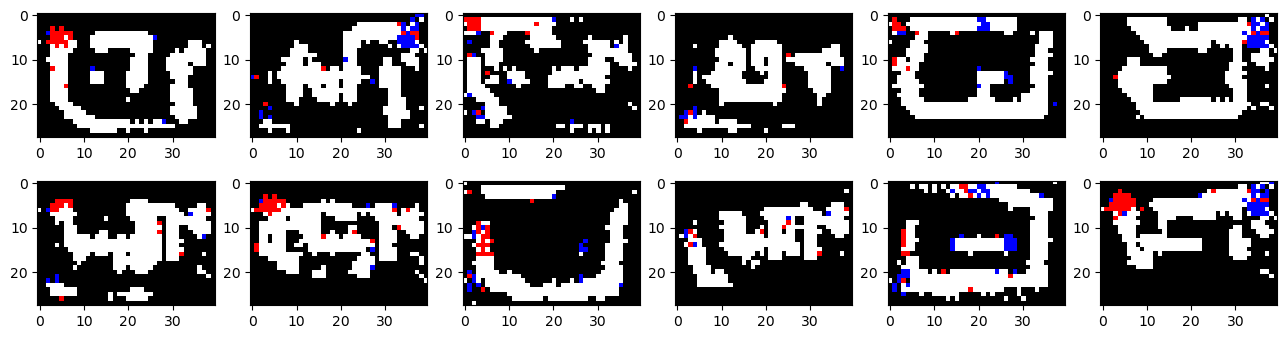

[6801/200]: loss_d: 0.003, loss_g: 6.866
[6802/200]: loss_d: 0.003, loss_g: 6.877
[6803/200]: loss_d: 0.002, loss_g: 7.611
[6804/200]: loss_d: 0.002, loss_g: 7.268
[6805/200]: loss_d: 0.006, loss_g: 6.188
[6806/200]: loss_d: 0.002, loss_g: 7.581
[6807/200]: loss_d: 0.005, loss_g: 6.987
[6808/200]: loss_d: 0.003, loss_g: 7.296
[6809/200]: loss_d: 0.004, loss_g: 7.089
[6810/200]: loss_d: 0.003, loss_g: 7.020
[6811/200]: loss_d: 0.004, loss_g: 6.710
[6812/200]: loss_d: 0.003, loss_g: 6.998
[6813/200]: loss_d: 0.003, loss_g: 7.782
[6814/200]: loss_d: 0.002, loss_g: 7.213
[6815/200]: loss_d: 0.002, loss_g: 7.510
[6816/200]: loss_d: 0.003, loss_g: 7.791
[6817/200]: loss_d: 0.005, loss_g: 6.874
[6818/200]: loss_d: 0.003, loss_g: 7.043
[6819/200]: loss_d: 0.003, loss_g: 7.745
[6820/200]: loss_d: 0.003, loss_g: 7.080
[6821/200]: loss_d: 0.002, loss_g: 7.500
[6822/200]: loss_d: 0.003, loss_g: 6.979
[6823/200]: loss_d: 0.002, loss_g: 7.132
[6824/200]: loss_d: 0.002, loss_g: 7.883
[6825/200]: loss

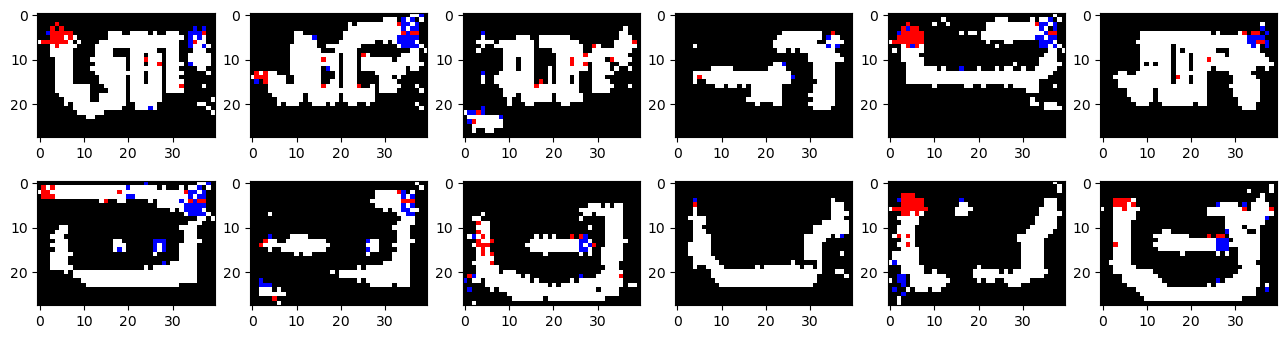

[6901/200]: loss_d: 0.002, loss_g: 7.638
[6902/200]: loss_d: 0.004, loss_g: 7.099
[6903/200]: loss_d: 0.003, loss_g: 6.926
[6904/200]: loss_d: 0.002, loss_g: 7.864
[6905/200]: loss_d: 0.004, loss_g: 6.777
[6906/200]: loss_d: 0.002, loss_g: 7.255
[6907/200]: loss_d: 0.003, loss_g: 7.300
[6908/200]: loss_d: 0.003, loss_g: 7.314
[6909/200]: loss_d: 0.001, loss_g: 8.527
[6910/200]: loss_d: 0.002, loss_g: 7.276
[6911/200]: loss_d: 0.002, loss_g: 7.914
[6912/200]: loss_d: 0.003, loss_g: 7.222
[6913/200]: loss_d: 0.004, loss_g: 6.864
[6914/200]: loss_d: 0.003, loss_g: 7.120
[6915/200]: loss_d: 0.002, loss_g: 7.619
[6916/200]: loss_d: 0.002, loss_g: 7.655
[6917/200]: loss_d: 0.003, loss_g: 7.453
[6918/200]: loss_d: 0.003, loss_g: 7.391
[6919/200]: loss_d: 0.005, loss_g: 6.456
[6920/200]: loss_d: 0.003, loss_g: 7.499
[6921/200]: loss_d: 0.002, loss_g: 7.335
[6922/200]: loss_d: 0.002, loss_g: 7.704
[6923/200]: loss_d: 0.002, loss_g: 7.361
[6924/200]: loss_d: 0.002, loss_g: 8.453
[6925/200]: loss

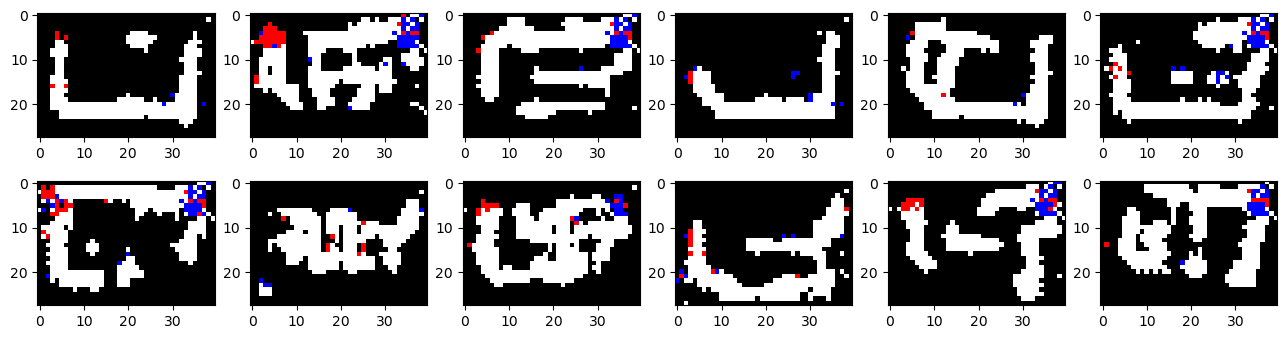

[7001/200]: loss_d: 0.002, loss_g: 8.036
[7002/200]: loss_d: 0.002, loss_g: 7.008
[7003/200]: loss_d: 0.002, loss_g: 7.305
[7004/200]: loss_d: 0.002, loss_g: 8.543
[7005/200]: loss_d: 0.001, loss_g: 7.852
[7006/200]: loss_d: 0.004, loss_g: 6.989
[7007/200]: loss_d: 0.002, loss_g: 7.864
[7008/200]: loss_d: 0.002, loss_g: 8.049
[7009/200]: loss_d: 0.002, loss_g: 8.127
[7010/200]: loss_d: 0.004, loss_g: 7.144
[7011/200]: loss_d: 0.003, loss_g: 7.604
[7012/200]: loss_d: 0.003, loss_g: 7.106
[7013/200]: loss_d: 0.001, loss_g: 8.732
[7014/200]: loss_d: 0.002, loss_g: 7.102
[7015/200]: loss_d: 0.003, loss_g: 7.056
[7016/200]: loss_d: 0.002, loss_g: 7.909
[7017/200]: loss_d: 0.002, loss_g: 7.774
[7018/200]: loss_d: 0.002, loss_g: 7.962
[7019/200]: loss_d: 0.002, loss_g: 7.353
[7020/200]: loss_d: 0.002, loss_g: 7.445
[7021/200]: loss_d: 0.001, loss_g: 8.550
[7022/200]: loss_d: 0.003, loss_g: 6.686
[7023/200]: loss_d: 0.003, loss_g: 7.446
[7024/200]: loss_d: 0.002, loss_g: 8.154
[7025/200]: loss

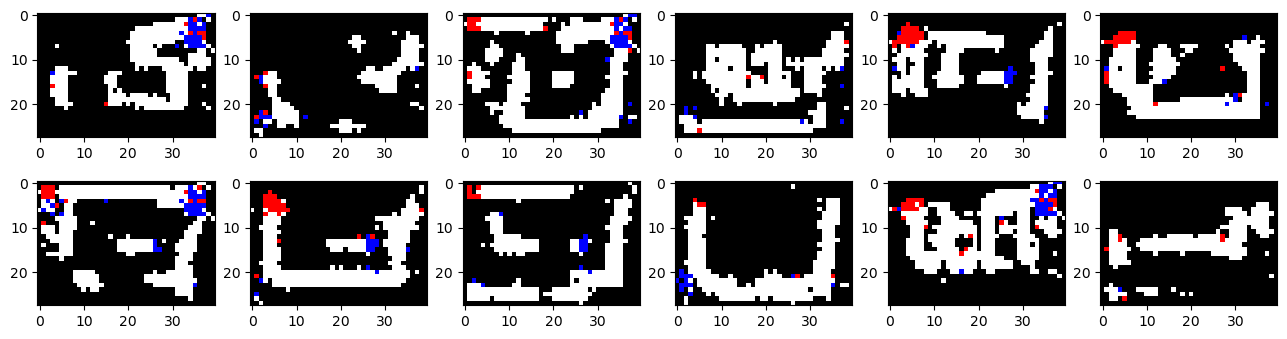

[7101/200]: loss_d: 0.004, loss_g: 7.052
[7102/200]: loss_d: 0.002, loss_g: 7.719
[7103/200]: loss_d: 0.001, loss_g: 8.412
[7104/200]: loss_d: 0.002, loss_g: 7.912
[7105/200]: loss_d: 0.001, loss_g: 8.685
[7106/200]: loss_d: 0.002, loss_g: 7.532
[7107/200]: loss_d: 0.002, loss_g: 8.010
[7108/200]: loss_d: 0.003, loss_g: 7.491
[7109/200]: loss_d: 0.002, loss_g: 7.506
[7110/200]: loss_d: 0.002, loss_g: 6.999
[7111/200]: loss_d: 0.005, loss_g: 7.599
[7112/200]: loss_d: 0.002, loss_g: 8.384
[7113/200]: loss_d: 0.001, loss_g: 8.673
[7114/200]: loss_d: 0.002, loss_g: 7.531
[7115/200]: loss_d: 0.002, loss_g: 7.342
[7116/200]: loss_d: 0.002, loss_g: 8.103
[7117/200]: loss_d: 0.002, loss_g: 7.727
[7118/200]: loss_d: 0.001, loss_g: 8.004
[7119/200]: loss_d: 0.002, loss_g: 7.620
[7120/200]: loss_d: 0.001, loss_g: 7.926
[7121/200]: loss_d: 0.001, loss_g: 8.176
[7122/200]: loss_d: 0.001, loss_g: 7.880
[7123/200]: loss_d: 0.001, loss_g: 8.327
[7124/200]: loss_d: 0.012, loss_g: 6.973
[7125/200]: loss

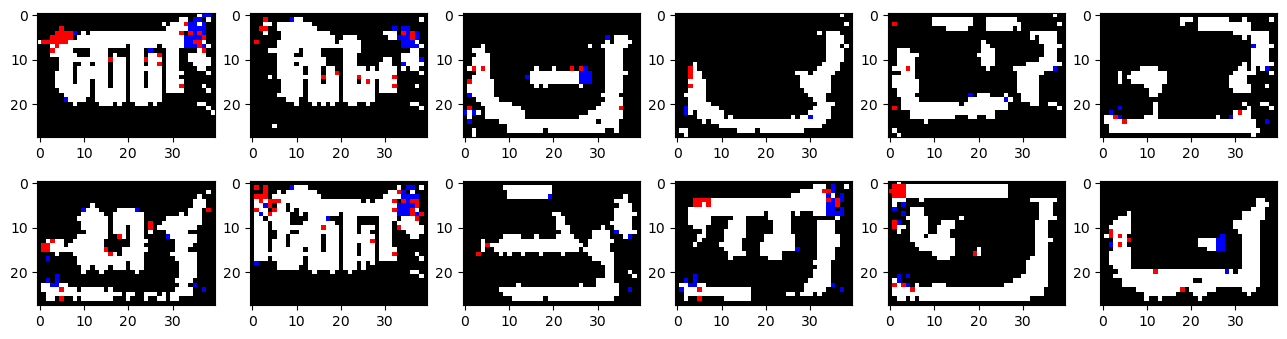

[7201/200]: loss_d: 0.002, loss_g: 7.926
[7202/200]: loss_d: 0.002, loss_g: 8.820
[7203/200]: loss_d: 0.005, loss_g: 6.751
[7204/200]: loss_d: 0.002, loss_g: 8.486
[7205/200]: loss_d: 0.002, loss_g: 8.544
[7206/200]: loss_d: 0.002, loss_g: 7.403
[7207/200]: loss_d: 0.001, loss_g: 8.078
[7208/200]: loss_d: 0.002, loss_g: 7.787
[7209/200]: loss_d: 0.002, loss_g: 8.202
[7210/200]: loss_d: 0.003, loss_g: 7.017
[7211/200]: loss_d: 0.001, loss_g: 8.297
[7212/200]: loss_d: 0.001, loss_g: 8.954
[7213/200]: loss_d: 0.001, loss_g: 8.161
[7214/200]: loss_d: 0.002, loss_g: 7.246
[7215/200]: loss_d: 0.001, loss_g: 8.287
[7216/200]: loss_d: 0.001, loss_g: 8.079
[7217/200]: loss_d: 0.002, loss_g: 7.407
[7218/200]: loss_d: 0.001, loss_g: 7.799
[7219/200]: loss_d: 0.003, loss_g: 7.683
[7220/200]: loss_d: 0.002, loss_g: 8.274
[7221/200]: loss_d: 0.001, loss_g: 7.973
[7222/200]: loss_d: 0.001, loss_g: 8.673
[7223/200]: loss_d: 0.001, loss_g: 8.316
[7224/200]: loss_d: 0.002, loss_g: 7.619
[7225/200]: loss

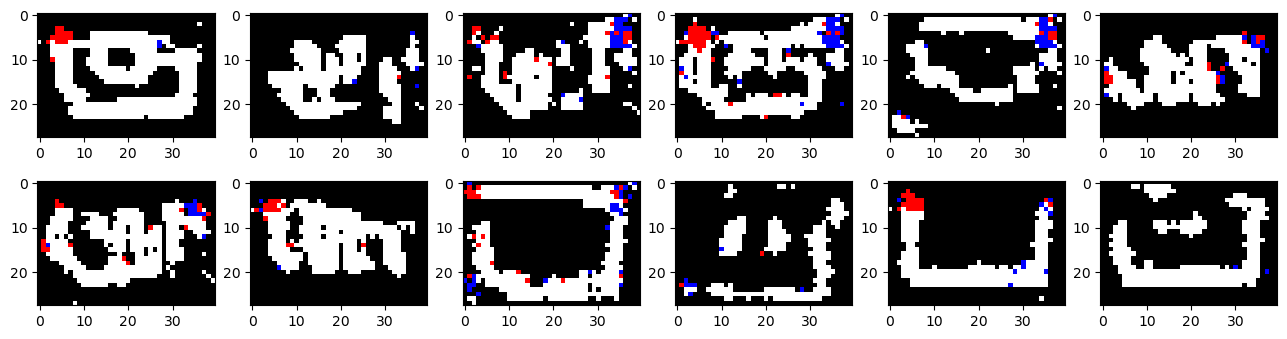

[7301/200]: loss_d: 0.002, loss_g: 7.472
[7302/200]: loss_d: 0.001, loss_g: 8.648
[7303/200]: loss_d: 0.001, loss_g: 9.449
[7304/200]: loss_d: 0.002, loss_g: 7.515
[7305/200]: loss_d: 0.002, loss_g: 8.222
[7306/200]: loss_d: 0.001, loss_g: 7.869
[7307/200]: loss_d: 0.001, loss_g: 7.968
[7308/200]: loss_d: 0.001, loss_g: 9.005
[7309/200]: loss_d: 0.001, loss_g: 8.202
[7310/200]: loss_d: 0.003, loss_g: 7.305
[7311/200]: loss_d: 0.001, loss_g: 8.854
[7312/200]: loss_d: 0.001, loss_g: 7.923
[7313/200]: loss_d: 0.001, loss_g: 8.131
[7314/200]: loss_d: 0.001, loss_g: 9.427
[7315/200]: loss_d: 0.001, loss_g: 8.068
[7316/200]: loss_d: 0.001, loss_g: 8.351
[7317/200]: loss_d: 0.001, loss_g: 8.173
[7318/200]: loss_d: 0.001, loss_g: 8.229
[7319/200]: loss_d: 0.001, loss_g: 8.413
[7320/200]: loss_d: 0.001, loss_g: 8.100
[7321/200]: loss_d: 0.003, loss_g: 7.088
[7322/200]: loss_d: 0.001, loss_g: 9.243
[7323/200]: loss_d: 0.001, loss_g: 8.518
[7324/200]: loss_d: 0.001, loss_g: 8.634
[7325/200]: loss

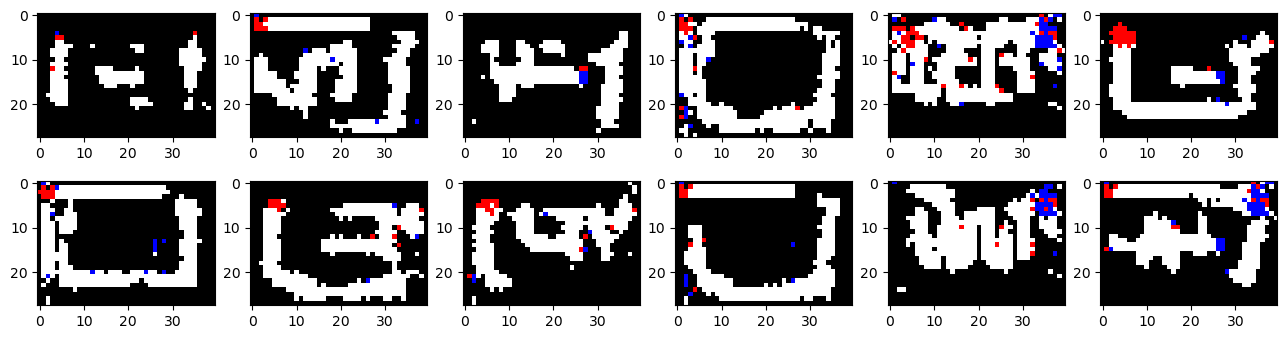

[7401/200]: loss_d: 0.002, loss_g: 7.371
[7402/200]: loss_d: 0.001, loss_g: 8.239
[7403/200]: loss_d: 0.002, loss_g: 7.717
[7404/200]: loss_d: 0.001, loss_g: 8.226
[7405/200]: loss_d: 0.001, loss_g: 7.996
[7406/200]: loss_d: 0.001, loss_g: 9.073
[7407/200]: loss_d: 0.001, loss_g: 9.319
[7408/200]: loss_d: 0.001, loss_g: 7.642
[7409/200]: loss_d: 0.001, loss_g: 8.144
[7410/200]: loss_d: 0.001, loss_g: 8.692
[7411/200]: loss_d: 0.001, loss_g: 7.661
[7412/200]: loss_d: 0.001, loss_g: 9.262
[7413/200]: loss_d: 0.002, loss_g: 7.544
[7414/200]: loss_d: 0.001, loss_g: 8.165
[7415/200]: loss_d: 0.001, loss_g: 8.773
[7416/200]: loss_d: 0.001, loss_g: 7.779
[7417/200]: loss_d: 0.001, loss_g: 8.923
[7418/200]: loss_d: 0.001, loss_g: 8.785
[7419/200]: loss_d: 0.001, loss_g: 8.747
[7420/200]: loss_d: 0.001, loss_g: 8.669
[7421/200]: loss_d: 0.002, loss_g: 7.237
[7422/200]: loss_d: 0.002, loss_g: 7.156
[7423/200]: loss_d: 0.001, loss_g: 8.744
[7424/200]: loss_d: 0.001, loss_g: 8.339
[7425/200]: loss

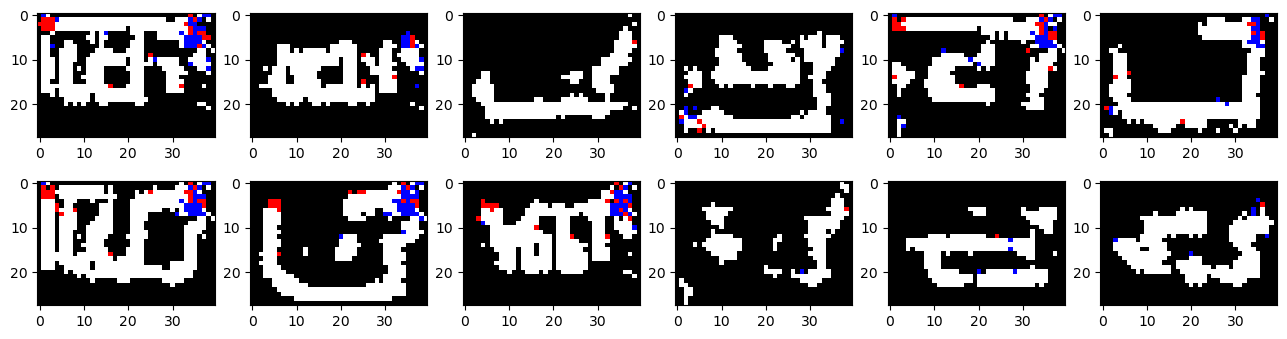

[7501/200]: loss_d: 0.001, loss_g: 7.751
[7502/200]: loss_d: 0.002, loss_g: 7.632
[7503/200]: loss_d: 0.001, loss_g: 7.954
[7504/200]: loss_d: 0.001, loss_g: 8.457
[7505/200]: loss_d: 0.002, loss_g: 7.757
[7506/200]: loss_d: 0.002, loss_g: 7.604
[7507/200]: loss_d: 0.001, loss_g: 8.882
[7508/200]: loss_d: 0.004, loss_g: 7.609
[7509/200]: loss_d: 0.001, loss_g: 8.009
[7510/200]: loss_d: 0.001, loss_g: 8.514
[7511/200]: loss_d: 0.001, loss_g: 8.000
[7512/200]: loss_d: 0.001, loss_g: 9.225
[7513/200]: loss_d: 0.001, loss_g: 8.776
[7514/200]: loss_d: 0.001, loss_g: 8.219
[7515/200]: loss_d: 0.002, loss_g: 7.741
[7516/200]: loss_d: 0.002, loss_g: 7.420
[7517/200]: loss_d: 0.001, loss_g: 8.373
[7518/200]: loss_d: 0.001, loss_g: 8.221
[7519/200]: loss_d: 0.001, loss_g: 8.673
[7520/200]: loss_d: 0.001, loss_g: 8.616
[7521/200]: loss_d: 0.001, loss_g: 8.369
[7522/200]: loss_d: 0.001, loss_g: 8.095
[7523/200]: loss_d: 0.001, loss_g: 8.286
[7524/200]: loss_d: 0.001, loss_g: 7.776
[7525/200]: loss

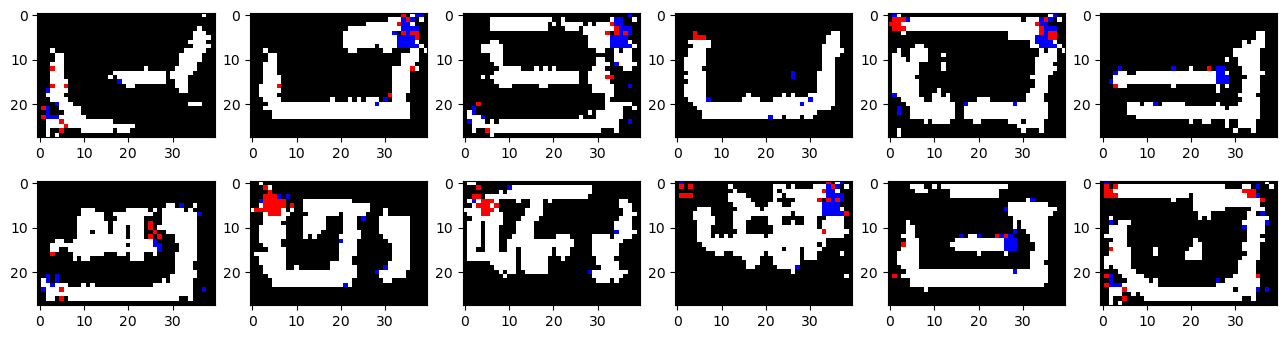

[7601/200]: loss_d: 0.001, loss_g: 8.828
[7602/200]: loss_d: 0.001, loss_g: 7.821
[7603/200]: loss_d: 0.001, loss_g: 9.191
[7604/200]: loss_d: 0.001, loss_g: 7.514
[7605/200]: loss_d: 0.001, loss_g: 7.798
[7606/200]: loss_d: 0.001, loss_g: 8.272
[7607/200]: loss_d: 0.001, loss_g: 8.269
[7608/200]: loss_d: 0.001, loss_g: 7.976
[7609/200]: loss_d: 0.002, loss_g: 7.674
[7610/200]: loss_d: 0.002, loss_g: 7.566
[7611/200]: loss_d: 0.001, loss_g: 8.781
[7612/200]: loss_d: 0.001, loss_g: 8.936
[7613/200]: loss_d: 0.002, loss_g: 7.552
[7614/200]: loss_d: 0.001, loss_g: 8.545
[7615/200]: loss_d: 0.001, loss_g: 8.751
[7616/200]: loss_d: 0.003, loss_g: 7.384
[7617/200]: loss_d: 0.001, loss_g: 8.423
[7618/200]: loss_d: 0.001, loss_g: 9.634
[7619/200]: loss_d: 0.001, loss_g: 8.933
[7620/200]: loss_d: 0.001, loss_g: 8.021
[7621/200]: loss_d: 0.002, loss_g: 7.947
[7622/200]: loss_d: 0.001, loss_g: 9.032
[7623/200]: loss_d: 0.001, loss_g: 8.740
[7624/200]: loss_d: 0.001, loss_g: 8.935
[7625/200]: loss

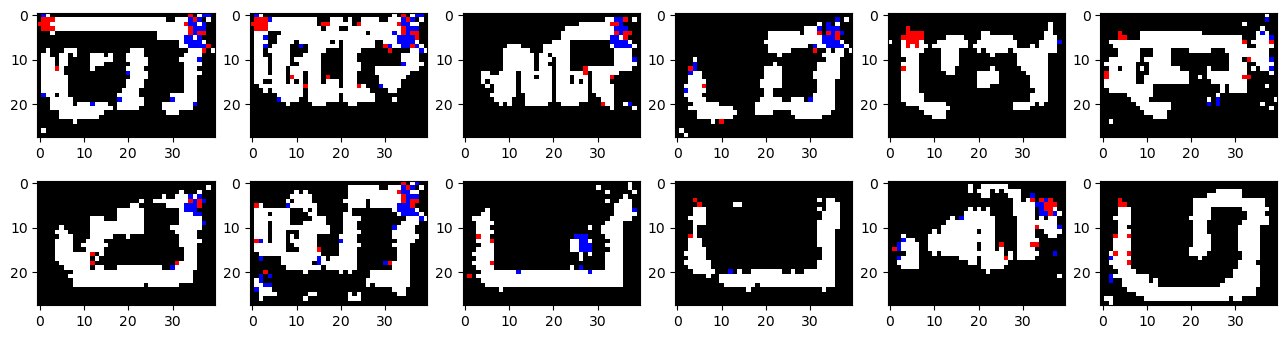

[7701/200]: loss_d: 0.001, loss_g: 8.468
[7702/200]: loss_d: 0.001, loss_g: 8.520
[7703/200]: loss_d: 0.002, loss_g: 8.397
[7704/200]: loss_d: 0.001, loss_g: 8.635
[7705/200]: loss_d: 0.001, loss_g: 9.016
[7706/200]: loss_d: 0.002, loss_g: 8.340
[7707/200]: loss_d: 0.001, loss_g: 8.052
[7708/200]: loss_d: 0.001, loss_g: 8.126
[7709/200]: loss_d: 0.003, loss_g: 7.867
[7710/200]: loss_d: 0.001, loss_g: 8.880
[7711/200]: loss_d: 0.001, loss_g: 8.660
[7712/200]: loss_d: 0.001, loss_g: 8.542
[7713/200]: loss_d: 0.001, loss_g: 8.227
[7714/200]: loss_d: 0.001, loss_g: 8.433
[7715/200]: loss_d: 0.001, loss_g: 8.809
[7716/200]: loss_d: 0.001, loss_g: 8.214
[7717/200]: loss_d: 0.001, loss_g: 9.281
[7718/200]: loss_d: 0.001, loss_g: 9.925
[7719/200]: loss_d: 0.001, loss_g: 8.354
[7720/200]: loss_d: 0.001, loss_g: 9.059
[7721/200]: loss_d: 0.001, loss_g: 8.669
[7722/200]: loss_d: 0.001, loss_g: 8.409
[7723/200]: loss_d: 0.001, loss_g: 8.717
[7724/200]: loss_d: 0.001, loss_g: 8.046
[7725/200]: loss

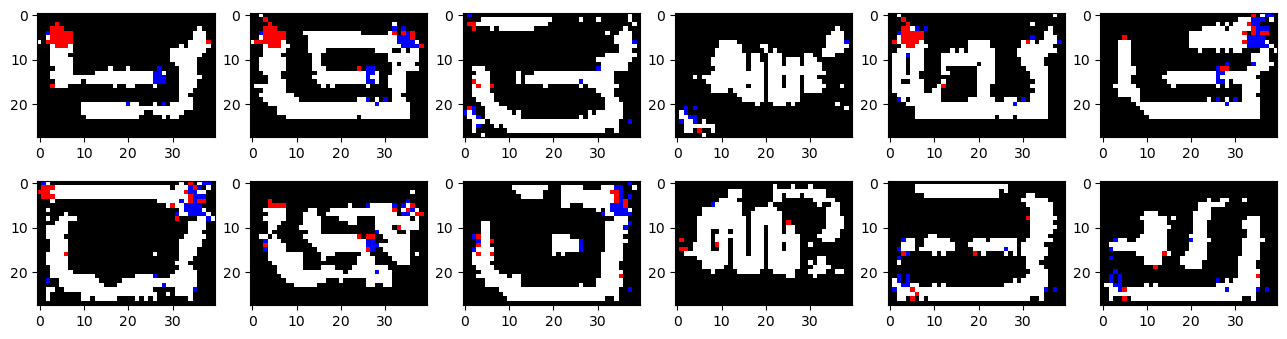

[7801/200]: loss_d: 0.003, loss_g: 7.932
[7802/200]: loss_d: 0.001, loss_g: 8.594
[7803/200]: loss_d: 0.001, loss_g: 9.211
[7804/200]: loss_d: 0.001, loss_g: 8.077
[7805/200]: loss_d: 0.004, loss_g: 6.711
[7806/200]: loss_d: 0.001, loss_g: 10.028
[7807/200]: loss_d: 0.001, loss_g: 10.118
[7808/200]: loss_d: 0.001, loss_g: 9.685
[7809/200]: loss_d: 0.001, loss_g: 8.532
[7810/200]: loss_d: 0.001, loss_g: 8.386
[7811/200]: loss_d: 0.001, loss_g: 8.225
[7812/200]: loss_d: 0.002, loss_g: 8.400
[7813/200]: loss_d: 0.001, loss_g: 9.792
[7814/200]: loss_d: 0.001, loss_g: 10.207
[7815/200]: loss_d: 0.001, loss_g: 7.937
[7816/200]: loss_d: 0.001, loss_g: 8.479
[7817/200]: loss_d: 0.001, loss_g: 8.517
[7818/200]: loss_d: 0.001, loss_g: 7.923
[7819/200]: loss_d: 0.001, loss_g: 8.951
[7820/200]: loss_d: 0.001, loss_g: 8.365
[7821/200]: loss_d: 0.004, loss_g: 7.528
[7822/200]: loss_d: 0.001, loss_g: 8.001
[7823/200]: loss_d: 0.001, loss_g: 8.966
[7824/200]: loss_d: 0.001, loss_g: 9.323
[7825/200]: l

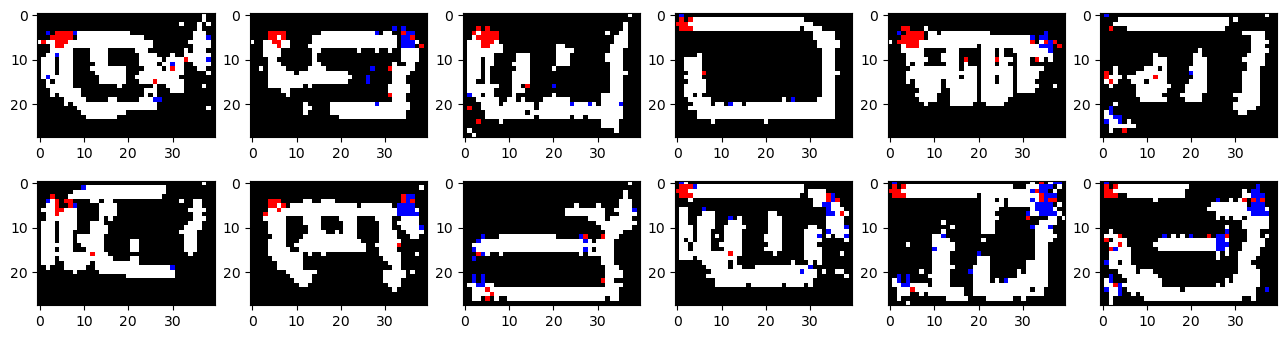

[7901/200]: loss_d: 0.001, loss_g: 8.063
[7902/200]: loss_d: 0.001, loss_g: 9.518
[7903/200]: loss_d: 0.001, loss_g: 9.242
[7904/200]: loss_d: 0.001, loss_g: 8.309
[7905/200]: loss_d: 0.002, loss_g: 7.564
[7906/200]: loss_d: 0.001, loss_g: 8.320
[7907/200]: loss_d: 0.001, loss_g: 8.795
[7908/200]: loss_d: 0.001, loss_g: 8.649
[7909/200]: loss_d: 0.001, loss_g: 9.131
[7910/200]: loss_d: 0.001, loss_g: 9.549
[7911/200]: loss_d: 0.001, loss_g: 8.342
[7912/200]: loss_d: 0.001, loss_g: 7.763
[7913/200]: loss_d: 0.001, loss_g: 8.361
[7914/200]: loss_d: 0.001, loss_g: 9.437
[7915/200]: loss_d: 0.001, loss_g: 8.999
[7916/200]: loss_d: 0.001, loss_g: 9.158
[7917/200]: loss_d: 0.001, loss_g: 9.312
[7918/200]: loss_d: 0.001, loss_g: 9.380
[7919/200]: loss_d: 0.001, loss_g: 9.526
[7920/200]: loss_d: 0.001, loss_g: 8.406
[7921/200]: loss_d: 0.001, loss_g: 7.946
[7922/200]: loss_d: 0.001, loss_g: 8.311
[7923/200]: loss_d: 0.001, loss_g: 9.397
[7924/200]: loss_d: 0.001, loss_g: 9.144
[7925/200]: loss

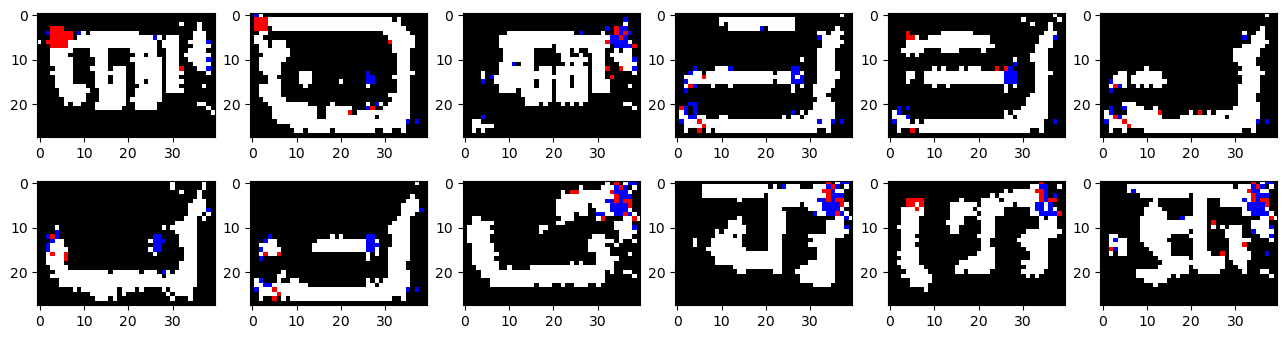

[8001/200]: loss_d: 0.001, loss_g: 8.884
[8002/200]: loss_d: 0.001, loss_g: 8.402
[8003/200]: loss_d: 0.001, loss_g: 8.701
[8004/200]: loss_d: 0.001, loss_g: 8.301
[8005/200]: loss_d: 0.001, loss_g: 8.423
[8006/200]: loss_d: 0.000, loss_g: 10.661
[8007/200]: loss_d: 0.001, loss_g: 8.946
[8008/200]: loss_d: 0.000, loss_g: 10.712
[8009/200]: loss_d: 0.001, loss_g: 8.737
[8010/200]: loss_d: 0.001, loss_g: 9.340
[8011/200]: loss_d: 0.001, loss_g: 8.160
[8012/200]: loss_d: 0.001, loss_g: 8.091
[8013/200]: loss_d: 0.001, loss_g: 8.162
[8014/200]: loss_d: 0.001, loss_g: 9.423
[8015/200]: loss_d: 0.001, loss_g: 8.597
[8016/200]: loss_d: 0.000, loss_g: 9.656
[8017/200]: loss_d: 0.001, loss_g: 8.999
[8018/200]: loss_d: 0.001, loss_g: 8.973
[8019/200]: loss_d: 0.001, loss_g: 9.067
[8020/200]: loss_d: 0.002, loss_g: 7.578
[8021/200]: loss_d: 0.000, loss_g: 9.644
[8022/200]: loss_d: 0.001, loss_g: 8.936
[8023/200]: loss_d: 0.001, loss_g: 9.218
[8024/200]: loss_d: 0.001, loss_g: 8.448
[8025/200]: lo

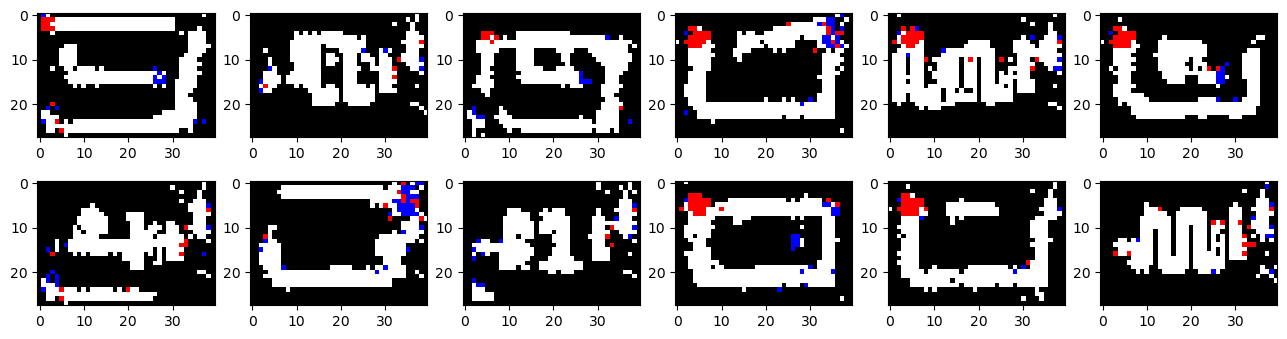

[8101/200]: loss_d: 0.001, loss_g: 8.441
[8102/200]: loss_d: 0.001, loss_g: 8.437
[8103/200]: loss_d: 0.001, loss_g: 9.745
[8104/200]: loss_d: 0.001, loss_g: 9.389
[8105/200]: loss_d: 0.002, loss_g: 8.157
[8106/200]: loss_d: 0.001, loss_g: 8.175
[8107/200]: loss_d: 0.001, loss_g: 8.151
[8108/200]: loss_d: 0.001, loss_g: 9.652
[8109/200]: loss_d: 0.001, loss_g: 8.346
[8110/200]: loss_d: 0.001, loss_g: 8.688
[8111/200]: loss_d: 0.002, loss_g: 7.979
[8112/200]: loss_d: 0.001, loss_g: 8.315
[8113/200]: loss_d: 0.001, loss_g: 8.543
[8114/200]: loss_d: 0.001, loss_g: 8.554
[8115/200]: loss_d: 0.001, loss_g: 9.109
[8116/200]: loss_d: 0.000, loss_g: 9.878
[8117/200]: loss_d: 0.001, loss_g: 9.711
[8118/200]: loss_d: 0.001, loss_g: 9.121
[8119/200]: loss_d: 0.001, loss_g: 8.448
[8120/200]: loss_d: 0.001, loss_g: 8.070
[8121/200]: loss_d: 0.001, loss_g: 9.991
[8122/200]: loss_d: 0.002, loss_g: 7.695
[8123/200]: loss_d: 0.001, loss_g: 9.169
[8124/200]: loss_d: 0.001, loss_g: 7.785
[8125/200]: loss

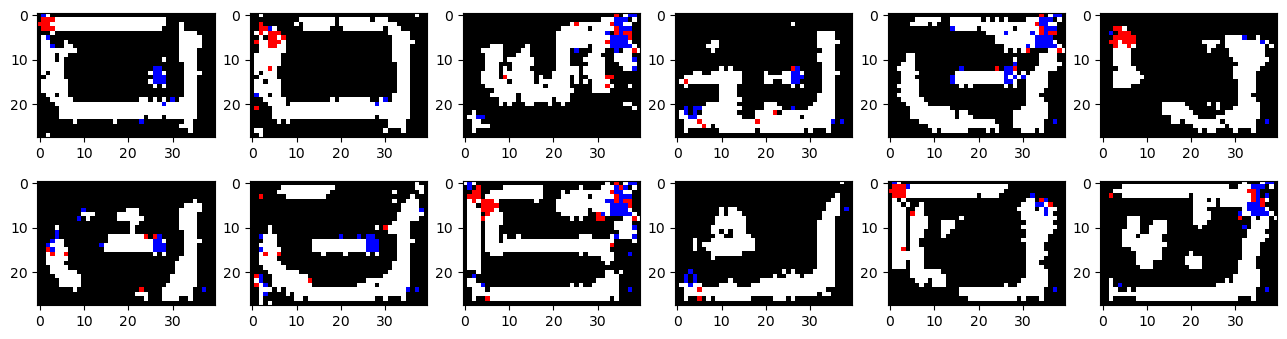

[8201/200]: loss_d: 0.001, loss_g: 9.598
[8202/200]: loss_d: 0.001, loss_g: 9.191
[8203/200]: loss_d: 0.001, loss_g: 9.359
[8204/200]: loss_d: 0.002, loss_g: 8.432
[8205/200]: loss_d: 0.001, loss_g: 8.642
[8206/200]: loss_d: 0.001, loss_g: 8.173
[8207/200]: loss_d: 0.001, loss_g: 8.627
[8208/200]: loss_d: 0.001, loss_g: 8.723
[8209/200]: loss_d: 0.003, loss_g: 7.827
[8210/200]: loss_d: 0.001, loss_g: 9.220
[8211/200]: loss_d: 0.001, loss_g: 8.978
[8212/200]: loss_d: 0.001, loss_g: 9.180
[8213/200]: loss_d: 0.001, loss_g: 9.017
[8214/200]: loss_d: 0.000, loss_g: 9.683
[8215/200]: loss_d: 0.001, loss_g: 9.351
[8216/200]: loss_d: 0.001, loss_g: 8.733
[8217/200]: loss_d: 0.001, loss_g: 8.515
[8218/200]: loss_d: 0.000, loss_g: 8.903
[8219/200]: loss_d: 0.001, loss_g: 8.867
[8220/200]: loss_d: 0.001, loss_g: 8.506
[8221/200]: loss_d: 0.001, loss_g: 8.420
[8222/200]: loss_d: 0.000, loss_g: 9.672
[8223/200]: loss_d: 0.001, loss_g: 8.644
[8224/200]: loss_d: 0.001, loss_g: 8.727
[8225/200]: loss

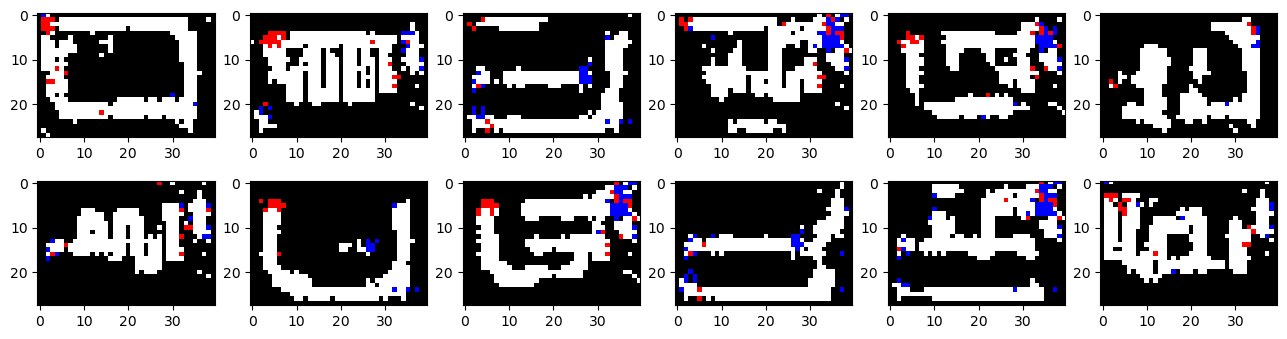

[8301/200]: loss_d: 0.001, loss_g: 9.457
[8302/200]: loss_d: 0.001, loss_g: 9.335
[8303/200]: loss_d: 0.001, loss_g: 8.615
[8304/200]: loss_d: 0.000, loss_g: 9.662
[8305/200]: loss_d: 0.001, loss_g: 9.460
[8306/200]: loss_d: 0.001, loss_g: 9.349
[8307/200]: loss_d: 0.001, loss_g: 9.126
[8308/200]: loss_d: 0.001, loss_g: 8.528
[8309/200]: loss_d: 0.001, loss_g: 9.506
[8310/200]: loss_d: 0.001, loss_g: 8.198
[8311/200]: loss_d: 0.003, loss_g: 7.837
[8312/200]: loss_d: 0.001, loss_g: 8.236
[8313/200]: loss_d: 0.001, loss_g: 8.833
[8314/200]: loss_d: 0.001, loss_g: 9.415
[8315/200]: loss_d: 0.001, loss_g: 8.276
[8316/200]: loss_d: 0.002, loss_g: 7.743
[8317/200]: loss_d: 0.001, loss_g: 9.179
[8318/200]: loss_d: 0.001, loss_g: 9.856
[8319/200]: loss_d: 0.002, loss_g: 7.530
[8320/200]: loss_d: 0.001, loss_g: 9.111
[8321/200]: loss_d: 0.001, loss_g: 8.573
[8322/200]: loss_d: 0.001, loss_g: 7.761
[8323/200]: loss_d: 0.001, loss_g: 8.744
[8324/200]: loss_d: 0.001, loss_g: 8.971
[8325/200]: loss

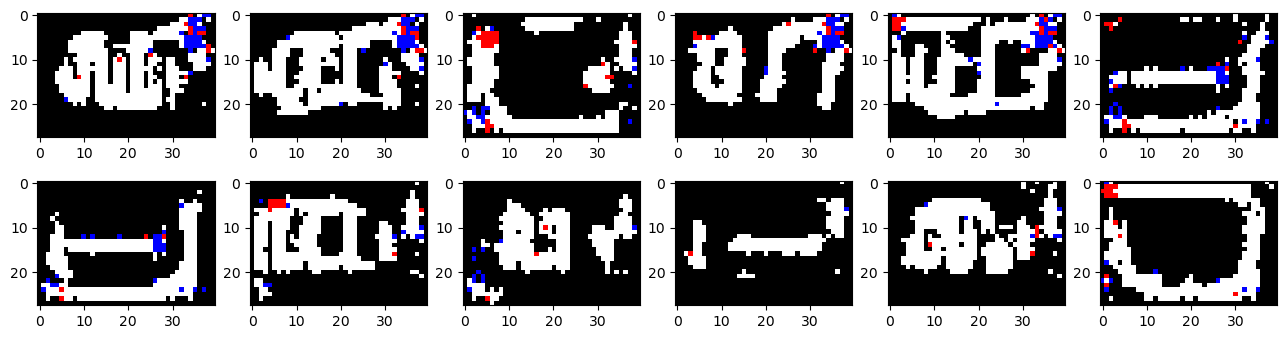

[8401/200]: loss_d: 0.001, loss_g: 8.076
[8402/200]: loss_d: 0.001, loss_g: 7.997
[8403/200]: loss_d: 0.001, loss_g: 8.741
[8404/200]: loss_d: 0.001, loss_g: 7.980
[8405/200]: loss_d: 0.001, loss_g: 8.715
[8406/200]: loss_d: 0.001, loss_g: 8.070
[8407/200]: loss_d: 0.001, loss_g: 8.964
[8408/200]: loss_d: 0.001, loss_g: 8.992
[8409/200]: loss_d: 0.001, loss_g: 8.837
[8410/200]: loss_d: 0.002, loss_g: 7.535
[8411/200]: loss_d: 0.001, loss_g: 9.150
[8412/200]: loss_d: 0.001, loss_g: 8.411
[8413/200]: loss_d: 0.000, loss_g: 10.632
[8414/200]: loss_d: 0.001, loss_g: 9.725
[8415/200]: loss_d: 0.001, loss_g: 9.074
[8416/200]: loss_d: 0.001, loss_g: 8.131
[8417/200]: loss_d: 0.000, loss_g: 9.537
[8418/200]: loss_d: 0.001, loss_g: 8.366
[8419/200]: loss_d: 0.001, loss_g: 8.513
[8420/200]: loss_d: 0.000, loss_g: 10.100
[8421/200]: loss_d: 0.001, loss_g: 8.811
[8422/200]: loss_d: 0.001, loss_g: 9.144
[8423/200]: loss_d: 0.001, loss_g: 9.001
[8424/200]: loss_d: 0.001, loss_g: 8.091
[8425/200]: lo

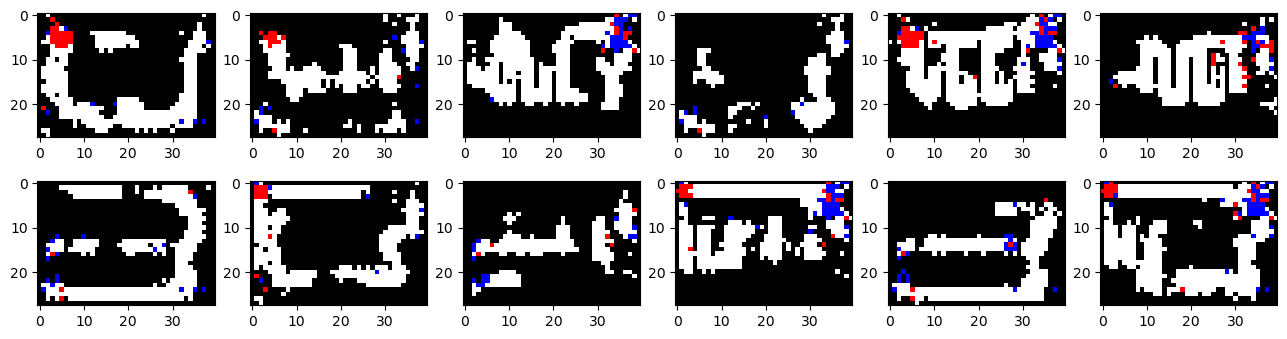

[8501/200]: loss_d: 0.001, loss_g: 8.059
[8502/200]: loss_d: 0.001, loss_g: 8.373
[8503/200]: loss_d: 0.001, loss_g: 8.932
[8504/200]: loss_d: 0.001, loss_g: 8.129
[8505/200]: loss_d: 0.001, loss_g: 9.889
[8506/200]: loss_d: 0.001, loss_g: 9.034
[8507/200]: loss_d: 0.001, loss_g: 8.834
[8508/200]: loss_d: 0.001, loss_g: 8.415
[8509/200]: loss_d: 0.001, loss_g: 8.417
[8510/200]: loss_d: 0.001, loss_g: 8.601
[8511/200]: loss_d: 0.001, loss_g: 9.460
[8512/200]: loss_d: 0.001, loss_g: 9.285
[8513/200]: loss_d: 0.001, loss_g: 8.917
[8514/200]: loss_d: 0.001, loss_g: 8.682
[8515/200]: loss_d: 0.001, loss_g: 8.537
[8516/200]: loss_d: 0.001, loss_g: 8.608
[8517/200]: loss_d: 0.002, loss_g: 7.752
[8518/200]: loss_d: 0.001, loss_g: 9.362
[8519/200]: loss_d: 0.001, loss_g: 8.798
[8520/200]: loss_d: 0.001, loss_g: 8.711
[8521/200]: loss_d: 0.001, loss_g: 8.072
[8522/200]: loss_d: 0.000, loss_g: 9.159
[8523/200]: loss_d: 0.001, loss_g: 8.302
[8524/200]: loss_d: 0.001, loss_g: 8.277
[8525/200]: loss

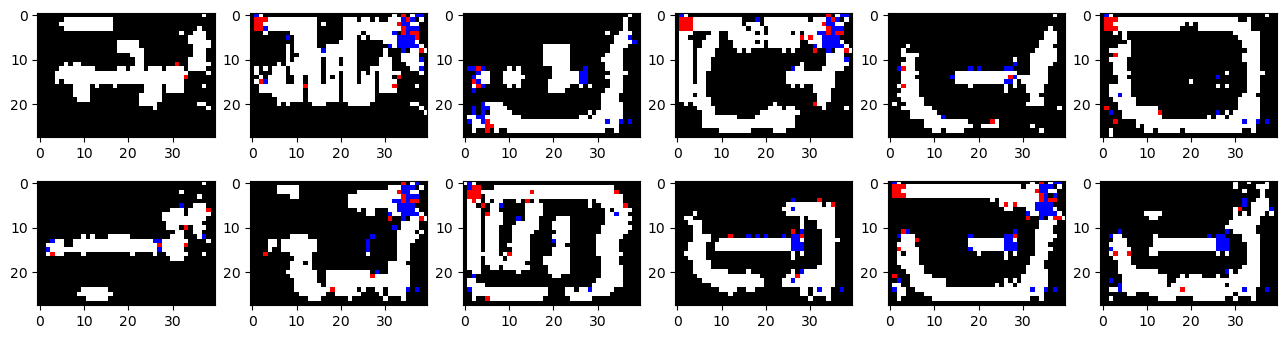

[8601/200]: loss_d: 0.001, loss_g: 8.696
[8602/200]: loss_d: 0.002, loss_g: 8.045
[8603/200]: loss_d: 0.001, loss_g: 9.832
[8604/200]: loss_d: 0.000, loss_g: 10.318
[8605/200]: loss_d: 0.001, loss_g: 9.353
[8606/200]: loss_d: 0.000, loss_g: 9.324
[8607/200]: loss_d: 0.001, loss_g: 7.942
[8608/200]: loss_d: 0.000, loss_g: 9.159
[8609/200]: loss_d: 0.000, loss_g: 9.856
[8610/200]: loss_d: 0.003, loss_g: 8.409
[8611/200]: loss_d: 0.001, loss_g: 9.258
[8612/200]: loss_d: 0.001, loss_g: 8.714
[8613/200]: loss_d: 0.001, loss_g: 9.781
[8614/200]: loss_d: 0.001, loss_g: 8.956
[8615/200]: loss_d: 0.001, loss_g: 9.297
[8616/200]: loss_d: 0.001, loss_g: 9.264
[8617/200]: loss_d: 0.001, loss_g: 8.092
[8618/200]: loss_d: 0.001, loss_g: 8.979
[8619/200]: loss_d: 0.001, loss_g: 9.062
[8620/200]: loss_d: 0.001, loss_g: 9.070
[8621/200]: loss_d: 0.001, loss_g: 9.021
[8622/200]: loss_d: 0.001, loss_g: 8.628
[8623/200]: loss_d: 0.001, loss_g: 8.238
[8624/200]: loss_d: 0.000, loss_g: 10.050
[8625/200]: lo

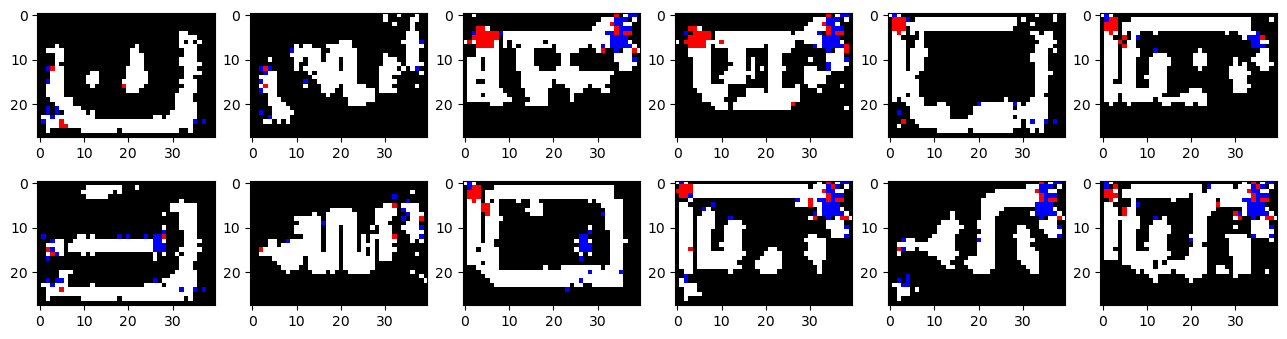

[8701/200]: loss_d: 0.001, loss_g: 8.620
[8702/200]: loss_d: 0.001, loss_g: 8.237
[8703/200]: loss_d: 0.001, loss_g: 8.469
[8704/200]: loss_d: 0.001, loss_g: 8.229
[8705/200]: loss_d: 0.001, loss_g: 8.968
[8706/200]: loss_d: 0.001, loss_g: 9.860
[8707/200]: loss_d: 0.001, loss_g: 8.699
[8708/200]: loss_d: 0.000, loss_g: 9.603
[8709/200]: loss_d: 0.000, loss_g: 10.015
[8710/200]: loss_d: 0.000, loss_g: 9.333
[8711/200]: loss_d: 0.001, loss_g: 7.466
[8712/200]: loss_d: 0.000, loss_g: 9.195
[8713/200]: loss_d: 0.001, loss_g: 8.984
[8714/200]: loss_d: 0.001, loss_g: 8.887
[8715/200]: loss_d: 0.001, loss_g: 8.661
[8716/200]: loss_d: 0.001, loss_g: 9.219
[8717/200]: loss_d: 0.001, loss_g: 7.852
[8718/200]: loss_d: 0.001, loss_g: 8.488
[8719/200]: loss_d: 0.000, loss_g: 9.766
[8720/200]: loss_d: 0.001, loss_g: 8.641
[8721/200]: loss_d: 0.000, loss_g: 10.633
[8722/200]: loss_d: 0.000, loss_g: 9.503
[8723/200]: loss_d: 0.001, loss_g: 9.333
[8724/200]: loss_d: 0.000, loss_g: 9.279
[8725/200]: lo

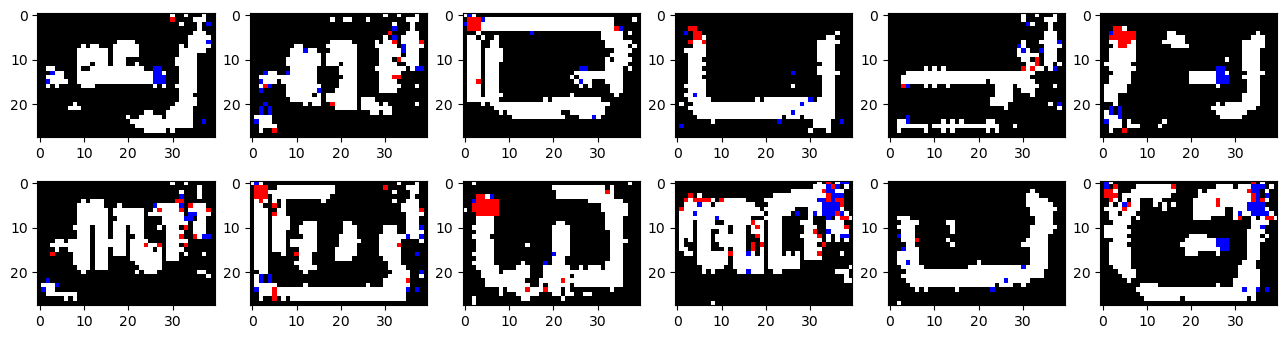

[8801/200]: loss_d: 0.001, loss_g: 9.319
[8802/200]: loss_d: 0.001, loss_g: 8.470
[8803/200]: loss_d: 0.001, loss_g: 8.997
[8804/200]: loss_d: 0.000, loss_g: 9.379
[8805/200]: loss_d: 0.000, loss_g: 10.095
[8806/200]: loss_d: 0.001, loss_g: 8.405
[8807/200]: loss_d: 0.001, loss_g: 8.312
[8808/200]: loss_d: 0.001, loss_g: 8.689
[8809/200]: loss_d: 0.001, loss_g: 9.300
[8810/200]: loss_d: 0.000, loss_g: 10.208
[8811/200]: loss_d: 0.001, loss_g: 8.740
[8812/200]: loss_d: 0.001, loss_g: 8.807
[8813/200]: loss_d: 0.001, loss_g: 9.085
[8814/200]: loss_d: 0.001, loss_g: 8.144
[8815/200]: loss_d: 0.001, loss_g: 8.581
[8816/200]: loss_d: 0.001, loss_g: 8.303
[8817/200]: loss_d: 0.001, loss_g: 9.230
[8818/200]: loss_d: 0.001, loss_g: 8.746
[8819/200]: loss_d: 0.001, loss_g: 8.555
[8820/200]: loss_d: 0.001, loss_g: 7.930
[8821/200]: loss_d: 0.000, loss_g: 10.140
[8822/200]: loss_d: 0.001, loss_g: 8.763
[8823/200]: loss_d: 0.001, loss_g: 8.595
[8824/200]: loss_d: 0.000, loss_g: 10.104
[8825/200]: 

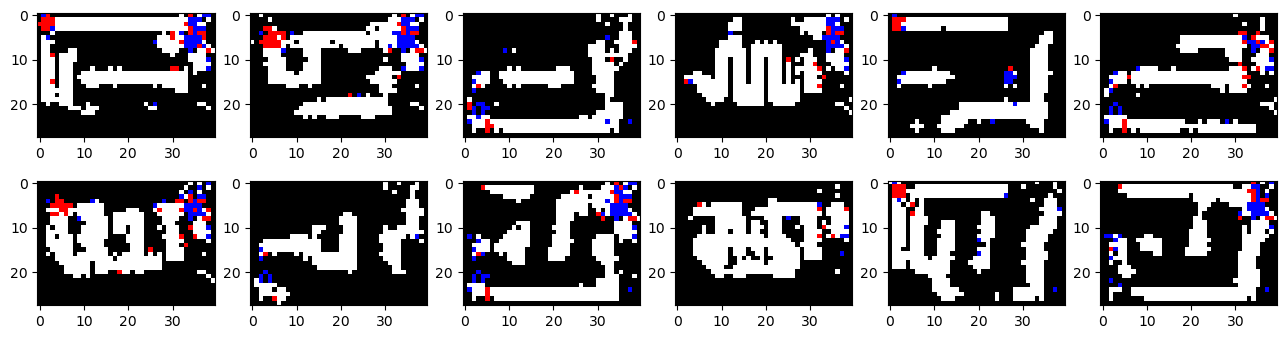

[8901/200]: loss_d: 0.001, loss_g: 9.349
[8902/200]: loss_d: 0.000, loss_g: 9.918
[8903/200]: loss_d: 0.000, loss_g: 10.342
[8904/200]: loss_d: 0.000, loss_g: 9.322
[8905/200]: loss_d: 0.001, loss_g: 8.804
[8906/200]: loss_d: 0.001, loss_g: 8.901
[8907/200]: loss_d: 0.001, loss_g: 8.994
[8908/200]: loss_d: 0.001, loss_g: 8.502
[8909/200]: loss_d: 0.001, loss_g: 7.730
[8910/200]: loss_d: 0.001, loss_g: 9.690
[8911/200]: loss_d: 0.001, loss_g: 8.246
[8912/200]: loss_d: 0.001, loss_g: 9.442
[8913/200]: loss_d: 0.001, loss_g: 9.644
[8914/200]: loss_d: 0.001, loss_g: 8.488
[8915/200]: loss_d: 0.000, loss_g: 9.980
[8916/200]: loss_d: 0.001, loss_g: 8.181
[8917/200]: loss_d: 0.001, loss_g: 8.017
[8918/200]: loss_d: 0.001, loss_g: 9.583
[8919/200]: loss_d: 0.000, loss_g: 10.205
[8920/200]: loss_d: 0.001, loss_g: 8.708
[8921/200]: loss_d: 0.001, loss_g: 9.203
[8922/200]: loss_d: 0.001, loss_g: 8.740
[8923/200]: loss_d: 0.001, loss_g: 9.419
[8924/200]: loss_d: 0.001, loss_g: 7.947
[8925/200]: lo

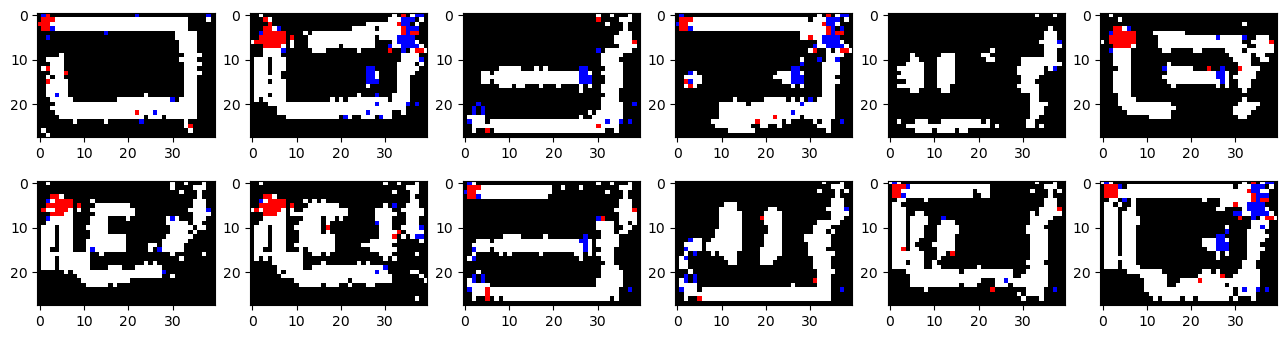

[9001/200]: loss_d: 0.001, loss_g: 8.178
[9002/200]: loss_d: 0.001, loss_g: 8.957
[9003/200]: loss_d: 0.000, loss_g: 9.716
[9004/200]: loss_d: 0.001, loss_g: 8.755
[9005/200]: loss_d: 0.001, loss_g: 8.928
[9006/200]: loss_d: 0.001, loss_g: 9.422
[9007/200]: loss_d: 0.001, loss_g: 9.630
[9008/200]: loss_d: 0.001, loss_g: 9.060
[9009/200]: loss_d: 0.001, loss_g: 8.808
[9010/200]: loss_d: 0.000, loss_g: 9.640
[9011/200]: loss_d: 0.001, loss_g: 8.465
[9012/200]: loss_d: 0.000, loss_g: 9.400
[9013/200]: loss_d: 0.000, loss_g: 9.052
[9014/200]: loss_d: 0.000, loss_g: 9.109
[9015/200]: loss_d: 0.000, loss_g: 9.359
[9016/200]: loss_d: 0.001, loss_g: 8.746
[9017/200]: loss_d: 0.001, loss_g: 8.618
[9018/200]: loss_d: 0.001, loss_g: 8.100
[9019/200]: loss_d: 0.000, loss_g: 9.656
[9020/200]: loss_d: 0.001, loss_g: 9.064
[9021/200]: loss_d: 0.000, loss_g: 9.285
[9022/200]: loss_d: 0.000, loss_g: 10.065
[9023/200]: loss_d: 0.000, loss_g: 9.677
[9024/200]: loss_d: 0.000, loss_g: 8.744
[9025/200]: los

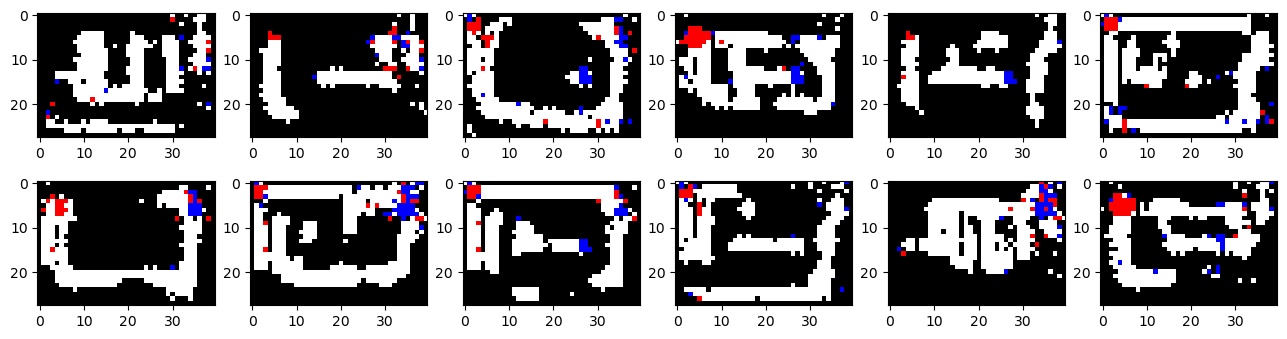

[9101/200]: loss_d: 0.001, loss_g: 9.114
[9102/200]: loss_d: 0.000, loss_g: 9.610
[9103/200]: loss_d: 0.001, loss_g: 9.016
[9104/200]: loss_d: 0.000, loss_g: 10.569
[9105/200]: loss_d: 0.000, loss_g: 9.694
[9106/200]: loss_d: 0.000, loss_g: 8.964
[9107/200]: loss_d: 0.001, loss_g: 8.611
[9108/200]: loss_d: 0.000, loss_g: 9.510
[9109/200]: loss_d: 0.001, loss_g: 8.051
[9110/200]: loss_d: 0.001, loss_g: 8.821
[9111/200]: loss_d: 0.000, loss_g: 10.224
[9112/200]: loss_d: 0.001, loss_g: 8.444
[9113/200]: loss_d: 0.001, loss_g: 8.704
[9114/200]: loss_d: 0.000, loss_g: 9.275
[9115/200]: loss_d: 0.001, loss_g: 8.764
[9116/200]: loss_d: 0.000, loss_g: 9.461
[9117/200]: loss_d: 0.000, loss_g: 10.082
[9118/200]: loss_d: 0.000, loss_g: 9.979
[9119/200]: loss_d: 0.001, loss_g: 8.706
[9120/200]: loss_d: 0.000, loss_g: 9.270
[9121/200]: loss_d: 0.000, loss_g: 8.986
[9122/200]: loss_d: 0.000, loss_g: 9.949
[9123/200]: loss_d: 0.000, loss_g: 10.311
[9124/200]: loss_d: 0.000, loss_g: 10.626
[9125/200]:

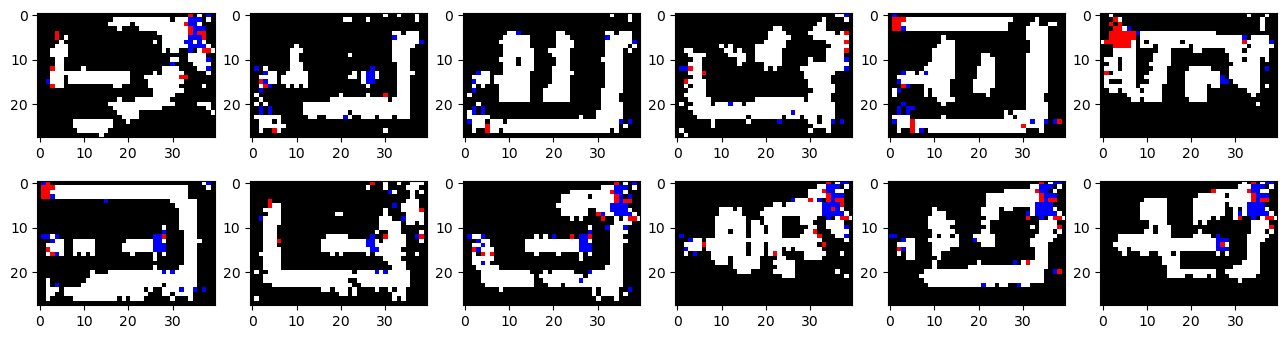

[9201/200]: loss_d: 0.000, loss_g: 9.414
[9202/200]: loss_d: 0.001, loss_g: 7.283
[9203/200]: loss_d: 0.001, loss_g: 7.944
[9204/200]: loss_d: 0.000, loss_g: 9.752
[9205/200]: loss_d: 0.000, loss_g: 8.985
[9206/200]: loss_d: 0.001, loss_g: 9.311
[9207/200]: loss_d: 0.001, loss_g: 9.178
[9208/200]: loss_d: 0.001, loss_g: 8.643
[9209/200]: loss_d: 0.000, loss_g: 9.915
[9210/200]: loss_d: 0.000, loss_g: 9.734
[9211/200]: loss_d: 0.001, loss_g: 8.815
[9212/200]: loss_d: 0.002, loss_g: 7.579
[9213/200]: loss_d: 0.000, loss_g: 9.401
[9214/200]: loss_d: 0.000, loss_g: 10.112
[9215/200]: loss_d: 0.000, loss_g: 9.181
[9216/200]: loss_d: 0.000, loss_g: 10.809
[9217/200]: loss_d: 0.001, loss_g: 8.400
[9218/200]: loss_d: 0.001, loss_g: 7.989
[9219/200]: loss_d: 0.000, loss_g: 9.835
[9220/200]: loss_d: 0.001, loss_g: 8.583
[9221/200]: loss_d: 0.001, loss_g: 8.749
[9222/200]: loss_d: 0.000, loss_g: 10.320
[9223/200]: loss_d: 0.000, loss_g: 10.673
[9224/200]: loss_d: 0.000, loss_g: 9.744
[9225/200]: 

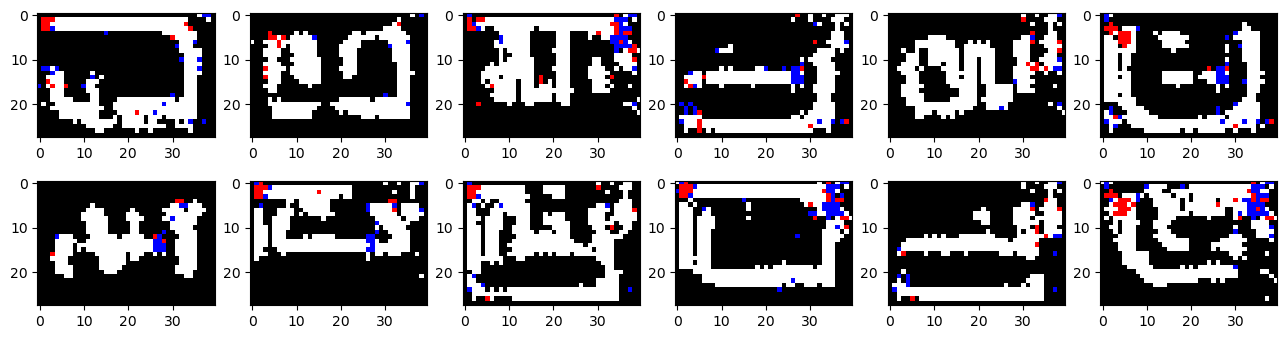

[9301/200]: loss_d: 0.000, loss_g: 9.495
[9302/200]: loss_d: 0.000, loss_g: 9.468
[9303/200]: loss_d: 0.001, loss_g: 7.865
[9304/200]: loss_d: 0.000, loss_g: 9.752
[9305/200]: loss_d: 0.001, loss_g: 8.913
[9306/200]: loss_d: 0.001, loss_g: 9.426
[9307/200]: loss_d: 0.000, loss_g: 9.501
[9308/200]: loss_d: 0.000, loss_g: 9.290
[9309/200]: loss_d: 0.000, loss_g: 10.083
[9310/200]: loss_d: 0.000, loss_g: 9.562
[9311/200]: loss_d: 0.000, loss_g: 9.721
[9312/200]: loss_d: 0.001, loss_g: 8.638
[9313/200]: loss_d: 0.000, loss_g: 9.599
[9314/200]: loss_d: 0.001, loss_g: 8.933
[9315/200]: loss_d: 0.001, loss_g: 8.849
[9316/200]: loss_d: 0.000, loss_g: 10.027
[9317/200]: loss_d: 0.000, loss_g: 9.161
[9318/200]: loss_d: 0.000, loss_g: 9.553
[9319/200]: loss_d: 0.000, loss_g: 9.300
[9320/200]: loss_d: 0.000, loss_g: 10.252
[9321/200]: loss_d: 0.000, loss_g: 9.040
[9322/200]: loss_d: 0.001, loss_g: 8.166
[9323/200]: loss_d: 0.000, loss_g: 9.697
[9324/200]: loss_d: 0.000, loss_g: 9.929
[9325/200]: l

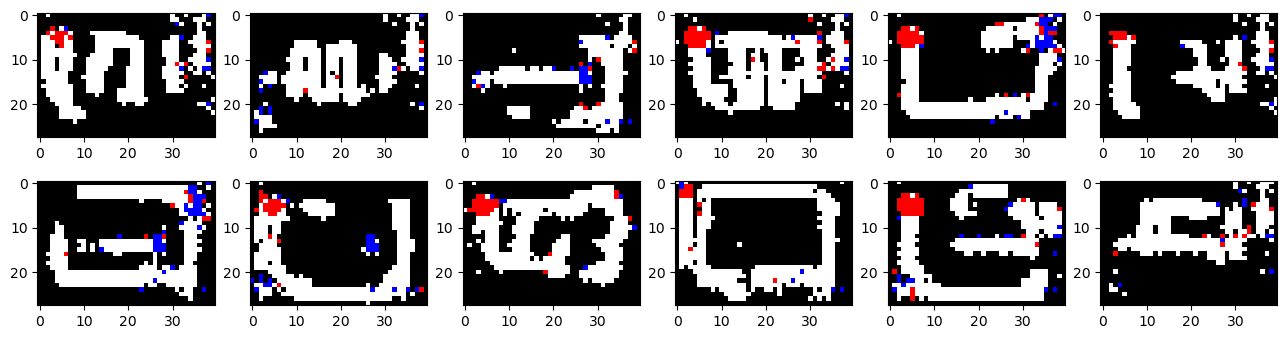

[9401/200]: loss_d: 0.000, loss_g: 9.334
[9402/200]: loss_d: 0.000, loss_g: 9.645
[9403/200]: loss_d: 0.001, loss_g: 9.023
[9404/200]: loss_d: 0.000, loss_g: 9.879
[9405/200]: loss_d: 0.000, loss_g: 8.864
[9406/200]: loss_d: 0.000, loss_g: 9.942
[9407/200]: loss_d: 0.000, loss_g: 8.887
[9408/200]: loss_d: 0.001, loss_g: 8.923
[9409/200]: loss_d: 0.000, loss_g: 9.738
[9410/200]: loss_d: 0.000, loss_g: 9.490
[9411/200]: loss_d: 0.001, loss_g: 8.874
[9412/200]: loss_d: 0.001, loss_g: 9.066
[9413/200]: loss_d: 0.000, loss_g: 9.087
[9414/200]: loss_d: 0.000, loss_g: 10.448
[9415/200]: loss_d: 0.000, loss_g: 10.190
[9416/200]: loss_d: 0.001, loss_g: 9.046
[9417/200]: loss_d: 0.001, loss_g: 8.524
[9418/200]: loss_d: 0.000, loss_g: 10.171
[9419/200]: loss_d: 0.001, loss_g: 8.288
[9420/200]: loss_d: 0.001, loss_g: 8.176
[9421/200]: loss_d: 0.000, loss_g: 10.709
[9422/200]: loss_d: 0.000, loss_g: 9.754
[9423/200]: loss_d: 0.000, loss_g: 10.714
[9424/200]: loss_d: 0.000, loss_g: 9.806
[9425/200]:

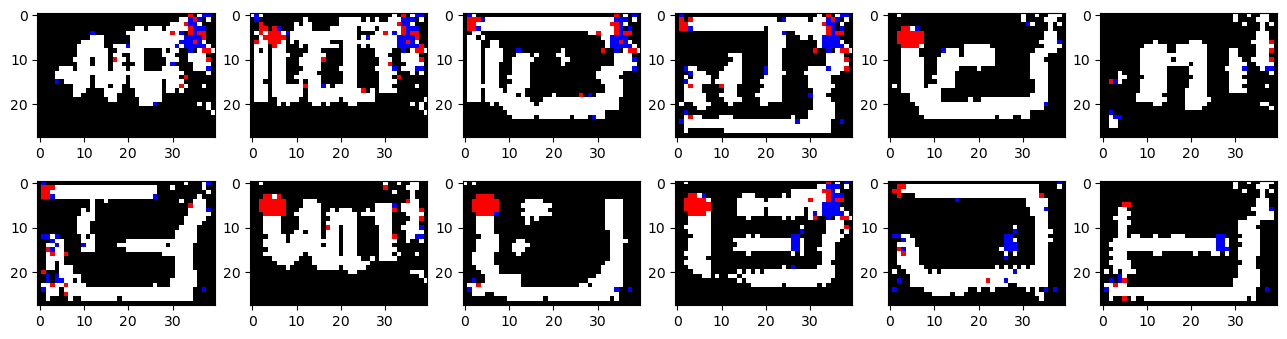

[9501/200]: loss_d: 0.001, loss_g: 9.078
[9502/200]: loss_d: 0.000, loss_g: 10.104
[9503/200]: loss_d: 0.000, loss_g: 9.645
[9504/200]: loss_d: 0.000, loss_g: 8.896
[9505/200]: loss_d: 0.000, loss_g: 9.512
[9506/200]: loss_d: 0.000, loss_g: 9.872
[9507/200]: loss_d: 0.000, loss_g: 10.228
[9508/200]: loss_d: 0.001, loss_g: 8.078
[9509/200]: loss_d: 0.000, loss_g: 10.611
[9510/200]: loss_d: 0.001, loss_g: 9.835
[9511/200]: loss_d: 0.001, loss_g: 8.804
[9512/200]: loss_d: 0.000, loss_g: 9.925
[9513/200]: loss_d: 0.000, loss_g: 10.798
[9514/200]: loss_d: 0.001, loss_g: 8.805
[9515/200]: loss_d: 0.000, loss_g: 9.886
[9516/200]: loss_d: 0.001, loss_g: 8.276
[9517/200]: loss_d: 0.000, loss_g: 9.367
[9518/200]: loss_d: 0.000, loss_g: 8.953
[9519/200]: loss_d: 0.000, loss_g: 9.498
[9520/200]: loss_d: 0.001, loss_g: 8.141
[9521/200]: loss_d: 0.000, loss_g: 10.244
[9522/200]: loss_d: 0.000, loss_g: 10.063
[9523/200]: loss_d: 0.000, loss_g: 10.428
[9524/200]: loss_d: 0.000, loss_g: 9.717
[9525/200

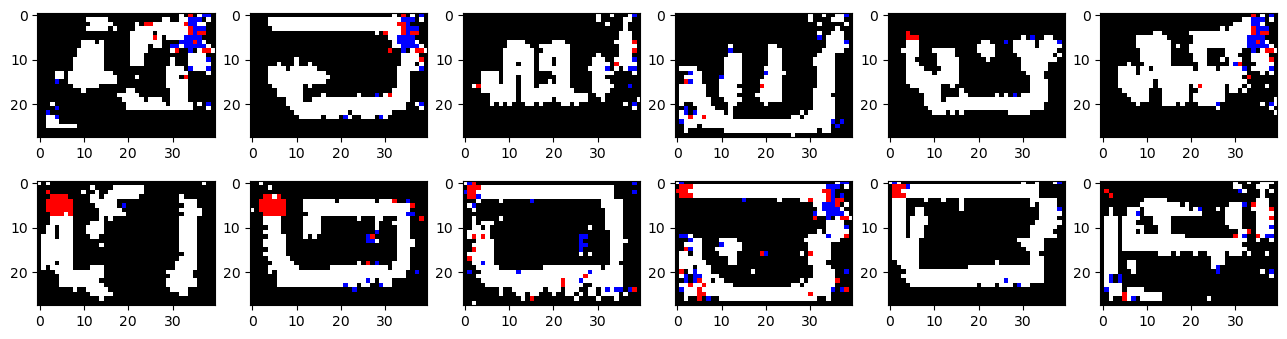

[9601/200]: loss_d: 0.000, loss_g: 9.336
[9602/200]: loss_d: 0.000, loss_g: 9.692
[9603/200]: loss_d: 0.000, loss_g: 8.999
[9604/200]: loss_d: 0.000, loss_g: 9.527
[9605/200]: loss_d: 0.001, loss_g: 9.801
[9606/200]: loss_d: 0.000, loss_g: 10.209
[9607/200]: loss_d: 0.000, loss_g: 9.199
[9608/200]: loss_d: 0.000, loss_g: 9.829
[9609/200]: loss_d: 0.000, loss_g: 9.749
[9610/200]: loss_d: 0.000, loss_g: 8.901
[9611/200]: loss_d: 0.001, loss_g: 8.393
[9612/200]: loss_d: 0.000, loss_g: 9.296
[9613/200]: loss_d: 0.000, loss_g: 9.757
[9614/200]: loss_d: 0.000, loss_g: 9.094
[9615/200]: loss_d: 0.000, loss_g: 10.403
[9616/200]: loss_d: 0.001, loss_g: 8.449
[9617/200]: loss_d: 0.000, loss_g: 9.629
[9618/200]: loss_d: 0.000, loss_g: 10.310
[9619/200]: loss_d: 0.000, loss_g: 9.517
[9620/200]: loss_d: 0.000, loss_g: 10.314
[9621/200]: loss_d: 0.000, loss_g: 9.652
[9622/200]: loss_d: 0.000, loss_g: 9.970
[9623/200]: loss_d: 0.000, loss_g: 9.615
[9624/200]: loss_d: 0.000, loss_g: 9.711
[9625/200]: 

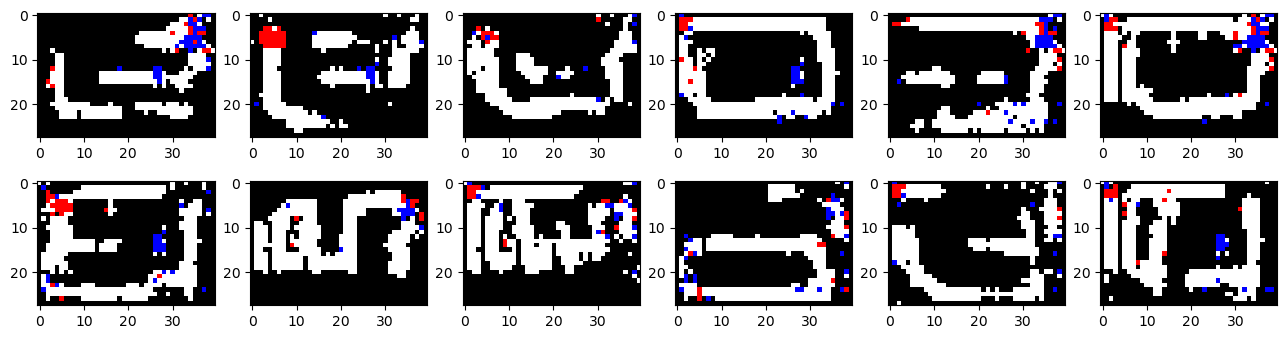

[9701/200]: loss_d: 0.000, loss_g: 10.038
[9702/200]: loss_d: 0.001, loss_g: 9.021
[9703/200]: loss_d: 0.001, loss_g: 8.703
[9704/200]: loss_d: 0.000, loss_g: 10.242
[9705/200]: loss_d: 0.000, loss_g: 10.377
[9706/200]: loss_d: 0.001, loss_g: 8.554
[9707/200]: loss_d: 0.001, loss_g: 8.543
[9708/200]: loss_d: 0.001, loss_g: 10.068
[9709/200]: loss_d: 0.000, loss_g: 9.880
[9710/200]: loss_d: 0.001, loss_g: 8.736
[9711/200]: loss_d: 0.000, loss_g: 10.086
[9712/200]: loss_d: 0.000, loss_g: 10.780
[9713/200]: loss_d: 0.000, loss_g: 9.884
[9714/200]: loss_d: 0.000, loss_g: 9.805
[9715/200]: loss_d: 0.001, loss_g: 8.448
[9716/200]: loss_d: 0.000, loss_g: 9.842
[9717/200]: loss_d: 0.000, loss_g: 9.486
[9718/200]: loss_d: 0.000, loss_g: 9.769
[9719/200]: loss_d: 0.000, loss_g: 9.351
[9720/200]: loss_d: 0.000, loss_g: 9.945
[9721/200]: loss_d: 0.001, loss_g: 9.211
[9722/200]: loss_d: 0.001, loss_g: 8.907
[9723/200]: loss_d: 0.000, loss_g: 8.953
[9724/200]: loss_d: 0.001, loss_g: 8.861
[9725/200]

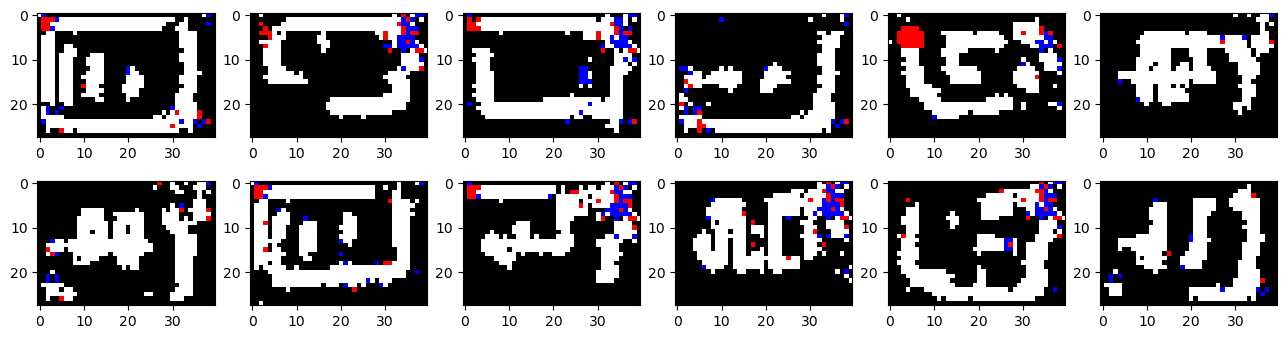

[9801/200]: loss_d: 0.001, loss_g: 9.311
[9802/200]: loss_d: 0.000, loss_g: 9.377
[9803/200]: loss_d: 0.000, loss_g: 9.068
[9804/200]: loss_d: 0.000, loss_g: 9.474
[9805/200]: loss_d: 0.000, loss_g: 9.468
[9806/200]: loss_d: 0.000, loss_g: 8.885
[9807/200]: loss_d: 0.000, loss_g: 9.689
[9808/200]: loss_d: 0.000, loss_g: 9.199
[9809/200]: loss_d: 0.002, loss_g: 7.276
[9810/200]: loss_d: 0.001, loss_g: 9.355
[9811/200]: loss_d: 0.001, loss_g: 9.684
[9812/200]: loss_d: 0.001, loss_g: 9.068
[9813/200]: loss_d: 0.000, loss_g: 10.930
[9814/200]: loss_d: 0.000, loss_g: 9.444
[9815/200]: loss_d: 0.001, loss_g: 8.732
[9816/200]: loss_d: 0.000, loss_g: 10.556
[9817/200]: loss_d: 0.000, loss_g: 9.201
[9818/200]: loss_d: 0.000, loss_g: 9.730
[9819/200]: loss_d: 0.000, loss_g: 9.546
[9820/200]: loss_d: 0.000, loss_g: 9.373
[9821/200]: loss_d: 0.000, loss_g: 10.151
[9822/200]: loss_d: 0.000, loss_g: 10.229
[9823/200]: loss_d: 0.000, loss_g: 9.981
[9824/200]: loss_d: 0.000, loss_g: 9.475
[9825/200]: 

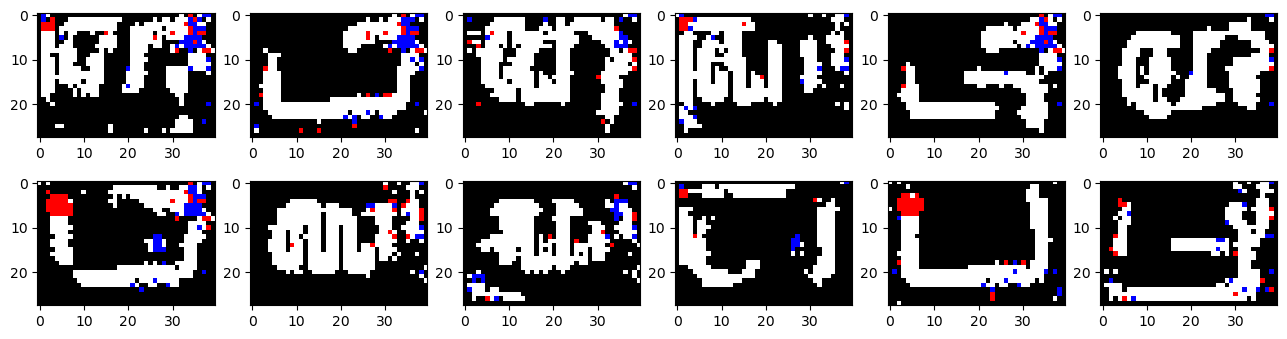

[9901/200]: loss_d: 0.000, loss_g: 9.081
[9902/200]: loss_d: 0.000, loss_g: 8.811
[9903/200]: loss_d: 0.000, loss_g: 11.261
[9904/200]: loss_d: 0.000, loss_g: 9.687
[9905/200]: loss_d: 0.000, loss_g: 9.145
[9906/200]: loss_d: 0.000, loss_g: 9.688
[9907/200]: loss_d: 0.000, loss_g: 9.308
[9908/200]: loss_d: 0.000, loss_g: 9.008
[9909/200]: loss_d: 0.001, loss_g: 8.990
[9910/200]: loss_d: 0.000, loss_g: 9.561
[9911/200]: loss_d: 0.000, loss_g: 10.063
[9912/200]: loss_d: 0.000, loss_g: 8.666
[9913/200]: loss_d: 0.000, loss_g: 9.433
[9914/200]: loss_d: 0.000, loss_g: 9.589
[9915/200]: loss_d: 0.000, loss_g: 9.470
[9916/200]: loss_d: 0.000, loss_g: 8.937
[9917/200]: loss_d: 0.001, loss_g: 8.564
[9918/200]: loss_d: 0.000, loss_g: 9.997
[9919/200]: loss_d: 0.001, loss_g: 9.004
[9920/200]: loss_d: 0.001, loss_g: 9.255
[9921/200]: loss_d: 0.000, loss_g: 10.168
[9922/200]: loss_d: 0.000, loss_g: 10.033
[9923/200]: loss_d: 0.000, loss_g: 10.780
[9924/200]: loss_d: 0.000, loss_g: 9.763
[9925/200]:

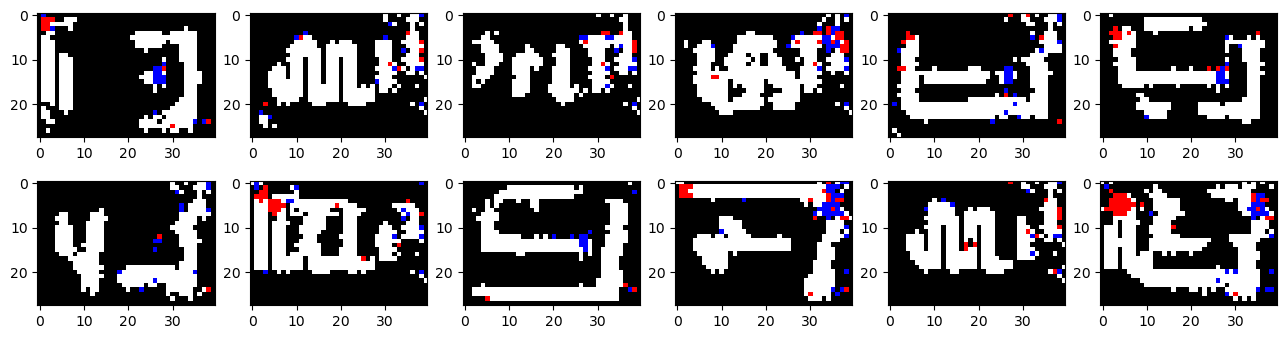

In [12]:
for epoch in range(0, 10000+1):           
    D_losses, G_losses = [], []
    x = data
    # _______Discriminator____________
    D.zero_grad()
    x_real, y_real = x.to(device), torch.ones(bs, 1).to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output.view(-1).reshape(bs, 1), y_real)

    z = torch.randn((bs, z_dim, 1, 1)).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output.view(-1).reshape(bs, 1), y_fake)

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    D_losses.append(D_loss.item())

    # _______Generator____________
    G.zero_grad()

    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output.view(-1).reshape(bs, 1), y)

    G_loss.backward()
    G_optimizer.step() 

    G_losses.append(G_loss.item())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), 200, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    if epoch % 100 == 0:
        with torch.no_grad():
            fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 4))

            a = G_output.argmax(dim=1).cpu().detach()
            for i, ax in enumerate(axes.flat):
                image = create_image_from_array(a[i])
                ax.imshow(image)

            plt.show()